<a href="https://colab.research.google.com/github/clarafreijo/CXR-Scatter-Correction/blob/main/SCATTER_DUAL_CFE_PROJBIEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SCATTER ESTIMATION - PROJECTIONS OF COVID CT

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Install required libraries

In [ ]:
!pip install -q opencv-python
!pip install -q keras-unet

## Load Libraries

In [ ]:
import tensorflow as tf
tf.version.VERSION
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import clear_output
import cv2
import sklearn.model_selection as sk
import pandas as pd
import glob
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_absolute_percentage_error
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

from pylab import array, plot, show, axis, arange, figure, uint8
from scipy.io import loadmat
from skimage import measure
import math
from skimage.morphology import convex_hull_image
import scipy.ndimage as nd
from scipy import stats

## Check GPU

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!nvidia-smi

Wed Jul 20 09:19:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

## Image Parameters

In [ ]:
# Images are expected as float32 values (Little Endian)
Nx = 2050 #154     # Number of pixels in x
Ny = 2050 #154     # Number of pixels in y
Nz = 130 #8*80    # Number of simulated 2D cases

## Load Images (.raw) From Drive (2050 x 2050) & Save csv (Si se usan las mismas imágenes, sólo hay que hacerlo la primera vez)

### Low Energy

No Scatter

In [ ]:
filelist_LE_NS = glob.glob('drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/*.raw')
#x = np.array([np.array(Image.open(fname)) for fname in filelist])
PROJ_LE_NS = np.zeros((Nz,Nx,Ny),dtype='float32')
i = 0
for filename in np.sort(filelist_LE_NS):
  PROJ_LE_single = np.fromfile(filename,dtype='float32')
  PROJ_LE_single = np.reshape(PROJ_LE_single,(2050,2050))
  print(filename)
  PROJ_LE_NS[i,:,:] = PROJ_LE_single
  i = i+1


drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0003.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0011.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0013.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0014.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0016.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0025.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0031.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0034.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0038.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A

In [ ]:
# PASAR A 128X128 PARA NO QUEDARME SIN MEMORIA Y GUARDAR COMO CSV PARA TARDAR MENOS EN CARGARLO
PROJ_LE_NS = np.expand_dims(PROJ_LE_NS,axis=-1)
PROJ_LE_NS = tf.convert_to_tensor(PROJ_LE_NS, tf.float32)

Nx2 = 128 #256
Ny2 = 128

PROJ_LE_NS = tf.image.resize(PROJ_LE_NS,[Nx2,Ny2],method='bilinear')

In [ ]:
PROJ_LE_NS_np = np.squeeze(PROJ_LE_NS.numpy()).reshape(-1,128)
PROJ_LE_NS_pd = pd.DataFrame(PROJ_LE_NS_np)

PROJ_LE_NS_pd.to_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_NS_5e9.csv')

In [ ]:
del PROJ_LE_NS

Total

In [ ]:
filelist_LE_T = glob.glob('drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/*.raw')
#x = np.array([np.array(Image.open(fname)) for fname in filelist])
PROJ_LE_T = np.zeros((Nz,Nx,Ny),dtype='float32')
i = 0
for filename in np.sort(filelist_LE_T):
  PROJ_LE_single = np.fromfile(filename,dtype='float32')
  PROJ_LE_single = np.reshape(PROJ_LE_single,(2050,2050))
  print(filename)
  PROJ_LE_T[i,:,:] = PROJ_LE_single
  i = i+1

drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0003.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0011.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0013.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0014.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0016.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0025.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0031.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0034.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0038.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0039.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_

In [ ]:
# PASAR A 128X128 PARA NO QUEDARME SIN MEMORIA Y GUARDAR COMO CSV PARA TARDAR MENOS EN CARGARLO
PROJ_LE_T = np.expand_dims(PROJ_LE_T,axis=-1)
PROJ_LE_T = tf.convert_to_tensor(PROJ_LE_T, tf.float32)

Nx2 = 128 #256
Ny2 = 128

PROJ_LE_T = tf.image.resize(PROJ_LE_T,[Nx2,Ny2],method='bilinear')

In [ ]:
PROJ_LE_T_np = np.squeeze(PROJ_LE_T.numpy()).reshape(-1,128)
PROJ_LE_T_pd = pd.DataFrame(PROJ_LE_T_np)

PROJ_LE_T_pd.to_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_T_5e9.csv')

In [ ]:
del PROJ_LE_T

Scatter

In [ ]:
filelist_LE_S = glob.glob('drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/*.raw')
#x = np.array([np.array(Image.open(fname)) for fname in filelist])
PROJ_LE_S = np.zeros((Nz,Nx,Ny),dtype='float32')
i = 0
for filename in np.sort(filelist_LE_S):
  PROJ_LE_single = np.fromfile(filename,dtype='float32')
  PROJ_LE_single = np.reshape(PROJ_LE_single,(2050,2050))
  print(filename)
  PROJ_LE_S[i,:,:] = PROJ_LE_single
  i = i+1

drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0003.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0011.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0013.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0014.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0016.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0025.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0031.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0034.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0038.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0039.raw
drive/My Drive/ENERGIA_DUAL_IM

In [ ]:
# PASAR A 128X128 PARA NO QUEDARME SIN MEMORIA Y GUARDAR COMO CSV PARA TARDAR MENOS EN CARGARLO
PROJ_LE_S = np.expand_dims(PROJ_LE_S,axis=-1)
PROJ_LE_S = tf.convert_to_tensor(PROJ_LE_S, tf.float32)

Nx2 = 128 #256
Ny2 = 128

PROJ_LE_S = tf.image.resize(PROJ_LE_S,[Nx2,Ny2],method='bilinear')

In [ ]:
PROJ_LE_S_np = np.squeeze(PROJ_LE_S.numpy()).reshape(-1,128)
PROJ_LE_S_pd = pd.DataFrame(PROJ_LE_S_np)

PROJ_LE_S_pd.to_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_S_5e9.csv')

In [ ]:
del PROJ_LE_S

### High Energy

No Scatter

In [ ]:
filelist_HE_NS = glob.glob('drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/*.raw')
#x = np.array([np.array(Image.open(fname)) for fname in filelist])
PROJ_HE_NS = np.zeros((Nz,Nx,Ny),dtype='float32')
i = 0
for filename in np.sort(filelist_HE_NS):
  PROJ_HE_single = np.fromfile(filename,dtype='float32')
  PROJ_HE_single = np.reshape(PROJ_HE_single,(2050,2050))
  print(filename)
  PROJ_HE_NS[i,:,:] = PROJ_HE_single
  i = i+1

drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0003.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0011.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0013.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0014.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0016.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0025.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0031.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0034.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0038.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A

In [ ]:
# PASAR A 128X128 PARA NO QUEDARME SIN MEMORIA Y GUARDAR COMO CSV PARA TARDAR MENOS EN CARGARLO
PROJ_HE_NS = np.expand_dims(PROJ_HE_NS,axis=-1)
PROJ_HE_NS = tf.convert_to_tensor(PROJ_HE_NS, tf.float32)

Nx2 = 128 #256
Ny2 = 128

PROJ_HE_NS = tf.image.resize(PROJ_HE_NS,[Nx2,Ny2],method='bilinear')

In [ ]:
PROJ_HE_NS_np = np.squeeze(PROJ_HE_NS.numpy()).reshape(-1,128)
PROJ_HE_NS_pd = pd.DataFrame(PROJ_HE_NS_np)

PROJ_HE_NS_pd.to_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_NS_5e9.csv')

In [ ]:
del PROJ_HE_NS
del PROJ_HE_NS_np
del PROJ_HE_NS_pd

Total

In [ ]:
filelist_HE_T = glob.glob('drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/*.raw')
#x = np.array([np.array(Image.open(fname)) for fname in filelist])
PROJ_HE_T = np.zeros((Nz,Nx,Ny),dtype='float32')
i = 0
for filename in np.sort(filelist_HE_T):
  PROJ_HE_single = np.fromfile(filename,dtype='float32')
  PROJ_HE_single = np.reshape(PROJ_HE_single,(2050,2050))
  print(filename)
  PROJ_HE_T[i,:,:] = PROJ_HE_single
  i = i+1

drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0003.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0011.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0013.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0014.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0016.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0025.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0031.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0034.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0038.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0039.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_

In [ ]:
# PASAR A 128X128 PARA NO QUEDARME SIN MEMORIA Y GUARDAR COMO CSV PARA TARDAR MENOS EN CARGARLO
PROJ_HE_T = np.expand_dims(PROJ_HE_T,axis=-1)
PROJ_HE_T = tf.convert_to_tensor(PROJ_HE_T, tf.float32)

Nx2 = 128 #256
Ny2 = 128

PROJ_HE_T = tf.image.resize(PROJ_HE_T,[Nx2,Ny2],method='bilinear')

In [ ]:
PROJ_HE_T_np = np.squeeze(PROJ_HE_T.numpy()).reshape(-1,128)
PROJ_HE_T_pd = pd.DataFrame(PROJ_HE_T_np)

PROJ_HE_T_pd.to_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_T_5e9.csv')

In [ ]:
del PROJ_HE_T
del PROJ_HE_T_np
del PROJ_HE_T_pd

Scatter

In [ ]:
filelist_HE_S = glob.glob('drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/*.raw')
#x = np.array([np.array(Image.open(fname)) for fname in filelist])
PROJ_HE_S = np.zeros((Nz,Nx,Ny),dtype='float32')
i = 0
for filename in np.sort(filelist_HE_S):
  PROJ_HE_single = np.fromfile(filename,dtype='float32')
  PROJ_HE_single = np.reshape(PROJ_HE_single,(2050,2050))
  print(filename)
  PROJ_HE_S[i,:,:] = PROJ_HE_single
  i = i+1

drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0003.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0011.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0013.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0014.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0016.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0025.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0031.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0034.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0038.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0039.raw
drive/My Drive/ENERGIA_DUAL_IM

In [ ]:
# PASAR A 128X128 PARA NO QUEDARME SIN MEMORIA Y GUARDAR COMO CSV PARA TARDAR MENOS EN CARGARLO
PROJ_HE_S = np.expand_dims(PROJ_HE_S,axis=-1)
PROJ_HE_S = tf.convert_to_tensor(PROJ_HE_S, tf.float32)

Nx2 = 128 #256
Ny2 = 128

PROJ_HE_S = tf.image.resize(PROJ_HE_S,[Nx2,Ny2],method='bilinear')

In [ ]:
PROJ_HE_S_np = np.squeeze(PROJ_HE_S.numpy()).reshape(-1,128)
PROJ_HE_S_pd = pd.DataFrame(PROJ_HE_S_np)

PROJ_HE_S_pd.to_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_S_5e9.csv')

In [ ]:
del PROJ_HE_S
del PROJ_HE_S_np
del PROJ_HE_S_pd

## LOAD DATA FOR TRAINING - INPUT/OUTPUT VARIABLES

In [ ]:
# Pandas DataFrame
inp_np_HE = pd.read_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_T_5e9.csv')
out_np_HE = pd.read_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_S_5e9.csv')
inp_np_LE = pd.read_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_T_5e9.csv')
out_np_LE = pd.read_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_S_5e9.csv')

# Pandas DataFrame --> Numpy Array
inp_np_HE = inp_np_HE.to_numpy()
out_np_HE = out_np_HE.to_numpy()
inp_np_LE = inp_np_LE.to_numpy()
out_np_LE = out_np_LE.to_numpy()

# Remove extra column
inp_np_HE = inp_np_HE[:,1:129]
out_np_HE = out_np_HE[:,1:129]
inp_np_LE = inp_np_LE[:,1:129]
out_np_LE = out_np_LE[:,1:129]

# Reshape first dimension
inp_np_HE = inp_np_HE.reshape((130,128,128))
out_np_HE = out_np_HE.reshape((130,128,128))
inp_np_LE = inp_np_LE.reshape((130,128,128))
out_np_LE = out_np_LE.reshape((130,128,128))

inp_np_HE = np.expand_dims(inp_np_HE,axis=-1)
out_np_HE = np.expand_dims(out_np_HE,axis=-1)
inp_np_LE = np.expand_dims(inp_np_LE,axis=-1)
out_np_LE = np.expand_dims(out_np_LE,axis=-1)

inp_np_HE = tf.convert_to_tensor(inp_np_HE, tf.float32)
out_np_HE = tf.convert_to_tensor(out_np_HE, tf.float32)
inp_np_LE = tf.convert_to_tensor(inp_np_LE, tf.float32)
out_np_LE = tf.convert_to_tensor(out_np_LE, tf.float32)

Nx2 = 128 #256
Ny2 = 128

inp_np_HE = tf.image.resize(inp_np_HE,[Nx2,Ny2],method='bilinear')
out_np_HE = tf.image.resize(out_np_HE,[Nx2,Ny2],method='bilinear')
inp_np_LE = tf.image.resize(inp_np_LE,[Nx2,Ny2],method='bilinear')
out_np_LE = tf.image.resize(out_np_LE,[Nx2,Ny2],method='bilinear')

inp_np_HE = inp_np_HE.numpy()
out_np_HE = out_np_HE.numpy()
inp_np_LE = inp_np_LE.numpy()
out_np_LE = out_np_LE.numpy()

print(inp_np_HE.shape)

(130, 128, 128, 1)


### Recortar imágenes (para quitar aire)

In [ ]:
inp_np_HE_cut = inp_np_HE[:,:,16:112,:]
out_np_HE_cut = out_np_HE[:,:,16:112,:]
inp_np_LE_cut = inp_np_LE[:,:,16:112,:]
out_np_LE_cut = out_np_LE[:,:,16:112,:]

print(inp_np_LE_cut.shape)

(130, 128, 96, 1)


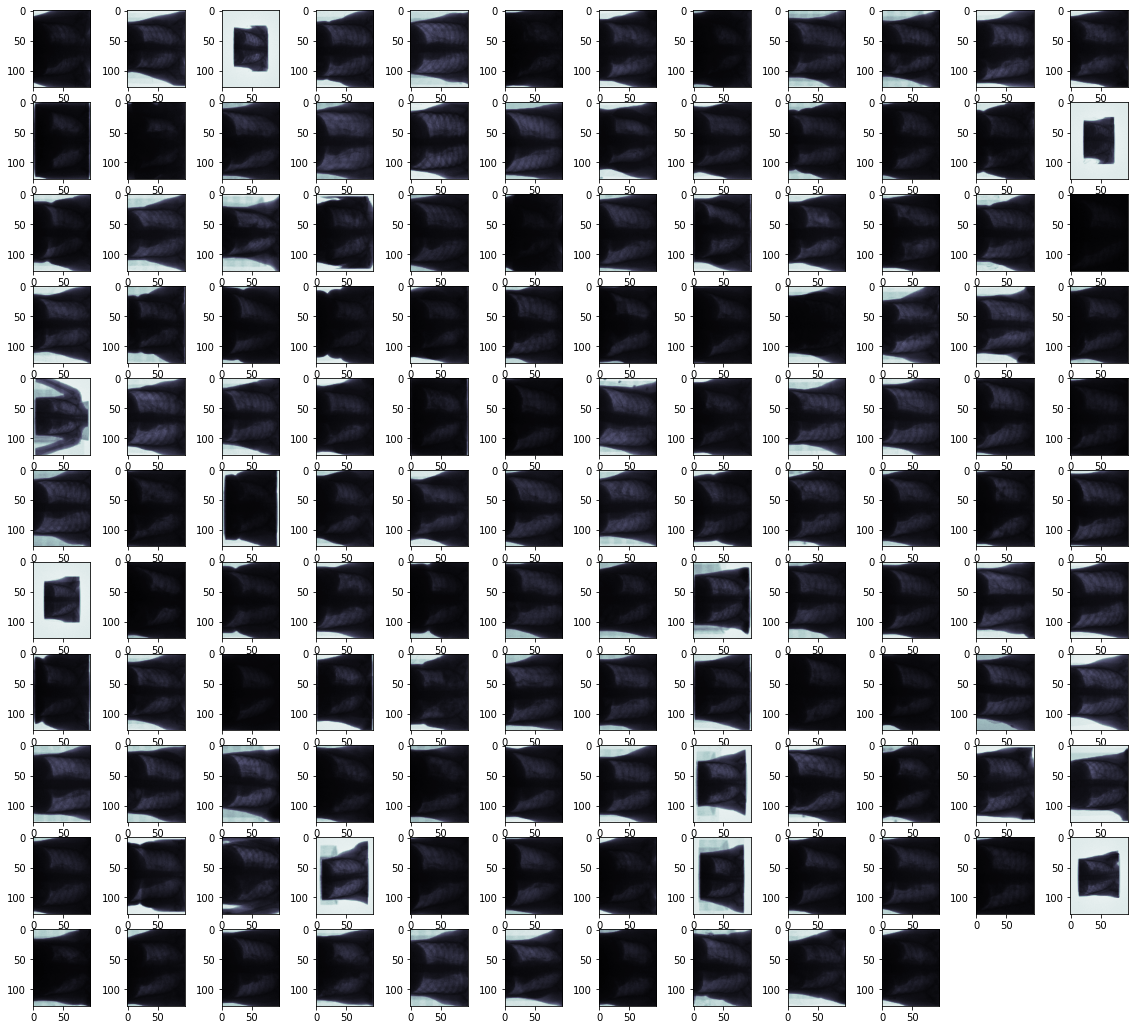

In [ ]:
plt.figure(figsize=(20,20))
for i in range(0,len(inp_np_HE_cut)):
   plt.subplot(12,12,i+1)
   plt.imshow(np.squeeze(inp_np_HE_cut[i,0:128,:,:]),cmap=plt.cm.bone,vmin=0,vmax=1.075)

In [ ]:
print(type(inp_np_HE))
print(type(inp_np_HE_cut))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Eliminar imágenes con objeto pequeño

In [ ]:
inp_np_HE_cut = np.delete(inp_np_HE_cut,[2,23,48,72,103,111,115,119],axis=0)
inp_np_LE_cut = np.delete(inp_np_LE_cut,[2,23,48,72,103,111,115,119],axis=0)
print(inp_np_HE_cut.shape)

(122, 128, 96, 1)


In [ ]:
out_np_HE_cut = np.delete(out_np_HE_cut,[2,23,48,72,103,111,115,119],axis=0)
out_np_LE_cut = np.delete(out_np_LE_cut,[2,23,48,72,103,111,115,119],axis=0)
print(out_np_HE_cut.shape)

(122, 128, 96, 1)


In [ ]:
# PARA ENTRENAMIENTO DUAL CON DOS CANALES
inp_np_cut_dual = np.zeros([len(inp_np_HE_cut),128,96,2])
inp_np_cut_dual[:,:,:,0] = inp_np_LE_cut[:,:,:,0]   #[:,0:128,:,0]
inp_np_cut_dual[:,:,:,1] = inp_np_HE_cut[:,:,:,0]   #[:,128:256,:,0]

### Figuras Ejemplo para ppt

(-0.5, 127.5, 95.5, -0.5)

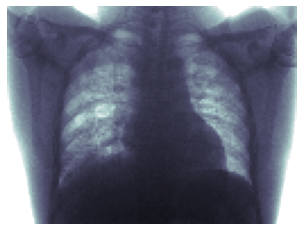

In [ ]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(inp_np_HE_cut[0,:,:,0])),cmap=plt.cm.bone,vmin=0,vmax=0.2)
plt.axis('off')
# cbar = plt.colorbar(ticks=[0, 0.1, 0.2])
# cbar.ax.set_yticklabels([0,0.1,0.2],fontsize=15)

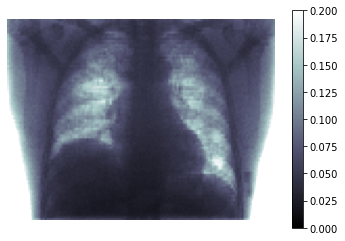

In [ ]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(inp_np_HE_cut[121,:,:,0])),cmap=plt.cm.bone,vmin=0,vmax=0.2)
plt.axis('off')
plt.colorbar()

(-0.5, 127.5, 95.5, -0.5)

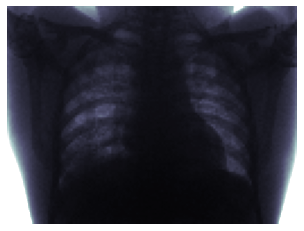

In [ ]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(inp_np_LE_cut[0,:,:,0])),cmap=plt.cm.bone,vmin=0,vmax=0.2)
plt.axis('off')
# cbar = plt.colorbar(ticks=[0, 0.1, 0.2],orientation='horizontal')
# cbar.ax.set_xticklabels([0,0.1,0.2],fontsize=15)

(-0.5, 127.5, 95.5, -0.5)

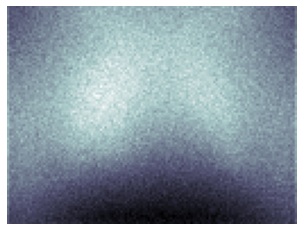

In [ ]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(out_np_HE_cut[0,:,:,0])),cmap=plt.cm.bone)
plt.axis('off')
# cbar = plt.colorbar(ticks=[0.015, 0.050],orientation='horizontal')
# cbar.ax.set_xticklabels([0.015, 0.050],fontsize=15)

In [ ]:
np.max(np.squeeze(out_np_HE_cut[0,:,:,0]))

0.05017305

### Visualize all images

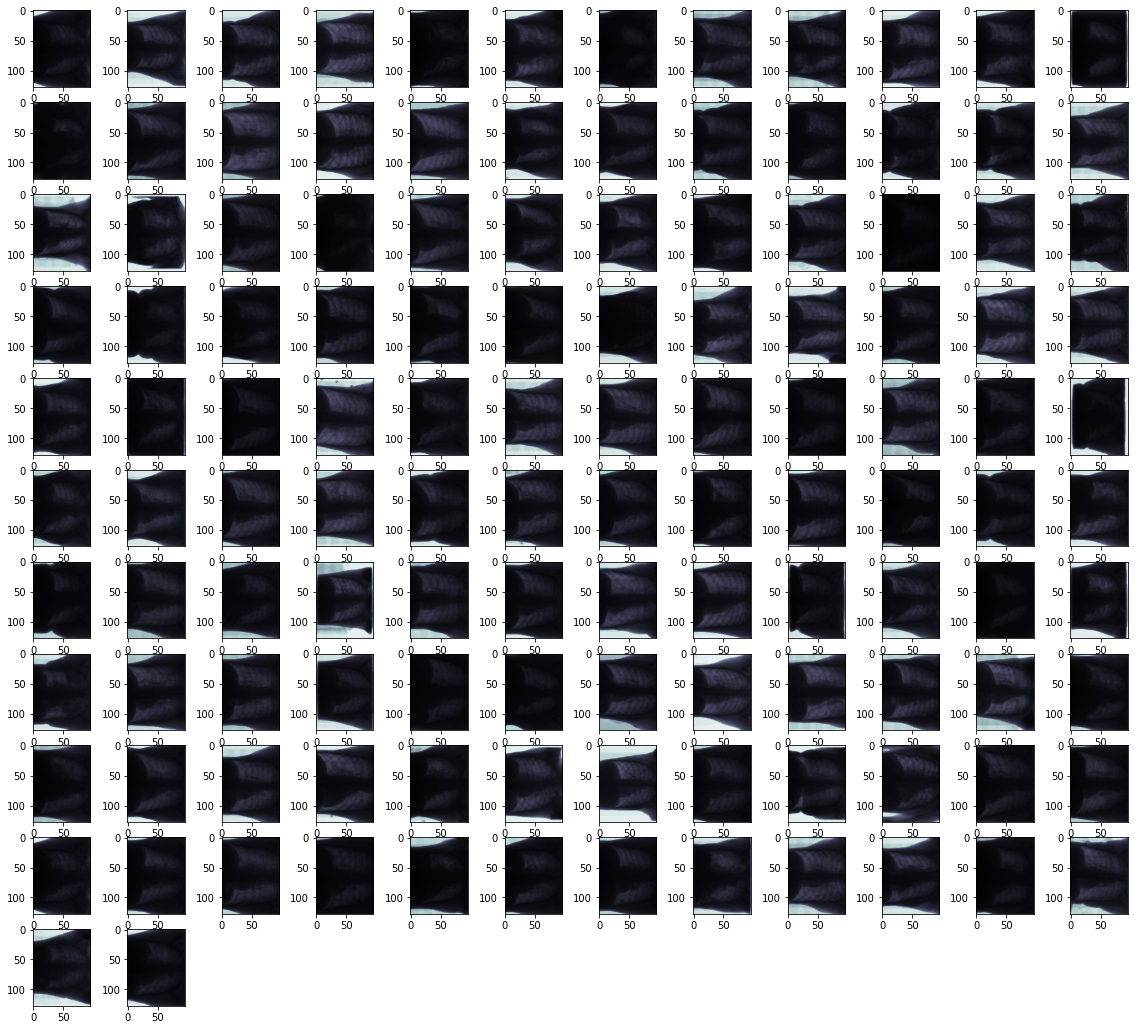

In [ ]:
plt.figure(figsize=(20,20))
for i in range(0,len(inp_np_HE_cut)):
   plt.subplot(12,12,i+1)
   plt.imshow(np.squeeze(inp_np_HE_cut[i,0:128,:,:]),cmap=plt.cm.bone,vmin=0,vmax=1.075)

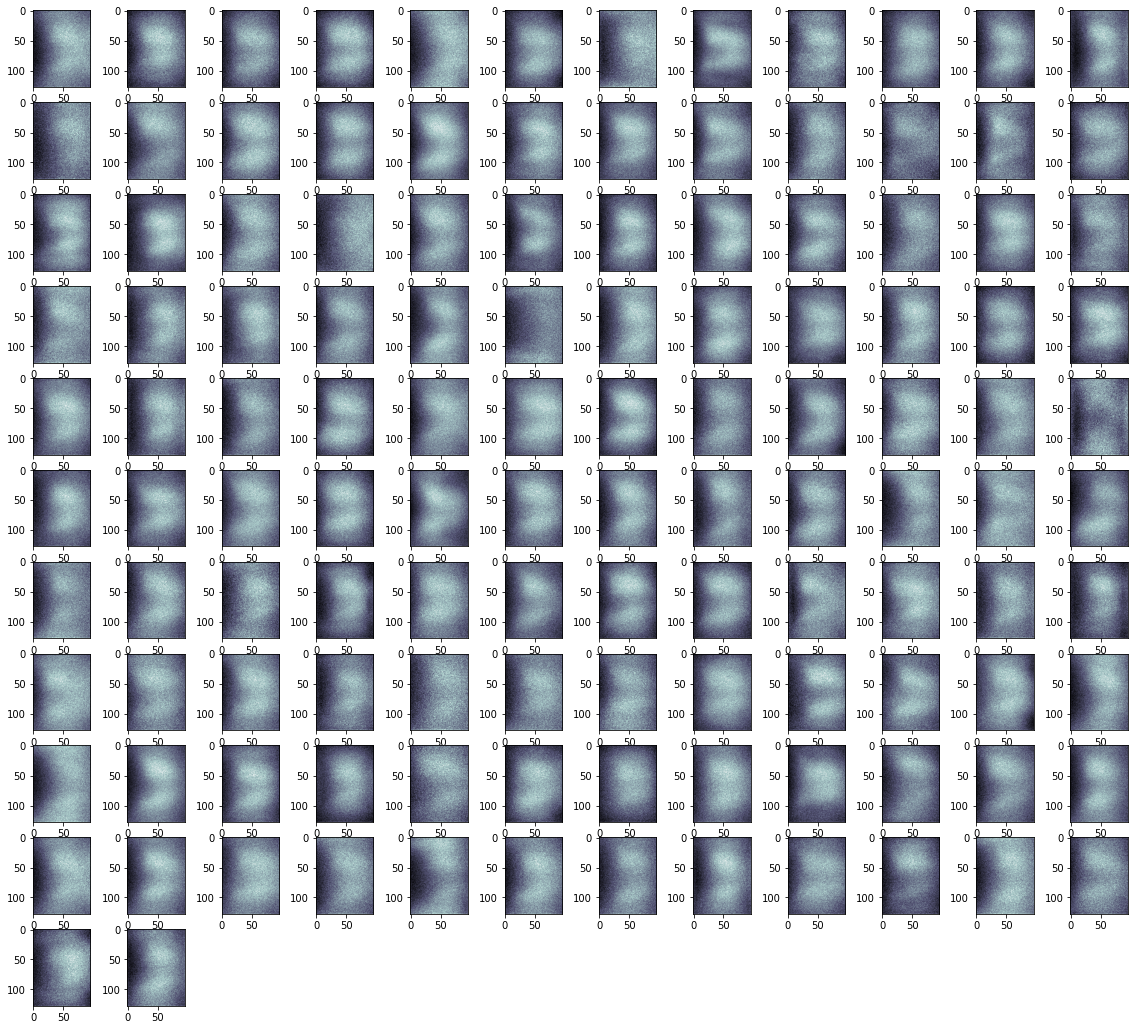

In [ ]:
plt.figure(figsize=(20,20))
for i in range(0,len(out_np_HE_cut)):
   plt.subplot(12,12,i+1)
   plt.imshow(np.squeeze(out_np_HE_cut[i,0:128,:,:]),cmap=plt.cm.bone) #,vmin=0,vmax=1.075)

## OUTPUT NORMALIZATION - SCATTER FRACTION

### NORMALIZACIÓN 3: INPUT <--> TOTAL // **OUTPUT <--> SCATTER/TOTAL**




#### Imágenes recortadas

In [ ]:
# Para imágenes recortadas
out_np_LE_norm = np.zeros_like(out_np_LE_cut)
out_np_HE_norm = np.zeros_like(out_np_HE_cut)
for i in range(0,len(out_np_LE_cut)):
  out_np_LE_norm[i,:,:,:] = out_np_LE_cut[i,:,:,:]/(inp_np_LE_cut[i,:,:,:]) #+0.01*inp_np[i,0:128,:,:].max())
  out_np_HE_norm[i,:,:,:] = out_np_HE_cut[i,:,:,:]/(inp_np_HE_cut[i,:,:,:]) #+0.01*inp_np[i,128:256,:,:].max())

print(out_np_HE_norm.shape)

(130, 128, 96, 1)


In [ ]:
# DOS CANALES PARA ANÁLISIS DUAL
#inp_np_dual = np.zeros([100,128,128,2])
#inp_np_dual[:,:,:,0] = inp_np[:,0:128,:,0]
#inp_np_dual[:,:,:,1] = inp_np[:,128:256,:,0]

## Figures - Example (definitivas)

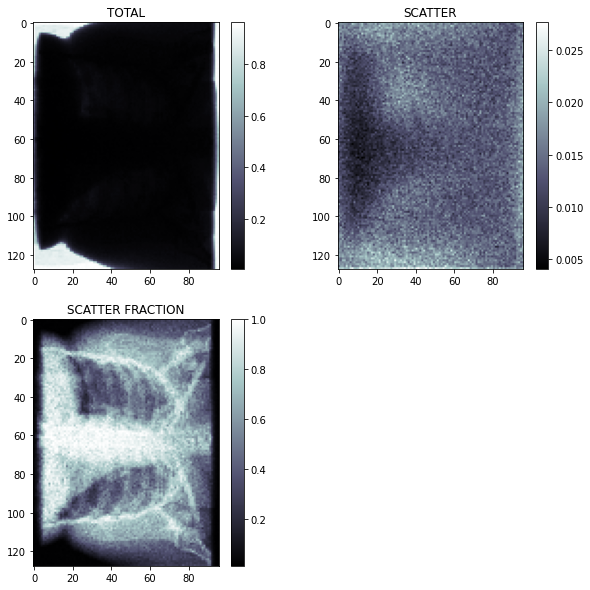

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.imshow(np.squeeze(inp_np_LE_cut[80,:,:,:]),cmap=plt.cm.bone)
plt.title('TOTAL')
plt.colorbar()
#plt.plot([0,127],[40,40],'yellow',linestyle='-')

plt.subplot(2,2,2)
plt.imshow(np.squeeze(out_np_LE_cut[80,:,:,:]),cmap=plt.cm.bone)
plt.title('SCATTER')
plt.colorbar()
#plt.plot([76,79],[40,40],'y',linestyle='-')

plt.subplot(2,2,3)
plt.imshow(np.squeeze(out_np_LE_norm[80,:,:,:]),cmap=plt.cm.bone)
plt.title('SCATTER FRACTION')
plt.colorbar()

(-0.5, 127.5, 95.5, -0.5)

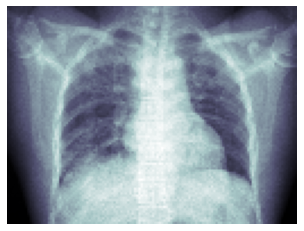

In [ ]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(out_np_HE_norm[0,:,:,0])),cmap=plt.cm.bone)
plt.axis('off')

## SPLIT DATA INTO TRAIN AND VALIDATION SETS

### Imágenes recortadas

In [ ]:
# ALTA ENERGÍA
x_train_HE = inp_np_HE_cut[0:70,:,:,:]
x_val_HE = inp_np_HE_cut[70:100,:,:,:]
y_train_HE = out_np_HE_norm[0:70,:,:,:]
y_val_HE = out_np_HE_norm[70:100,:,:,:]

In [ ]:
# BAJA ENERGÍA
x_train_LE = inp_np_LE_cut[0:70,:,:,:]
x_val_LE = inp_np_LE_cut[70:100,:,:,:]
y_train_LE = out_np_LE_norm[0:70,:,:,:]
y_val_LE = out_np_LE_norm[70:100,:,:,:]

## Numpy to Tensor (para input del NN model)

In [ ]:
# ALTA ENERGÍA
x_train_tf_HE = tf.convert_to_tensor(x_train_HE, tf.float32)
x_val_tf_HE = tf.convert_to_tensor(x_val_HE, tf.float32)
y_train_tf_HE = tf.convert_to_tensor(y_train_HE, tf.float32)
y_val_tf_HE = tf.convert_to_tensor(y_val_HE, tf.float32)

In [ ]:
# BAJA ENERGÍA
x_train_tf_LE = tf.convert_to_tensor(x_train_LE, tf.float32)
x_val_tf_LE = tf.convert_to_tensor(x_val_LE, tf.float32)
y_train_tf_LE = tf.convert_to_tensor(y_train_LE, tf.float32)
y_val_tf_LE = tf.convert_to_tensor(y_val_LE, tf.float32)

In [ ]:
x_train_tf_HE.shape

TensorShape([70, 128, 96, 1])

# NEURAL NETWORK: MultiResUnet - High Energy

## Select High Energy Data (para DATOS VIEJOS)

In [ ]:
x_train_tf_HE = x_train_tf[:,128:256,:,:]
x_val_tf_HE = x_val_tf[:,128:256,:,:]
y_train_tf_HE = y_train_tf[:,128:256,:,:]
y_val_tf_HE = y_val_tf[:,128:256,:,:]

In [ ]:
#x_train_tf_HE = x_train_tf
#x_val_tf_HE = x_val_tf
#y_train_tf_HE = y_train_tf
#y_val_tf_HE = y_val_tf

## Load Modules

In [ ]:
from keras_unet.models import custom_unet
from keras_unet.utils import get_augmented
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## Data Augmentation

https://github.com/karolzak/keras-unet/blob/master/keras_unet/utils.py

In [ ]:
def get_augmented_mod(
    X_train,
    Y_train,
    X_val=None,
    Y_val=None,
    batch_size=32,
    seed=0,
    data_gen_args=dict(
        rotation_range=10.0,
        # width_shift_range=0.02,
        height_shift_range=0.02,
        shear_range=5,
        # zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode="constant",
    ),
):
    """[summary]

    Args:
        X_train (numpy.ndarray): [description]
        Y_train (numpy.ndarray): [description]
        X_val (numpy.ndarray, optional): [description]. Defaults to None.
        Y_val (numpy.ndarray, optional): [description]. Defaults to None.
        batch_size (int, optional): [description]. Defaults to 32.
        seed (int, optional): [description]. Defaults to 0.
        data_gen_args ([type], optional): [description]. Defaults to dict(rotation_range=10.0,# width_shift_range=0.02,height_shift_range=0.02,shear_range=5,# zoom_range=0.3,horizontal_flip=True,vertical_flip=False,fill_mode="constant",).

    Returns:
        [type]: [description]
    """

    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
    train_generator = zip(X_train_augmented, Y_train_augmented)
    #train_generator = X_train_augmented, Y_train_augmented

    if not (X_val is None) and not (Y_val is None):
        # Validation data, no data augmentation, but we create a generator anyway
        X_datagen_val = ImageDataGenerator(**data_gen_args)
        Y_datagen_val = ImageDataGenerator(**data_gen_args)
        X_datagen_val.fit(X_val, augment=False, seed=seed)
        Y_datagen_val.fit(Y_val, augment=False, seed=seed)
        X_val_augmented = X_datagen_val.flow(X_val, batch_size=batch_size, shuffle=False, seed=seed)
        Y_val_augmented = Y_datagen_val.flow(Y_val, batch_size=batch_size, shuffle=False, seed=seed)

        # combine generators into one which yields image and masks
        val_generator = zip(X_val_augmented, Y_val_augmented)

        #return train_generator, val_generator
        return X_train_augmented, Y_train_augmented, X_val_augmented, Y_val_augmented
    else:
        return train_generator
        #return X_train_augmented, Y_train_augmented

In [ ]:
train_gen = get_augmented_mod(x_train_tf_HE, y_train_tf_HE, batch_size=24,
   data_gen_args = dict(width_shift_range=0.0,height_shift_range=0.0,rotation_range=0.0,
       horizontal_flip=True,vertical_flip=True,fill_mode='nearest', zoom_range=[0.5,1]))

# train_gen = get_augmented_mod(x_train_tf_HE[0:64,:,:,:], y_train_tf_HE[0:64,:,:,:], batch_size=16,
#     data_gen_args = dict(width_shift_range=0.0,height_shift_range=0.0,rotation_range=0.0,
#         horizontal_flip=True,vertical_flip=True,fill_mode='nearest', zoom_range=[0.5,1]))

NameError: ignored

IndexError: ignored

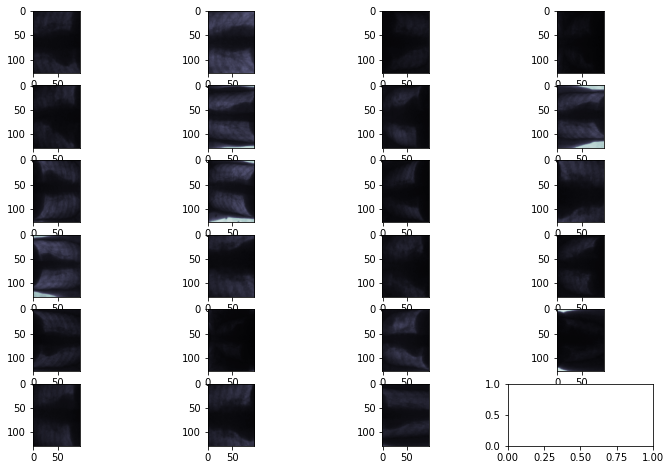

In [ ]:
xnew =[]
plt.figure(figsize=(12,8))
i=0
for xnew, ynew in train_gen:
  plt.subplot(6,4,i+1)
  plt.imshow(np.squeeze(xnew[i,:,:]),cmap=plt.cm.bone,vmin=0,vmax=1.075)
  i=i+1
  #plt.imshow(np.squeeze(ynew[i,:,:]),cmap=plt.cm.bone)

## MultiResUnet Architecture

#### Original

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
#from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model



def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding,use_bias=False,kernel_initializer="he_normal")(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x
    x = Activation(activation, name=name)(x)
    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corresponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp
    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')
    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')
    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')
    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)
    return out


def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')
    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)
    return out


def MultiResUnet(height, width, n_channels,filters):
    '''
    MultiResUNet

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))
    #inputs_SF = Input((height, width, n_channels))  #CFE: prueba para añadir loss function en el modelo

    mresblock1 = MultiResBlock(filters, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(filters, 4, mresblock1)

    mresblock2 = MultiResBlock(filters*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(filters*2, 3, mresblock2)

    mresblock3 = MultiResBlock(filters*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(filters*4, 2, mresblock3)

    mresblock4 = MultiResBlock(filters*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(filters*8, 1, mresblock4)

    mresblock5 = MultiResBlock(filters*16, pool4)

    print(inputs.shape)
    print(mresblock1.shape)
    print(mresblock2.shape)
    print(mresblock3.shape)
    print(mresblock4.shape)
    print(mresblock5.shape)
    # ORIGINAL
    up6 = concatenate([Conv2DTranspose(
       filters*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(filters*8, up6)

    up7 = concatenate([Conv2DTranspose(
       filters*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(filters*4, up7)

    up8 = concatenate([Conv2DTranspose(
       filters*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(filters*2, up8)

    up9 = concatenate([Conv2DTranspose(filters, (2, 2), strides=(
       2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(filters, up9)

    # PRUEBA SIN CONCATENAR
    # up6 = Conv2DTranspose(filters*8, (2, 2), strides=(2, 2), padding='same')(mresblock5)
    # mresblock6 = MultiResBlock(filters*8, up6)

    # up7 = Conv2DTranspose(filters*4, (2, 2), strides=(2, 2), padding='same')(mresblock6)
    # mresblock7 = MultiResBlock(filters*4, up7)

    # up8 = Conv2DTranspose(filters*2, (2, 2), strides=(2, 2), padding='same')(mresblock7)
    # mresblock8 = MultiResBlock(filters*2, up8)

    # up9 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(mresblock8)
    # mresblock9 = MultiResBlock(filters, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='relu')

    model = Model(inputs=[inputs], outputs=[conv10])

    # # Construct your custom loss as a tensor And Compile without specifying a loss
    # loss = K.mean(K.square(inputs_SF*inputs_T - outputs*input_T), axis=-1)
    # ## Add loss to model
    # model.add_loss(loss)

    return model

#### Loss function dentro del modelo

https://localcoder.org/keras-custom-loss-function-accessing-current-input-pattern

In [ ]:
# ARQUITECTURA CON LOSS FUNCTION DENTRO DEL MODELO
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
#from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model



def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding,use_bias=False,kernel_initializer="he_normal")(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x
    x = Activation(activation, name=name)(x)
    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corresponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp
    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')
    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')
    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')
    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)
    return out


def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')
    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)
    return out


def MultiResUnet(height, width, n_channels,filters):
    '''
    MultiResUNet

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))
    #inputs_T = Input((height, width, n_channels))
    #inputs_SF = Input((height, width, n_channels))  #CFE: prueba para añadir loss function en el modelo
    inputs_T = tf.expand_dims(inputs[:,:,:,0],-1)
    inputs_SF = tf.expand_dims(inputs[:,:,:,1],-1)

    mresblock1 = MultiResBlock(filters, inputs_T)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(filters, 4, mresblock1)

    mresblock2 = MultiResBlock(filters*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(filters*2, 3, mresblock2)

    mresblock3 = MultiResBlock(filters*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(filters*4, 2, mresblock3)

    mresblock4 = MultiResBlock(filters*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(filters*8, 1, mresblock4)

    mresblock5 = MultiResBlock(filters*16, pool4)

    print(inputs_T.shape)
    print(mresblock1.shape)
    print(mresblock2.shape)
    print(mresblock3.shape)
    print(mresblock4.shape)
    print(mresblock5.shape)
    # ORIGINAL
    up6 = concatenate([Conv2DTranspose(
       filters*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(filters*8, up6)

    up7 = concatenate([Conv2DTranspose(
       filters*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(filters*4, up7)

    up8 = concatenate([Conv2DTranspose(
       filters*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(filters*2, up8)

    up9 = concatenate([Conv2DTranspose(filters, (2, 2), strides=(
       2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(filters, up9)

    # PRUEBA SIN CONCATENAR
    # up6 = Conv2DTranspose(filters*8, (2, 2), strides=(2, 2), padding='same')(mresblock5)
    # mresblock6 = MultiResBlock(filters*8, up6)

    # up7 = Conv2DTranspose(filters*4, (2, 2), strides=(2, 2), padding='same')(mresblock6)
    # mresblock7 = MultiResBlock(filters*4, up7)

    # up8 = Conv2DTranspose(filters*2, (2, 2), strides=(2, 2), padding='same')(mresblock7)
    # mresblock8 = MultiResBlock(filters*2, up8)

    # up9 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(mresblock8)
    # mresblock9 = MultiResBlock(filters, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='relu')
    estim_SF = conv10

    #model = Model(inputs=[inputs_T,inputs_SF], outputs=[conv10])
    model = Model(inputs=inputs, outputs=estim_SF)

    # Construct your custom loss as a tensor And Compile without specifying a loss
    #loss = K.mean(K.square(inputs_SF*inputs_T - conv10*inputs_T))  #MSE
    #loss = K.mean(K.abs(inputs_SF*inputs_T - conv10*inputs_T))  #MAE
    landa = 0.3
    loss = landa*K.mean(K.square(inputs_SF*inputs_T - estim_SF*inputs_T))+(1-landa)*K.mean(K.square(inputs_SF - estim_SF))  #MSE (mezcla scatter fraction y scatter)
    #loss = K.mean(K.square(inputs_SF - estim_SF))  #MSE (solo scatter fraction)
    ## Add loss to model
    model.add_loss(loss)

    # Add metric to model
    #self.add_metric(tf.reduce_sum(inputs), name='mean_activation')
    metric = K.mean(K.abs(inputs_SF - estim_SF))  #MAE
    model.add_metric(metric,name='metric_MAE')

    return model

In [ ]:

# #def custom_loss_wrapper(input_tensor):
# def custom_loss(y_true, y_pred):
#   CL =  K.mean(K.square(y_true - y_pred)) #+ K.mean(input_tensor)
#   return CL

## Model Definition

In [ ]:
#Run this for MultiResUnet Network
filters=64
channels=3 #2
mresunet=MultiResUnet(x_train_tf_HE.shape[1],x_train_tf_HE.shape[2],channels,filters)  #MultiResUnet(Ny,Nx,channels,filters)

(None, 128, 96, 1)
(None, 128, 96, 64)
(None, 64, 48, 128)
(None, 32, 24, 256)
(None, 16, 12, 512)
(None, 8, 6, 1709)


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
#mresunet.compile(optimizer=opt, loss='MeanSquaredError')   #l1 NORM #MeanSquaredError #MeanAbsoluteError #mean_squared_logarithmic_error #root_mean_squared_error
#mresunet.compile(optimizer=opt, loss=custom_loss)   #l1 NORM #MeanSquaredError #MeanAbsoluteError #mean_squared_logarithmic_error #root_mean_squared_error
mresunet.compile(optimizer=opt)   #Si la loss funtion está añadida en el modelo
#checkpoint6 = ModelCheckpoint(filepath=model_dir + 'multires_needle-spine.h5', monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False, mode ='auto', save_frequency=1)

## DATA AUGMENTED

In [ ]:
# Train data, provide the same seed and keyword arguments to the fit and flow methods
def get_augmented_mod(
    X_train, Y_train, batch_size=32, seed=0,
    data_gen_args=dict(rotation_range=0.0, width_shift_range=0.,
        height_shift_range=0.0, shear_range=0, zoom_range=[0.5,1],
        horizontal_flip=True, vertical_flip=True, fill_mode="nearest")):
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
    train_generator = zip(X_train_augmented, Y_train_augmented)
    return train_generator
    #return train_generator, X_train_augmented, Y_train_augmented

In [ ]:
train_gen = get_augmented_mod(x_train_tf_HE, y_train_tf_HE, batch_size=24,
   data_gen_args = dict(width_shift_range=0.0,height_shift_range=0.0,rotation_range=0.0,
       horizontal_flip=True,vertical_flip=True,fill_mode='nearest', zoom_range=[0.5,1]))

# train_gen = get_augmented_mod(x_train_tf_HE[0:64,:,:,:], y_train_tf_HE[0:64,:,:,:], batch_size=16,
#     data_gen_args = dict(width_shift_range=0.0,height_shift_range=0.0,rotation_range=0.0,
#         horizontal_flip=True,vertical_flip=True,fill_mode='nearest', zoom_range=[0.5,1]))

In [ ]:
# unzip = zip(*train_gen) #-->Para descomprimir, pero aquí se queda sin memoria
# print(type(unzip))
# #print(type(XX))

## Run Training

In [ ]:
xx = tf.concat([x_train_tf_HE,y_train_tf_HE,x_train_tf_HE*y_train_tf_HE],-1)
print(xx.shape)

(70, 128, 96, 3)


In [ ]:
def get_augmented_3channels(X_train, batch_size=32):
    X_datagen = ImageDataGenerator(rotation_range=0.0, width_shift_range=0.,
        height_shift_range=0.0, shear_range=0, zoom_range=[0.5,1],
        horizontal_flip=True, vertical_flip=True, fill_mode="nearest")
    X_datagen.fit(X_train, augment=True)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True)
    return X_train_augmented

In [ ]:
train_gen = get_augmented_3channels(xx)

In [ ]:
yy = tf.concat([x_val_tf_HE,y_val_tf_HE,x_val_tf_HE*y_val_tf_HE],-1)
print(yy.shape)

(30, 128, 96, 3)


In [ ]:
#history6 = mresunet.fit(x_train_tf_HE, y_train_tf_HE,batch_size=32, steps_per_epoch=10, epochs=400,validation_data=(x_val_tf_HE,y_val_tf_HE))  #,steps_per_epoch=10, epochs=400, validation_data=(x_val_tf_HE,y_val_tf_HE)) #,callbacks=[checkpoint6])
#history6 = mresunet.fit(x=get_augmented_mod(x_train_tf_HE, y_train_tf_HE),y=None, steps_per_epoch=10, epochs=400,validation_data=([x_val_tf_HE,y_val_tf_HE],[]))  #,steps_per_epoch=10, epochs=400, validation_data=(x_val_tf_HE,y_val_tf_HE)) #,callbacks=[checkpoint6])
#history6 = mresunet.fit(x=[x_train_tf_HE, y_train_tf_HE],y=None, steps_per_epoch=10, epochs=400,validation_data=([x_val_tf_HE,y_val_tf_HE],[]))  #,steps_per_epoch=10, epochs=400, validation_data=(x_val_tf_HE,y_val_tf_HE)) #,callbacks=[checkpoint6])
#history6 = mresunet.fit(x=X_train_augmented,y=None,steps_per_epoch=10, epochs=400)  #,steps_per_epoch=10, epochs=400, validation_data=(x_val_tf_HE,y_val_tf_HE)) #,callbacks=[checkpoint6])
history6 = mresunet.fit(train_gen,y=None, epochs=600, validation_data=([yy],[]))  #,steps_per_epoch=10, epochs=400,) #,callbacks=[checkpoint6])


Epoch 1/600
3/3 [==============================] - 65s 15s/step - loss: 0.2037 - metric_MAE: 0.4194 - val_loss: 0.1945 - val_metric_MAE: 0.4683
Epoch 2/600
3/3 [==============================] - 5s 1s/step - loss: 0.0749 - metric_MAE: 0.2792 - val_loss: 0.1945 - val_metric_MAE: 0.4683
Epoch 3/600
3/3 [==============================] - 5s 1s/step - loss: 0.0484 - metric_MAE: 0.2165 - val_loss: 0.1945 - val_metric_MAE: 0.4683
Epoch 4/600
3/3 [==============================] - 5s 2s/step - loss: 0.0363 - metric_MAE: 0.1855 - val_loss: 0.1945 - val_metric_MAE: 0.4683
Epoch 5/600
3/3 [==============================] - 5s 1s/step - loss: 0.0295 - metric_MAE: 0.1636 - val_loss: 0.1945 - val_metric_MAE: 0.4683
Epoch 6/600
3/3 [==============================] - 4s 2s/step - loss: 0.0273 - metric_MAE: 0.1575 - val_loss: 0.1945 - val_metric_MAE: 0.4683
Epoch 7/600
3/3 [==============================] - 5s 1s/step - loss: 0.0242 - metric_MAE: 0.1478 - val_loss: 0.1945 - val_metric_MAE: 0.4682
Epoc

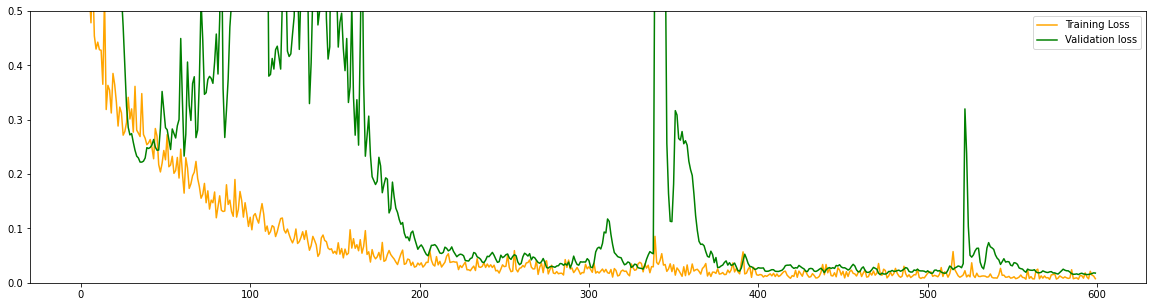

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

loss = np.array(history6.history['loss'])
var_loss = np.array(history6.history['val_loss'])
ax.plot(20*np.log(1+loss), 'orange', label='Training Loss')
ax.plot(20*np.log(1+var_loss), 'green', label='Validation loss')
ax.set_ylim([0, 0.5])
ax.legend()
fig.show()

Text(0.5, 1.0, 'SCATTER Fraction (Reference)')

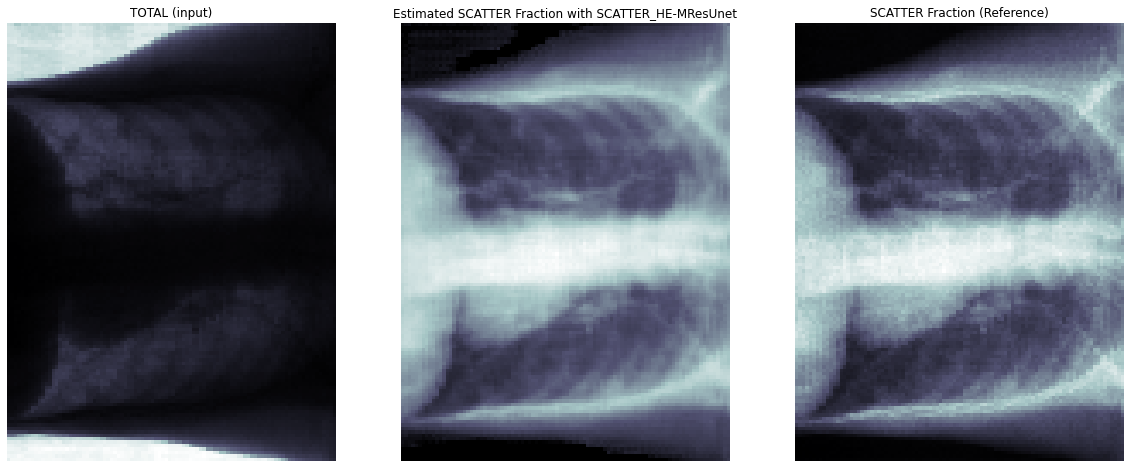

In [ ]:
img_index = 15 #54
test = tf.concat([x_val_tf_HE,y_val_tf_HE,x_val_tf_HE*y_val_tf_HE],-1)
test = np.expand_dims(test[img_index,:,:,:],axis=0)
estim = mresunet.predict(test)
TOT_img = np.squeeze(test[0,:,:,0]) #CT_img = np.squeeze(test)
ESTIM_img = np.squeeze(estim)
SCAT_img = np.squeeze(y_val_tf_HE[img_index,:,:,0]) #DOSE_img = np.squeeze(y_val_tf[img_index,:,:,:])

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.imshow(TOT_img,cmap=plt.cm.bone) #plt.imshow(np.concatenate((TOT_img[:,:,0],TOT_img[:,:,1]),axis=0),cmap=plt.cm.bone) #plt.imshow(CT_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('TOTAL (input)') #plt.title('CT (Input)')

plt.subplot(1,3,2)
plt.imshow(ESTIM_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Estimated SCATTER Fraction with SCATTER_HE-MResUnet') #plt.title('Estimated DOSE with CT2DOSE')

plt.subplot(1,3,3)
plt.imshow(SCAT_img,cmap=plt.cm.bone) #plt.imshow(DOSE_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('SCATTER Fraction (Reference)') #plt.title('DOSE (Reference)')

Text(0.5, 1.0, 'SCATTER (Reference)')

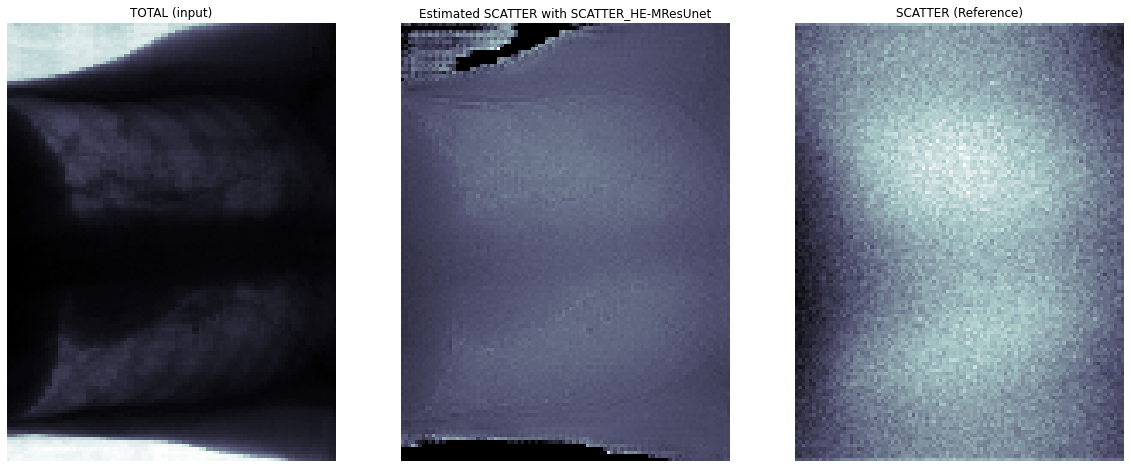

In [ ]:
Scatter = ESTIM_img*TOT_img
Scatter_ref = SCAT_img*TOT_img

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.imshow(TOT_img,cmap=plt.cm.bone) #plt.imshow(np.concatenate((TOT_img[:,:,0],TOT_img[:,:,1]),axis=0),cmap=plt.cm.bone) #plt.imshow(CT_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('TOTAL (input)') #plt.title('CT (Input)')

plt.subplot(1,3,2)
plt.imshow(Scatter, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Estimated SCATTER with SCATTER_HE-MResUnet') #plt.title('Estimated DOSE with CT2DOSE')

plt.subplot(1,3,3)
plt.imshow(Scatter_ref,cmap=plt.cm.bone) #plt.imshow(DOSE_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('SCATTER (Reference)') #plt.title('DOSE (Reference)')

In [ ]:
loss = np.array(history6.history['loss'])
var_loss = np.array(history6.history['val_loss'])
loss_info = np.transpose(100*np.array([loss,var_loss]))
np.savetxt( "drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/LOSSINFO_HE600Cut_MRU_FracScatterTotal_NoRot_addloss_lambda03.csv", loss_info, fmt='%.3f', delimiter='\t')
np.savetxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/loss_HE600Cut_MRU_FracScatterTotal_NoRot_addloss_lambda03.csv',loss)
np.savetxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/Varloss_HE600Cut_MRU_FracScatterTotal_NoRot_addloss_lambda03.csv',var_loss)

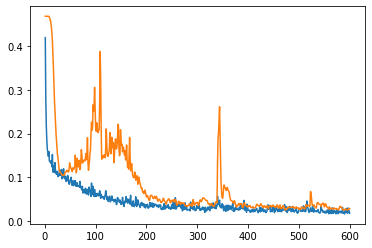

In [ ]:
MAE_train = np.array(history6.history['metric_MAE'])
MAE_val = np.array(history6.history['val_metric_MAE'])

plt.plot(np.arange(1,601),MAE_train)
plt.plot(np.arange(1,601),MAE_val)

In [ ]:
np.savetxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/MSE_val_HE600Cut_MRU_FracScatterTotal_NoRot_addloss_lambda03.csv',MAE_train)
np.savetxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/MSE_val_HE600Cut_MRU_FracScatterTotal_NoRot_addloss_lambda03.csv',MAE_val)

In [ ]:
# Save the entire model as a HDF5 file.
mresunet.save('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/SCATTER_HE600Cut_MRU_FracScatterTotal_NoRot_addloss_lambda03.h5')

# NEURAL NETWORK: MultiResUnet - Dual Energy

## Select Dual Energy Data

### Imágenes sin recortar VIEJAS

In [ ]:
# 2 channels in input and output
x_train_dual = np.zeros((70,128,128,2))
x_val_dual = np.zeros((30,128,128,2))
y_train_dual = np.zeros((70,128,128,1)) #Output solo una energía (HE)
y_val_dual = np.zeros((30,128,128,1))

x_train_dual[:,:,:,0] = np.squeeze(x_train[:,0:128,:,:])
x_train_dual[:,:,:,1] = np.squeeze(x_train[:,128:256,:,:])
x_val_dual[:,:,:,0] = np.squeeze(x_val[:,0:128,:,:])
x_val_dual[:,:,:,1] = np.squeeze(x_val[:,128:256,:,:])
y_train_dual[:,:,:,0] = np.squeeze(y_train[:,128:256,:,:]) #Output solo HE
#y_train_dual[:,:,:,1] = np.squeeze(y_train[:,128:256,:,:])
y_val_dual[:,:,:,0] = np.squeeze(y_val[:,128:256,:,:]) #Output solo HE
#y_val_dual[:,:,:,1] = np.squeeze(y_val[:,128:256,:,:])

x_train_tf_dual = tf.convert_to_tensor(x_train_dual, tf.float32)
x_val_tf_dual = tf.convert_to_tensor(x_val_dual, tf.float32)
y_train_tf_dual = tf.convert_to_tensor(y_train_dual, tf.float32)
y_val_tf_dual = tf.convert_to_tensor(y_val_dual, tf.float32)

NameError: ignored

### Imágenes recortadas VIEJAS

In [ ]:
# PARA IMÁGENES RECORTADAS
# 2 channels in input and 1 channel in output
x_train_dual = np.zeros((67,128,96,2))
x_val_dual = np.zeros((29,128,96,2))
y_train_dual = np.zeros((67,128,96,1)) #Output solo una energía (HE)
y_val_dual = np.zeros((29,128,96,1))

x_train_dual[:,:,:,0] = np.squeeze(x_train[:,0:128,:,:])
x_train_dual[:,:,:,1] = np.squeeze(x_train[:,128:256,:,:])
x_val_dual[:,:,:,0] = np.squeeze(x_val[:,0:128,:,:])
x_val_dual[:,:,:,1] = np.squeeze(x_val[:,128:256,:,:])
y_train_dual[:,:,:,0] = np.squeeze(y_train[:,128:256,:,:]) #Output solo HE
#y_train_dual[:,:,:,1] = np.squeeze(y_train[:,128:256,:,:])
y_val_dual[:,:,:,0] = np.squeeze(y_val[:,128:256,:,:]) #Output solo HE
#y_val_dual[:,:,:,1] = np.squeeze(y_val[:,128:256,:,:])

x_train_tf_dual = tf.convert_to_tensor(x_train_dual, tf.float32)
x_val_tf_dual = tf.convert_to_tensor(x_val_dual, tf.float32)
y_train_tf_dual = tf.convert_to_tensor(y_train_dual, tf.float32)
y_val_tf_dual = tf.convert_to_tensor(y_val_dual, tf.float32)

In [ ]:
y_train_tf_dual.shape

TensorShape([67, 128, 96, 1])

### Imágenes NUEVAS

In [ ]:
x_train_dual = np.zeros((70,128,96,2))
x_val_dual = np.zeros((30,128,96,2))

x_train_dual[:,:,:,0] = x_train_LE[:,:,:,0]
x_train_dual[:,:,:,1] = x_train_HE[:,:,:,0]
x_val_dual[:,:,:,0] = x_val_LE[:,:,:,0]
x_val_dual[:,:,:,1] = x_val_HE[:,:,:,0]

x_train_tf_dual = tf.convert_to_tensor(x_train_dual, tf.float32)
x_val_tf_dual = tf.convert_to_tensor(x_val_dual, tf.float32)

In [ ]:
y_train_tf_dual = y_train_tf_HE
y_val_tf_dual = y_val_tf_HE

## Load Modules

In [ ]:
from keras_unet.models import custom_unet
from keras_unet.utils import get_augmented

## Data Augmentation

In [ ]:
#train_gen = get_augmented(x_train_tf_dual, y_train_tf_dual, batch_size=24,
#    data_gen_args = dict(width_shift_range=0.3,height_shift_range=0.3,rotation_range=90.0,
#        horizontal_flip=True,vertical_flip=True,fill_mode='nearest'))

train_gen = get_augmented(x_train_tf_dual[0:64,:,:,:], y_train_tf_dual[0:64,:,:,:], batch_size=16,
    data_gen_args = dict(width_shift_range=0.0,height_shift_range=0.0,rotation_range=0.0,
        horizontal_flip=True,vertical_flip=True,fill_mode='nearest', zoom_range=[0.5,1]))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (64, 128, 96, 2) (2 channels).
  ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (64, 128, 96, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


IndexError: ignored

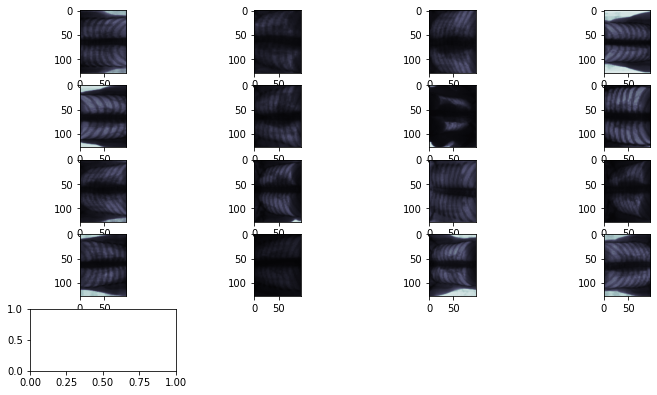

In [ ]:
xnew =[]
plt.figure(figsize=(12,8))
i=0
for xnew, ynew in train_gen:
  plt.subplot(6,4,i+1)
  plt.imshow(np.squeeze(xnew[i,:,:,0]),cmap=plt.cm.bone,vmin=0,vmax=1.075)
  i=i+1
  #plt.imshow(np.squeeze(ynew[i,:,:]),cmap=plt.cm.bone)

## MultiResUnet Architecture

#### Original

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
#from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model



def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False,kernel_initializer="he_normal")(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x
    x = Activation(activation, name=name)(x)
    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corresponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp
    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')
    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')
    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')
    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)
    return out


def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')
    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)
    return out


def MultiResUnet(height, width, n_channels,filters):
    '''
    MultiResUNet

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(filters, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(filters, 4, mresblock1)

    mresblock2 = MultiResBlock(filters*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(filters*2, 3, mresblock2)

    mresblock3 = MultiResBlock(filters*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(filters*4, 2, mresblock3)

    mresblock4 = MultiResBlock(filters*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(filters*8, 1, mresblock4)

    mresblock5 = MultiResBlock(filters*16, pool4)

    # ORIGINAL
    up6 = concatenate([Conv2DTranspose(
       filters*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(filters*8, up6)

    up7 = concatenate([Conv2DTranspose(
       filters*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(filters*4, up7)

    up8 = concatenate([Conv2DTranspose(
       filters*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(filters*2, up8)

    up9 = concatenate([Conv2DTranspose(filters, (2, 2), strides=(
       2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(filters, up9)

    # PRUEBA SIN CONCATENAR
    # up6 = Conv2DTranspose(filters*8, (2, 2), strides=(2, 2), padding='same')(mresblock5)
    # mresblock6 = MultiResBlock(filters*8, up6)

    # up7 = Conv2DTranspose(filters*4, (2, 2), strides=(2, 2), padding='same')(mresblock6)
    # mresblock7 = MultiResBlock(filters*4, up7)

    # up8 = Conv2DTranspose(filters*2, (2, 2), strides=(2, 2), padding='same')(mresblock7)
    # mresblock8 = MultiResBlock(filters*2, up8)

    # up9 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(mresblock8)
    # mresblock9 = MultiResBlock(filters, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='relu') #Para que el output tenga 2 channels hay que poner filters=2 (segundo parametro del input de conv2d_bn; primero de Conv2D)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

#### Loss function dentro del modelo

https://localcoder.org/keras-custom-loss-function-accessing-current-input-pattern

In [ ]:
# ARQUITECTURA CON LOSS FUNCTION DENTRO DEL MODELO
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
#from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model



def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding,use_bias=False,kernel_initializer="he_normal")(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x
    x = Activation(activation, name=name)(x)
    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corresponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp
    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')
    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')
    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')
    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)
    return out


def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')
    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)
    return out


def MultiResUnet(height, width, n_channels,filters):
    '''
    MultiResUNet

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))
    #inputs_T = Input((height, width, n_channels))
    #inputs_SF = Input((height, width, n_channels))  #CFE: prueba para añadir loss function en el modelo
    inputs_T_LE = tf.expand_dims(inputs[:,:,:,0],-1)
    inputs_T_HE = tf.expand_dims(inputs[:,:,:,1],-1)
    inputs_SF = tf.expand_dims(inputs[:,:,:,2],-1)

    mresblock1 = MultiResBlock(filters, inputs[:,:,:,0:2])
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(filters, 4, mresblock1)

    mresblock2 = MultiResBlock(filters*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(filters*2, 3, mresblock2)

    mresblock3 = MultiResBlock(filters*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(filters*4, 2, mresblock3)

    mresblock4 = MultiResBlock(filters*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(filters*8, 1, mresblock4)

    mresblock5 = MultiResBlock(filters*16, pool4)

    print(inputs[:,:,:,0:2].shape)
    print(mresblock1.shape)
    print(mresblock2.shape)
    print(mresblock3.shape)
    print(mresblock4.shape)
    print(mresblock5.shape)
    # ORIGINAL
    up6 = concatenate([Conv2DTranspose(
       filters*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(filters*8, up6)

    up7 = concatenate([Conv2DTranspose(
       filters*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(filters*4, up7)

    up8 = concatenate([Conv2DTranspose(
       filters*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(filters*2, up8)

    up9 = concatenate([Conv2DTranspose(filters, (2, 2), strides=(
       2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(filters, up9)

    # PRUEBA SIN CONCATENAR
    # up6 = Conv2DTranspose(filters*8, (2, 2), strides=(2, 2), padding='same')(mresblock5)
    # mresblock6 = MultiResBlock(filters*8, up6)

    # up7 = Conv2DTranspose(filters*4, (2, 2), strides=(2, 2), padding='same')(mresblock6)
    # mresblock7 = MultiResBlock(filters*4, up7)

    # up8 = Conv2DTranspose(filters*2, (2, 2), strides=(2, 2), padding='same')(mresblock7)
    # mresblock8 = MultiResBlock(filters*2, up8)

    # up9 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(mresblock8)
    # mresblock9 = MultiResBlock(filters, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='relu')
    estim_SF = conv10

    #model = Model(inputs=[inputs_T,inputs_SF], outputs=[conv10])
    model = Model(inputs=inputs, outputs=estim_SF)

    # Construct your custom loss as a tensor And Compile without specifying a loss
    #loss = K.mean(K.square(inputs_SF*inputs_T - conv10*inputs_T))  #MSE
    #loss = K.mean(K.abs(inputs_SF*inputs_T - conv10*inputs_T))  #MAE
    landa = 0.3
    loss = landa*K.mean(K.square(inputs_SF*inputs_T_HE - estim_SF*inputs_T_HE))+(1-landa)*K.mean(K.square(inputs_SF - estim_SF))  #MSE (mezcla scatter fraction y scatter)
    #loss = K.mean(K.square(inputs_SF - estim_SF))  #MSE (solo scatter fraction)
    ## Add loss to model
    model.add_loss(loss)

    # Add metric to model
    #self.add_metric(tf.reduce_sum(inputs), name='mean_activation')
    metric = K.mean(K.abs(inputs_SF - estim_SF))  #MAE
    model.add_metric(metric,name='metric_MAE')

    return model

## Model Definition

In [ ]:
#Run this for MultiResUnet Network
filters=64
channels=3 #2
mresunet=MultiResUnet(x_train_tf_dual.shape[1],x_train_tf_dual.shape[2],channels,filters)  #MultiResUnet(Ny,Nx,channels,filters)

(None, 128, 96, 2)
(None, 128, 96, 64)
(None, 64, 48, 128)
(None, 32, 24, 256)
(None, 16, 12, 512)
(None, 8, 6, 1709)


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
#mresunet.compile(optimizer=opt, loss='MeanSquaredError')   #l1 NORM #MeanSquaredError #MeanAbsoluteError #mean_squared_logarithmic_error #root_mean_squared_error
mresunet.compile(optimizer=opt)   #l1 NORM #MeanSquaredError #MeanAbsoluteError #mean_squared_logarithmic_error #root_mean_squared_error
#checkpoint6 = ModelCheckpoint(filepath=model_dir + 'multires_needle-spine.h5', monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False, mode ='auto', save_frequency=1)

## Run Training

In [ ]:
xx = tf.concat([x_train_tf_LE,x_train_tf_HE,y_train_tf_HE],-1)
print(xx.shape)

(70, 128, 96, 3)


In [ ]:
def get_augmented_3channels(X_train, batch_size=32):
    X_datagen = ImageDataGenerator(rotation_range=0.0, width_shift_range=0.,
        height_shift_range=0.0, shear_range=0, zoom_range=[0.5,1],
        horizontal_flip=True, vertical_flip=True, fill_mode="nearest")
    X_datagen.fit(X_train, augment=True)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True)
    return X_train_augmented

In [ ]:
train_gen = get_augmented_3channels(xx)

In [ ]:
yy = tf.concat([x_val_tf_LE,x_val_tf_HE,y_val_tf_HE],-1)
print(yy.shape)

(30, 128, 96, 3)


In [ ]:
#history6 = mresunet.fit(train_gen,steps_per_epoch=10, epochs=400, validation_data=(x_val_tf_dual, y_val_tf_dual)) #,callbacks=[checkpoint6])
history6 = mresunet.fit(train_gen,y=None, epochs=600, validation_data=([yy],[]))  #,steps_per_epoch=10, epochs=400,) #,callbacks=[checkpoint6])

Epoch 1/600
3/3 [==============================] - 14s 2s/step - loss: 0.1145 - metric_MAE: 0.3398 - val_loss: 0.1945 - val_metric_MAE: 0.4683
Epoch 2/600
3/3 [==============================] - 4s 1s/step - loss: 0.0524 - metric_MAE: 0.2307 - val_loss: 0.1945 - val_metric_MAE: 0.4683
Epoch 3/600
3/3 [==============================] - 4s 1s/step - loss: 0.0322 - metric_MAE: 0.1729 - val_loss: 0.1945 - val_metric_MAE: 0.4683
Epoch 4/600
3/3 [==============================] - 4s 2s/step - loss: 0.0288 - metric_MAE: 0.1632 - val_loss: 0.1945 - val_metric_MAE: 0.4683
Epoch 5/600
3/3 [==============================] - 5s 2s/step - loss: 0.0249 - metric_MAE: 0.1502 - val_loss: 0.1945 - val_metric_MAE: 0.4683
Epoch 6/600
3/3 [==============================] - 4s 2s/step - loss: 0.0269 - metric_MAE: 0.1569 - val_loss: 0.1945 - val_metric_MAE: 0.4682
Epoch 7/600
3/3 [==============================] - 4s 2s/step - loss: 0.0285 - metric_MAE: 0.1572 - val_loss: 0.1943 - val_metric_MAE: 0.4680
Epoch

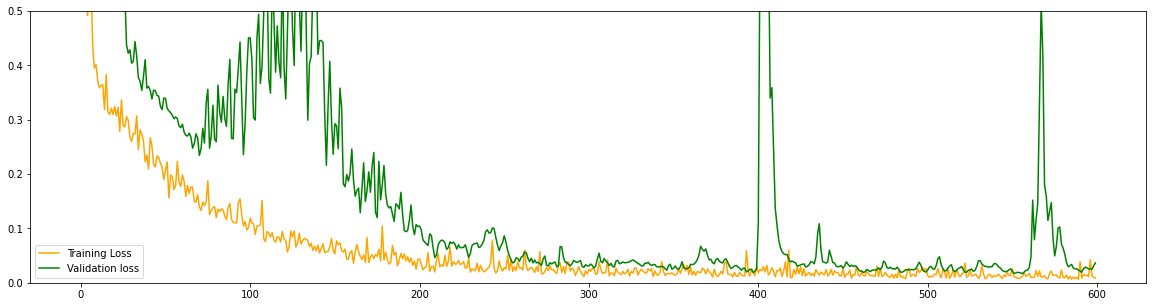

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

loss = np.array(history6.history['loss'])
var_loss = np.array(history6.history['val_loss'])
ax.plot(20*np.log(1+loss), 'orange', label='Training Loss')
ax.plot(20*np.log(1+var_loss), 'green', label='Validation loss')
ax.set_ylim([0, 0.5])
ax.legend()
fig.show()

In [ ]:
test = np.expand_dims(x_val_tf_dual[5,:,:,:],axis=0)
estim = mresunet.predict(test)
print(type(estim))
print(estim.shape)

<class 'numpy.ndarray'>
(1, 128, 96, 1)


Text(0.5, 1.0, 'SCATTER (Reference)')

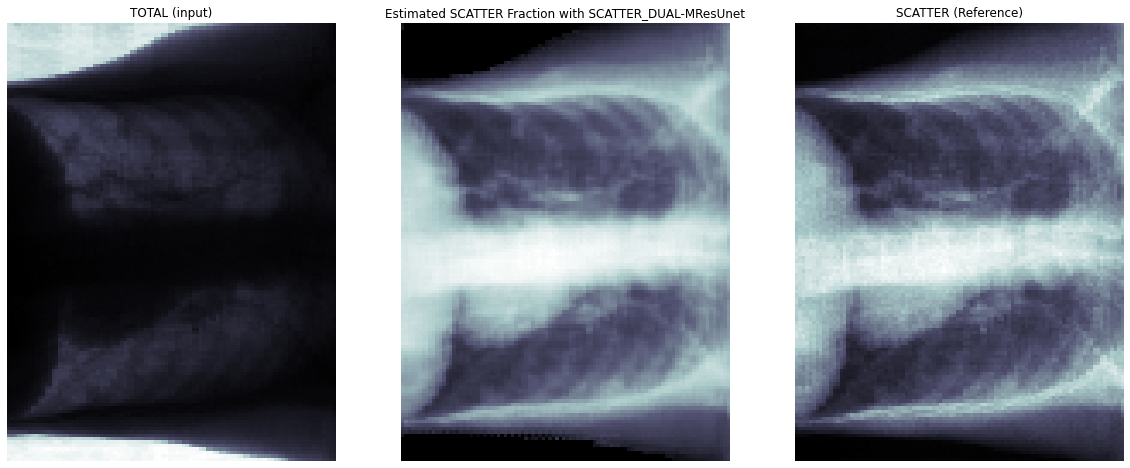

In [ ]:
img_index = 15 #54
test = tf.concat([x_val_tf_LE,x_val_tf_HE,y_val_tf_HE],-1)
test = np.expand_dims(test[img_index,:,:,:],axis=0)
#test = np.expand_dims(x_val_tf_dual[img_index,:,:,:],axis=0)
estim = mresunet.predict(test)
TOT_img = np.squeeze(test[0,:,:,1]) #CT_img = np.squeeze(test)
ESTIM_img = np.squeeze(estim)
SCAT_img = np.squeeze(y_val_tf_dual[img_index,:,:,:]) #DOSE_img = np.squeeze(y_val_tf[img_index,:,:,:])

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.imshow(TOT_img,cmap=plt.cm.bone) #plt.imshow(np.concatenate((TOT_img[:,:,0],TOT_img[:,:,1]),axis=0),cmap=plt.cm.bone) #plt.imshow(CT_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('TOTAL (input)') #plt.title('CT (Input)')

plt.subplot(1,3,2)
plt.imshow(ESTIM_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Estimated SCATTER Fraction with SCATTER_DUAL-MResUnet') #plt.title('Estimated DOSE with CT2DOSE')

plt.subplot(1,3,3)
plt.imshow(SCAT_img,cmap=plt.cm.bone) #plt.imshow(DOSE_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('SCATTER (Reference)') #plt.title('DOSE (Reference)')

Text(0.5, 1.0, 'SCATTER (Reference)')

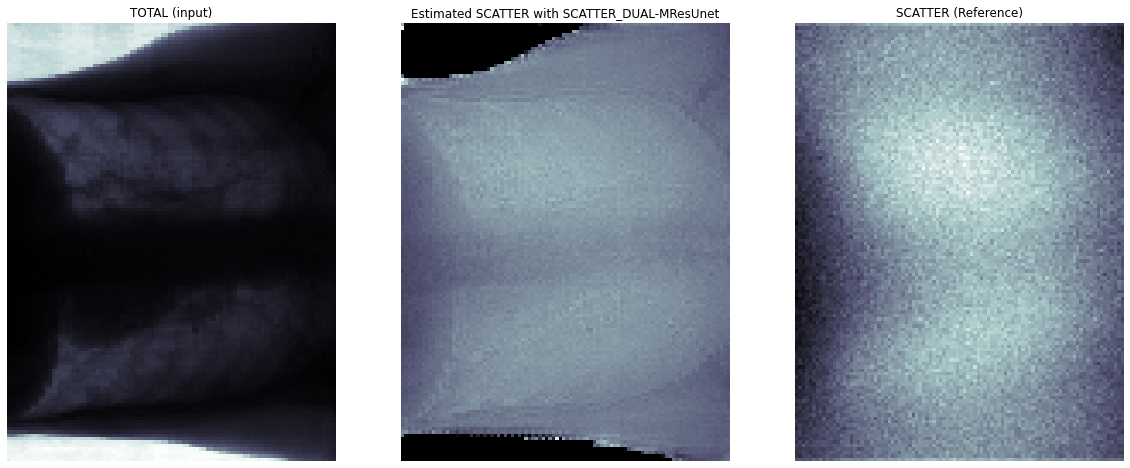

In [ ]:
Scatter = ESTIM_img*TOT_img #[:,:,1]
Scatter_ref = SCAT_img*TOT_img #[:,:,1]

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.imshow(TOT_img,cmap=plt.cm.bone) #plt.imshow(np.concatenate((TOT_img[:,:,0],TOT_img[:,:,1]),axis=0),cmap=plt.cm.bone) #plt.imshow(CT_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('TOTAL (input)') #plt.title('CT (Input)')

plt.subplot(1,3,2)
plt.imshow(Scatter, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Estimated SCATTER with SCATTER_DUAL-MResUnet') #plt.title('Estimated DOSE with CT2DOSE')

plt.subplot(1,3,3)
plt.imshow(Scatter_ref,cmap=plt.cm.bone) #plt.imshow(DOSE_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('SCATTER (Reference)') #plt.title('DOSE (Reference)')

In [ ]:
loss = np.array(history6.history['loss'])
var_loss = np.array(history6.history['val_loss'])
loss_info = np.transpose(100*np.array([loss,var_loss]))
np.savetxt( "drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/LOSSINFO_DUAL600Cut_MRU21chHE_FracScatterTotal_NoRot_addloss_lambda03.csv", loss_info, fmt='%.3f', delimiter='\t')
np.savetxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/loss_DUAL600Cut_MRU21chHE_FracScatterTotal_NoRot_addloss_lambda03.csv',loss)
np.savetxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/Varloss_DUAL600Cut_MRU21chHE_FracScatterTotal_NoRot_addloss_lambda03.csv',var_loss)

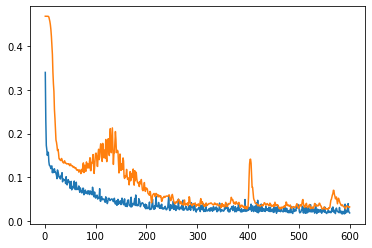

In [ ]:
MAE_train = np.array(history6.history['metric_MAE'])
MAE_val = np.array(history6.history['val_metric_MAE'])

plt.plot(np.arange(1,601),MAE_train)
plt.plot(np.arange(1,601),MAE_val)

In [ ]:
np.savetxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/MSE_val_DUAL600Cut_MRU21chHE_FracScatterTotal_NoRot_addloss_lambda03.csv',MAE_train)
np.savetxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/MSE_val_DUAL600Cut_MRU21chHE_FracScatterTotal_NoRot_addloss_lambda03.csv',MAE_val)

In [ ]:
# Save the entire model as a HDF5 file.
mresunet.save('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/SCATTER_DUAL600Cut_MRU21chHE_FracScatterTotal_NoRot_addloss_lambda03.h5')

# Spectra

## Load .dat files

In [ ]:
E60 = np.loadtxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/Espectros/60Kev.dat')
E130 = np.loadtxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/Espectros/130Kev.dat')
w60 = esp60 = np.loadtxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/Espectros/pesos60Kev.dat')
w130 = np.loadtxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/Espectros/pesos130.dat')

# ANALYSIS OF ESTIMATED AND CORRECTED SCATTER

## Load Trained Models

In [ ]:
model_HE = tf.keras.models.load_model('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/SCATTER_HE600Cut_MRU_FracScatterTotal_NoRot_addloss_SF.h5',compile=False)
model_DUAL = tf.keras.models.load_model('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/SCATTER_DUAL600Cut_MRU21chHE_FracScatterTotal_NoRot_addloss_SF.h5',compile=False)

## Load Reference Scatter, No-Scatter & Total Projection





### DATOS NUEVOS

In [ ]:
# Pandas DataFrame
total_HE = pd.read_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_T_5e9.csv')
scat_ref_HE = pd.read_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_S_5e9.csv')
noscat_ref_HE = pd.read_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_NS_5e9.csv')
total_LE = pd.read_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_T_5e9.csv')
scat_ref_LE = pd.read_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_S_5e9.csv')
noscat_ref_LE = pd.read_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_NS_5e9.csv')

# Pandas DataFrame --> Numpy Array
total_HE = total_HE.to_numpy()
scat_ref_HE = scat_ref_HE.to_numpy()
noscat_ref_HE = noscat_ref_HE.to_numpy()
total_LE = total_LE.to_numpy()
scat_ref_LE = scat_ref_LE.to_numpy()
noscat_ref_LE = noscat_ref_LE.to_numpy()

# Remove extra column
total_HE = total_HE[:,1:129]
scat_ref_HE = scat_ref_HE[:,1:129]
noscat_ref_HE = noscat_ref_HE[:,1:129]
total_LE = total_LE[:,1:129]
scat_ref_LE = scat_ref_LE[:,1:129]
noscat_ref_LE = noscat_ref_LE[:,1:129]

# Reshape first dimension
total_HE = total_HE.reshape((130,128,128))
scat_ref_HE = scat_ref_HE.reshape((130,128,128))
noscat_ref_HE = noscat_ref_HE.reshape((130,128,128))
total_LE = total_LE.reshape((130,128,128))
scat_ref_LE = scat_ref_LE.reshape((130,128,128))
noscat_ref_LE = noscat_ref_LE.reshape((130,128,128))

total_HE = np.expand_dims(total_HE,axis=-1)
scat_ref_HE = np.expand_dims(scat_ref_HE,axis=-1)
noscat_ref_HE = np.expand_dims(noscat_ref_HE,axis=-1)
total_LE = np.expand_dims(total_LE,axis=-1)
scat_ref_LE = np.expand_dims(scat_ref_LE,axis=-1)
noscat_ref_LE = np.expand_dims(noscat_ref_LE,axis=-1)

total_HE = tf.convert_to_tensor(total_HE, tf.float32)
scat_ref_HE = tf.convert_to_tensor(scat_ref_HE, tf.float32)
noscat_ref_HE = tf.convert_to_tensor(noscat_ref_HE, tf.float32)
total_LE = tf.convert_to_tensor(total_LE, tf.float32)
scat_ref_LE = tf.convert_to_tensor(scat_ref_LE, tf.float32)
noscat_ref_LE = tf.convert_to_tensor(noscat_ref_LE, tf.float32)

Nx2 = 128 #256
Ny2 = 128

total_HE = tf.image.resize(total_HE,[Nx2,Ny2],method='bilinear')
scat_ref_HE = tf.image.resize(scat_ref_HE,[Nx2,Ny2],method='bilinear')
noscat_ref_HE = tf.image.resize(noscat_ref_HE,[Nx2,Ny2],method='bilinear')
total_LE = tf.image.resize(total_LE,[Nx2,Ny2],method='bilinear')
scat_ref_LE = tf.image.resize(scat_ref_LE,[Nx2,Ny2],method='bilinear')
noscat_ref_LE = tf.image.resize(noscat_ref_LE,[Nx2,Ny2],method='bilinear')

total_HE = total_HE.numpy()
scat_ref_HE = scat_ref_HE.numpy()
noscat_ref_HE = noscat_ref_HE.numpy()
total_LE = total_LE.numpy()
scat_ref_LE = scat_ref_LE.numpy()
noscat_ref_LE = noscat_ref_LE.numpy()

print(total_HE.shape)

(130, 128, 128, 1)


## Recortar Imágenes

### DATOS NUEVOS

In [ ]:
scat_ref_HE = scat_ref_HE[:,:,16:112,:]
total_HE = total_HE[:,:,16:112,:]
noscat_ref_HE = noscat_ref_HE[:,:,16:112,:]

scat_ref_LE = scat_ref_LE[:,:,16:112,:]
total_LE = total_LE[:,:,16:112,:]
noscat_ref_LE = noscat_ref_LE[:,:,16:112,:]

print(scat_ref_HE.shape)

(130, 128, 96, 1)


In [ ]:
scat_ref_HE = np.delete(scat_ref_HE,[2,23,48,72,103,111,115,119],axis=0)
total_HE = np.delete(total_HE,[2,23,48,72,103,111,115,119],axis=0)
noscat_ref_HE = np.delete(noscat_ref_HE,[2,23,48,72,103,111,115,119],axis=0)

scat_ref_LE = np.delete(scat_ref_LE,[2,23,48,72,103,111,115,119],axis=0)
total_LE = np.delete(total_LE,[2,23,48,72,103,111,115,119],axis=0)
noscat_ref_LE = np.delete(noscat_ref_LE,[2,23,48,72,103,111,115,119],axis=0)

print(scat_ref_HE.shape)

(122, 128, 96, 1)


In [ ]:
total_dual = np.zeros((122,128,96,2))
total_dual[:,:,:,0] = total_LE[:,:,:,0]
total_dual[:,:,:,1] = total_HE[:,:,:,0]

### Figuras de ejemplo para ppt

(-0.5, 127.5, 95.5, -0.5)

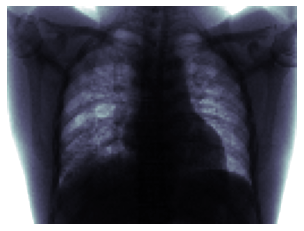

In [ ]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(noscat_ref_HE[0,:,:,0])),cmap=plt.cm.bone,vmin=0,vmax=0.2)
plt.axis('off')

(-0.5, 127.5, 95.5, -0.5)

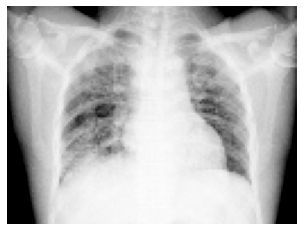

In [ ]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(noscat_ref_HE[0,:,:,0])),cmap='binary',vmin=0,vmax=0.15)
plt.axis('off')

(-0.5, 127.5, 95.5, -0.5)

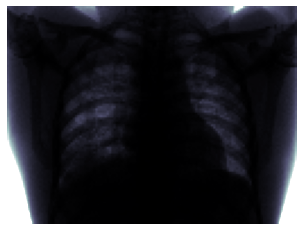

In [ ]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(noscat_ref_LE[0,:,:,0])),cmap=plt.cm.bone,vmin=0,vmax=0.2)
plt.axis('off')

(-0.5, 127.5, 95.5, -0.5)

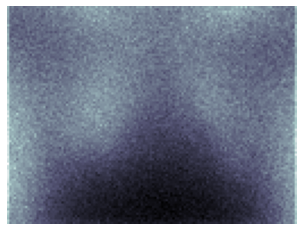

In [ ]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(scat_ref_LE[0,:,:,0])),cmap=plt.cm.bone)
plt.axis('off')

## Scatter and No-Scatter Estimation; Error

### Scatter/Total Output NN

#### Imágenes recortadas - BIEN - MODEL ADD LOSS

In [ ]:
#test = tf.concat([x_val_tf_HE,y_val_tf_HE,x_val_tf_HE*y_val_tf_HE],-1)
input_HE = np.concatenate([total_HE,total_HE/scat_ref_HE,scat_ref_HE],-1)
#test = np.expand_dims(test[img_index,:,:,:],axis=0)
#test = tf.concat([x_val_tf_LE,x_val_tf_HE,y_val_tf_HE],-1)
input_DUAL = np.concatenate([total_LE,total_HE,scat_ref_HE/total_HE],-1)
print(input_HE.shape)
print(type(input_HE))

(122, 128, 96, 3)
<class 'numpy.ndarray'>


In [ ]:
# PARA IMÁGENES RECORTADAS
S_REF_HE = np.zeros((122,128,96))
NS_REF_HE = np.zeros((122,128,96))
ST_ESTIM_HE = np.zeros((122,128,96))
ST_ESTIM_DUAL_HE = np.zeros((122,128,96))
S_ESTIM_HE = np.zeros((122,128,96))
S_ESTIM_DUAL_HE = np.zeros((122,128,96))
NS_ESTIM_HE = np.zeros((122,128,96))
NS_ESTIM_DUAL_HE = np.zeros((122,128,96))
DIF_HE_rel = np.zeros((122,128,96))
DIF_DUAL_HE_rel = np.zeros((122,128,96))
DIF_HE_NSrel = np.zeros((122,128,96))
DIF_DUAL_HE_NSrel = np.zeros((122,128,96))

MAPE_S_HE = np.zeros((122,1))
MAPE_S_DUAL = np.zeros((122,1))
MAPE_NS_HE = np.zeros((122,1))
MAPE_NS_DUAL = np.zeros((122,1))

SSIM_S_HE0 = np.zeros((122,1))
SSIM_S_DUAL0 = np.zeros((122,1))
SSIM_NS_HE0 = np.zeros((122,1))
SSIM_NS_DUAL0 = np.zeros((122,1))

SSIM_S_HE1 = np.zeros((122,128,96))
SSIM_S_DUAL1 = np.zeros((122,128,96))
SSIM_NS_HE1 = np.zeros((122,128,96))
SSIM_NS_DUAL1 = np.zeros((122,128,96))

SSIM_S_HE2 = np.zeros((122,128,96))
SSIM_S_DUAL2 = np.zeros((122,128,96))
SSIM_NS_HE2 = np.zeros((122,128,96))
SSIM_NS_DUAL2 = np.zeros((122,128,96))

MSE_S_HE = np.zeros((122,1))
MSE_S_DUAL = np.zeros((122,1))
MSE_NS_HE = np.zeros((122,1))
MSE_NS_DUAL = np.zeros((122,1))

for idx in range(122):

  test_HE = np.expand_dims(input_HE[idx,:,:,:],axis=0)
  estim_HE = model_HE.predict(test_HE)
  #TOT_LE = np.squeeze(test_LE)
  ST_ESTIM_HE[idx,:,:] = np.squeeze(estim_HE)
  S_ESTIM_HE[idx,:,:] = ST_ESTIM_HE[idx,:,:]*np.squeeze(total_HE[idx,:,:,:])
  NS_ESTIM_HE[idx,:,:] = np.squeeze(total_HE[idx,:,:,:])-S_ESTIM_HE[idx,:,:]
  #S_ESTIM_HE[idx,:,:] = np.where(S_ESTIM_HE[idx,:,:] < 0,0,S_ESTIM_HE[idx,:,:])
  S_REF_HE[idx,:,:] = np.squeeze(scat_ref_HE[idx,:,:,:])
  NS_REF_HE[idx,:,:] = np.squeeze(noscat_ref_HE[idx,:,:,:])
  #DIF_HE_abs = abs(S_REF_HE-S_ESTIM_HE[idx,:,:])
  DIF_HE_rel[idx,:,:] = abs(S_REF_HE[idx,:,:]-S_ESTIM_HE[idx,:,:])/(S_REF_HE[idx,:,:]+S_ESTIM_HE[idx,:,:])
  DIF_HE_NSrel[idx,:,:] = abs(NS_REF_HE[idx,:,:]-NS_ESTIM_HE[idx,:,:])/(NS_REF_HE[idx,:,:]+NS_ESTIM_HE[idx,:,:])
  MAPE_S_HE[idx,:] = mean_absolute_percentage_error(S_REF_HE[idx,:,:],S_ESTIM_HE[idx,:,:])
  MAPE_NS_HE[idx,:] = mean_absolute_percentage_error(NS_REF_HE[idx,:,:],NS_ESTIM_HE[idx,:,:])
  MSE_S_HE[idx,:] = mean_squared_error(S_REF_HE[idx,:,:],S_ESTIM_HE[idx,:,:])
  MSE_NS_HE[idx,:] = mean_squared_error(NS_REF_HE[idx,:,:],NS_ESTIM_HE[idx,:,:])
  SSIM_S_single = ssim(S_REF_HE[idx,:,:],S_ESTIM_HE[idx,:,:],gradient=True,full=True)
  SSIM_NS_single = ssim(NS_REF_HE[idx,:,:],NS_ESTIM_HE[idx,:,:],gradient=True,full=True)
  SSIM_S_HE0[idx,:] = SSIM_S_single[0]
  SSIM_NS_HE0[idx,:] = SSIM_NS_single[0]
  SSIM_S_HE1[idx,:,:] = SSIM_S_single[1]
  SSIM_NS_HE1[idx,:,:] = SSIM_NS_single[1]
  SSIM_S_HE2[idx,:,:] = SSIM_S_single[2]
  SSIM_NS_HE2[idx,:,:] = SSIM_NS_single[2]

  test_DUAL = np.expand_dims(input_DUAL[idx,:,:,:],axis=0) #np.expand_dims(x_val_DUAL_2chn[idx,:,1:129,:],axis=0)
  estim_DUAL = model_DUAL.predict(test_DUAL)
  #TOT_DUAL = np.squeeze(test_DUAL)
  #ST_ESTIM_DUAL_LE[idx,:,:] = np.squeeze(estim_DUAL[:,:,:,0]) #np.squeeze(estim_DUAL)
  ST_ESTIM_DUAL_HE[idx,:,:] = np.squeeze(estim_DUAL[:,:,:,0]) #Para sólo un canal en el output // Si hay dos canales: estim_DUAL[:,:,:,1]
  #S_ESTIM_DUAL_LE[idx,:,:] = ST_ESTIM_DUAL_LE[idx,:,:]*np.squeeze(total[idx,0:128,:,:])
  S_ESTIM_DUAL_HE[idx,:,:] = ST_ESTIM_DUAL_HE[idx,:,:]*np.squeeze(total_HE[idx,:,:,:])
  #NS_ESTIM_DUAL_LE[idx,:,:] = np.squeeze(total[idx,0:128,:,:])-S_ESTIM_DUAL_LE[idx,:,:]
  NS_ESTIM_DUAL_HE[idx,:,:] = np.squeeze(total_HE[idx,:,:,:])-S_ESTIM_DUAL_HE[idx,:,:]
  ##S_ESTIM_DUAL_LE[idx,:,:] = np.where(S_ESTIM_DUAL_LE[idx,:,:] < 0,0,S_ESTIM_DUAL_LE[idx,:,:])
  ##S_ESTIM_DUAL_HE[idx,:,:] = np.where(S_ESTIM_DUAL_HE[idx,:,:] < 0,0,S_ESTIM_DUAL_HE[idx,:,:])
  #DIF_DUAL_LE_rel[idx,:,:] = abs(S_REF_LE[idx,:,:]-S_ESTIM_DUAL_LE[idx,:,:])/(S_REF_LE[idx,:,:]+S_ESTIM_DUAL_LE[idx,:,:])
  DIF_DUAL_HE_rel[idx,:,:] = abs(S_REF_HE[idx,:,:]-S_ESTIM_DUAL_HE[idx,:,:])/(S_REF_HE[idx,:,:]+S_ESTIM_DUAL_HE[idx,:,:])
  #DIF_DUAL_LE_NSrel[idx,:,:] = abs(NS_REF_LE[idx,:,:]-NS_ESTIM_DUAL_LE[idx,:,:])/(NS_REF_LE[idx,:,:]+NS_ESTIM_DUAL_LE[idx,:,:])
  DIF_DUAL_HE_NSrel[idx,:,:] = abs(NS_REF_HE[idx,:,:]-NS_ESTIM_DUAL_HE[idx,:,:])/(NS_REF_HE[idx,:,:]+NS_ESTIM_DUAL_HE[idx,:,:])
  MAPE_S_DUAL[idx,:] = mean_absolute_percentage_error(S_REF_HE[idx,:,:],S_ESTIM_DUAL_HE[idx,:,:])
  MAPE_NS_DUAL[idx,:] = mean_absolute_percentage_error(NS_REF_HE[idx,:,:],NS_ESTIM_DUAL_HE[idx,:,:])
  MSE_S_DUAL[idx,:] = mean_squared_error(S_REF_HE[idx,:,:],S_ESTIM_DUAL_HE[idx,:,:])
  MSE_NS_DUAL[idx,:] = mean_squared_error(NS_REF_HE[idx,:,:],NS_ESTIM_DUAL_HE[idx,:,:])
  SSIM_S_dual = ssim(S_REF_HE[idx,:,:],S_ESTIM_DUAL_HE[idx,:,:],gradient=True,full=True)
  SSIM_NS_dual = ssim(NS_REF_HE[idx,:,:],NS_ESTIM_DUAL_HE[idx,:,:],gradient=True,full=True)
  SSIM_S_DUAL0[idx,:] = SSIM_S_dual[0]
  SSIM_NS_DUAL0[idx,:] = SSIM_NS_dual[0]
  SSIM_S_DUAL1[idx,:,:] = SSIM_S_dual[1]
  SSIM_NS_DUAL1[idx,:,:] = SSIM_NS_dual[1]
  SSIM_S_DUAL2[idx,:,:] = SSIM_S_dual[2]
  SSIM_NS_DUAL2[idx,:,:] = SSIM_NS_dual[2]

  print('iteracion',idx)

iteracion 0
iteracion 1
iteracion 2
iteracion 3
iteracion 4
iteracion 5
iteracion 6
iteracion 7
iteracion 8
iteracion 9
iteracion 10
iteracion 11
iteracion 12
iteracion 13
iteracion 14
iteracion 15
iteracion 16
iteracion 17
iteracion 18
iteracion 19
iteracion 20
iteracion 21
iteracion 22
iteracion 23
iteracion 24
iteracion 25
iteracion 26
iteracion 27
iteracion 28
iteracion 29
iteracion 30
iteracion 31
iteracion 32
iteracion 33
iteracion 34
iteracion 35
iteracion 36
iteracion 37
iteracion 38
iteracion 39
iteracion 40
iteracion 41
iteracion 42
iteracion 43
iteracion 44
iteracion 45
iteracion 46
iteracion 47
iteracion 48
iteracion 49
iteracion 50
iteracion 51
iteracion 52
iteracion 53
iteracion 54
iteracion 55
iteracion 56
iteracion 57
iteracion 58
iteracion 59
iteracion 60
iteracion 61
iteracion 62
iteracion 63
iteracion 64
iteracion 65
iteracion 66
iteracion 67
iteracion 68
iteracion 69
iteracion 70
iteracion 71
iteracion 72
iteracion 73
iteracion 74
iteracion 75
iteracion 76
iteracion

#### Ejemplo figura scatter estimation (ppt)

(-0.5, 127.5, 95.5, -0.5)

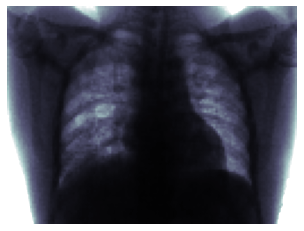

In [ ]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(NS_ESTIM_HE[0,:,:])),cmap=plt.cm.bone,vmin=0,vmax=0.2)
plt.axis('off')

(-0.5, 127.5, 95.5, -0.5)

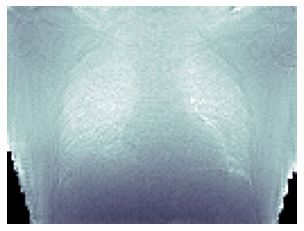

In [ ]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(S_ESTIM_HE[0,:,:])),cmap=plt.cm.bone,vmin=0,vmax=0.051)
plt.axis('off')

### NN Estimation - Only Test Images

In [ ]:
# PARA IMÁGENES RECORTADAS
Test_S_REF_HE = np.zeros((22,128,96))
Test_NS_REF_HE = np.zeros((22,128,96))
Test_ST_ESTIM_HE = np.zeros((22,128,96))
Test_ST_ESTIM_DUAL_HE = np.zeros((22,128,96))
Test_S_ESTIM_HE = np.zeros((22,128,96))
Test_S_ESTIM_DUAL_HE = np.zeros((22,128,96))
Test_NS_ESTIM_HE = np.zeros((22,128,96))
Test_NS_ESTIM_DUAL_HE = np.zeros((22,128,96))


for idx in range(0,22):

  test_HE = np.expand_dims(input_HE[idx+100,:,:,:],axis=0)
  estim_HE = model_HE.predict(test_HE)
  #TOT_LE = np.squeeze(test_LE)
  Test_ST_ESTIM_HE[idx,:,:] = np.squeeze(estim_HE)
  Test_S_ESTIM_HE[idx,:,:] = Test_ST_ESTIM_HE[idx,:,:]*np.squeeze(total_HE[idx+100,:,:,:])
  Test_NS_ESTIM_HE[idx,:,:] = np.squeeze(total_HE[idx+100,:,:,:])-Test_S_ESTIM_HE[idx,:,:]
  #S_ESTIM_HE[idx,:,:] = np.where(S_ESTIM_HE[idx,:,:] < 0,0,S_ESTIM_HE[idx,:,:])
  Test_S_REF_HE[idx,:,:] = np.squeeze(scat_ref_HE[idx+100,:,:,:])
  Test_NS_REF_HE[idx,:,:] = np.squeeze(noscat_ref_HE[idx+100,:,:,:])

  test_DUAL = np.expand_dims(input_DUAL[idx+100,:,:,:],axis=0) #np.expand_dims(x_val_DUAL_2chn[idx,:,1:129,:],axis=0)
  estim_DUAL = model_DUAL.predict(test_DUAL)
  Test_ST_ESTIM_DUAL_HE[idx,:,:] = np.squeeze(estim_DUAL[:,:,:,0]) #Para sólo un canal en el output // Si hay dos canales: estim_DUAL[:,:,:,1]
  Test_S_ESTIM_DUAL_HE[idx,:,:] = Test_ST_ESTIM_DUAL_HE[idx,:,:]*np.squeeze(total_HE[idx+100,:,:,:])
  Test_NS_ESTIM_DUAL_HE[idx,:,:] = np.squeeze(total_HE[idx+100,:,:,:])-Test_S_ESTIM_DUAL_HE[idx,:,:]

  print('iteracion',idx)

iteracion 0
iteracion 1
iteracion 2
iteracion 3
iteracion 4
iteracion 5
iteracion 6
iteracion 7
iteracion 8
iteracion 9
iteracion 10
iteracion 11
iteracion 12
iteracion 13
iteracion 14
iteracion 15
iteracion 16
iteracion 17
iteracion 18
iteracion 19
iteracion 20
iteracion 21


#### Figuras para ppt

(-0.5, 127.5, 95.5, -0.5)

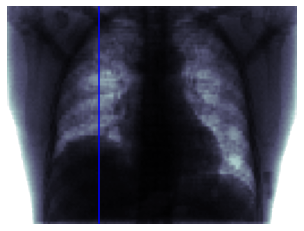

In [ ]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(Test_NS_REF_HE[21,:,:])),cmap=plt.cm.bone,vmin=0,vmax=0.2)
plt.plot([40,40],[0,95],'blue')
plt.axis('off')

(-0.5, 127.5, 95.5, -0.5)

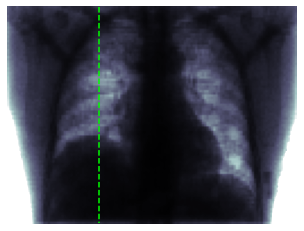

In [ ]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(Test_NS_ESTIM_HE[21,:,:])),cmap=plt.cm.bone,vmin=0,vmax=0.2)
plt.plot([40,40],[0,95],'lime',linestyle='--')
plt.axis('off')

(-0.5, 127.5, 95.5, -0.5)

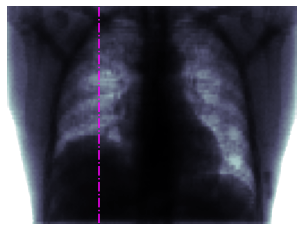

In [ ]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(Test_NS_ESTIM_DUAL_HE[21,:,:])),cmap=plt.cm.bone,vmin=0,vmax=0.2)
plt.plot([40,40],[0,95],'magenta',linestyle='-.')
plt.axis('off')

(array([-0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14]),
 <a list of 9 Text major ticklabel objects>)

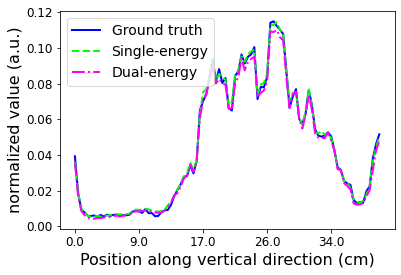

In [ ]:

plt.plot(Test_NS_REF_HE[21,40,:],'blue',linewidth=2)
plt.plot(Test_NS_ESTIM_HE[21,40,:],'lime',linestyle='--',linewidth=2)
plt.plot(Test_NS_ESTIM_DUAL_HE[21,40,:],'magenta',linestyle='-.',linewidth=2)
plt.legend(('Ground truth','Single-energy','Dual-energy'),fontsize=14)
plt.ylabel('normalized value (a.u.)',fontsize=16)
plt.xlabel('Position along vertical direction (cm)',fontsize=16)

xtc_loc = np.arange(0,96,20)
xtc_label = np.ndarray.astype(np.round(xtc_loc/2.34),str)
plt.xticks(xtc_loc,xtc_label,fontsize=12)
plt.yticks(fontsize=12)

## METRICS TEST IMAGES (100-122)

### Seleccionar ROI

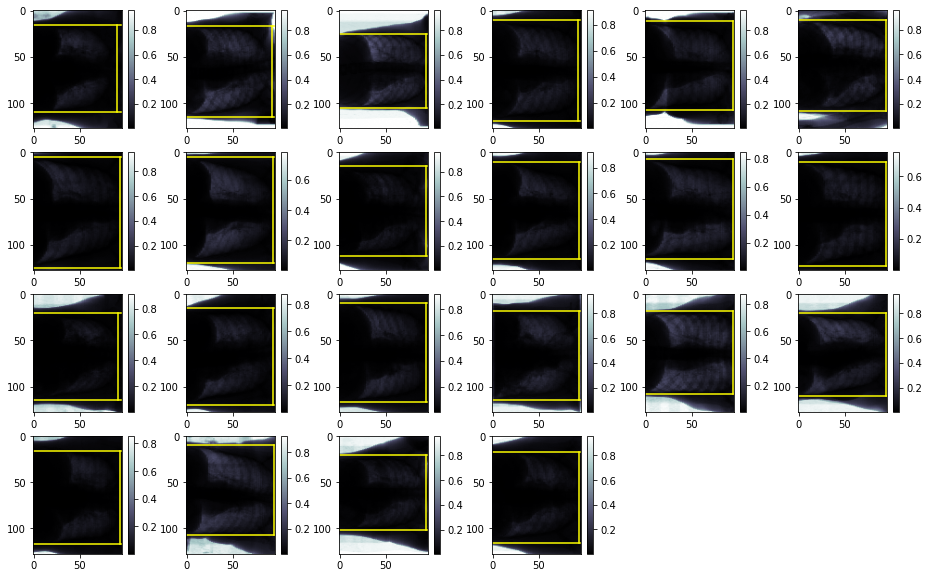

In [ ]:
lineah1 = [15,17,25,10,11,10,5,5,15,10,7,10,20,15,9,18,18,20,16,10,21,17]
lineah2 = [110,115,105,120,108,109,125,120,112,115,115,123,115,120,117,115,108,110,117,107,102,116]
lineav2 = [90,92,94,92,94,94,94,94,94,94,95,94,92,94,94,94,95,94,94,95,94,94]
plt.figure(figsize=(16,10))
for i in range(0,22):
   plt.subplot(4,6,i+1)
   plt.imshow(NS_REF_HE[i+100,:,:],cmap=plt.cm.bone)
   plt.plot([0, 95], [lineah1[i], lineah1[i]],'yellow',linestyle='-')
   plt.plot([0, 95], [lineah2[i], lineah2[i]],'yellow',linestyle='-')
   plt.plot([lineav2[i], lineav2[i]], [lineah1[i], lineah2[i]],'yellow',linestyle='-')
   plt.colorbar()

### Metrics in ROI (removing edges)

In [ ]:
# PARA IMÁGENES RECORTADAS + ROI
lineah1 = [15,17,25,10,11,10,5,5,15,10,7,10,20,15,9,18,18,20,16,10,21,17]
lineah2 = [110,115,105,120,108,109,125,120,112,115,115,123,115,120,117,115,108,110,117,107,102,116]
lineav2 = [90,92,94,92,94,94,94,94,94,94,95,94,92,94,94,94,95,94,94,95,94,94]

Test_DIF_HE_rel_ROI = np.zeros((22,1))
Test_DIF_DUAL_HE_rel_ROI = np.zeros((22,1))
Test_DIF_HE_NSrel_ROI = np.zeros((22,1))
Test_DIF_DUAL_HE_NSrel_ROI = np.zeros((22,1))

Test_MAPE_S_HE_ROI = np.zeros((22,1))
Test_MAPE_S_DUAL_ROI = np.zeros((22,1))
Test_MAPE_NS_HE_ROI = np.zeros((22,1))
Test_MAPE_NS_DUAL_ROI = np.zeros((22,1))

Test_SSIM_S_HE0_ROI = np.zeros((22,1))
Test_SSIM_S_DUAL0_ROI = np.zeros((22,1))
Test_SSIM_NS_HE0_ROI = np.zeros((22,1))
Test_SSIM_NS_DUAL0_ROI = np.zeros((22,1))

# Test_SSIM_S_HE1_ROI = np.zeros((22,90,96))
# Test_SSIM_S_DUAL1_ROI = np.zeros((22,90,96))
# Test_SSIM_NS_HE1_ROI = np.zeros((22,90,96))
# Test_SSIM_NS_DUAL1_ROI = np.zeros((14,90,96))

# Test_SSIM_S_HE2_ROI = np.zeros((22,90,96))
# Test_SSIM_S_DUAL2_ROI = np.zeros((22,90,96))
# Test_SSIM_NS_HE2_ROI = np.zeros((22,90,96))
# Test_SSIM_NS_DUAL2_ROI = np.zeros((22,90,96))

Test_MSE_S_HE_ROI = np.zeros((22,1))
Test_MSE_S_DUAL_ROI = np.zeros((22,1))
Test_MSE_NS_HE_ROI = np.zeros((22,1))
Test_MSE_NS_DUAL_ROI = np.zeros((22,1))

for idx in range(0,22):
  # MODELO SINGLE
  Test_DIF_HE_rel_ROI[idx,:] = np.mean(abs(S_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]]-S_ESTIM_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]])/(S_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]]+S_ESTIM_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]]))
  Test_DIF_HE_NSrel_ROI[idx,:] = np.mean(abs(NS_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]]-NS_ESTIM_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]])/(NS_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]]+NS_ESTIM_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]]))
  Test_MAPE_S_HE_ROI[idx,:] = mean_absolute_percentage_error(S_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],S_ESTIM_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]])
  Test_MAPE_NS_HE_ROI[idx,:] = mean_absolute_percentage_error(NS_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],NS_ESTIM_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]])
  Test_MSE_S_HE_ROI[idx,:] = mean_squared_error(S_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],S_ESTIM_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]])
  Test_MSE_NS_HE_ROI[idx,:] = mean_squared_error(NS_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],NS_ESTIM_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]])
  Test_SSIM_S_single = ssim(S_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],S_ESTIM_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],gradient=True,full=True)
  Test_SSIM_NS_single = ssim(NS_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],NS_ESTIM_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],gradient=True,full=True)
  Test_SSIM_S_HE0_ROI[idx,:] = Test_SSIM_S_single[0]
  Test_SSIM_NS_HE0_ROI[idx,:] = Test_SSIM_NS_single[0]
  #Test_SSIM_S_HE1_ROI[idx,:,:] = Test_SSIM_S_single[1]
  #Test_SSIM_NS_HE1_ROI[idx,:,:] = Test_SSIM_NS_single[1]
  #Test_SSIM_S_HE2_ROI[idx,:,:] = Test_SSIM_S_single[2]
  #Test_SSIM_NS_HE2_ROI[idx,:,:] = Test_SSIM_NS_single[2]

  # MODELO DUAL
  Test_DIF_DUAL_HE_rel_ROI[idx,:] = np.mean(abs(S_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]]-S_ESTIM_DUAL_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]])/(S_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]]+S_ESTIM_DUAL_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]]))
  #DIF_DUAL_LE_NSrel[idx,:,:] = abs(NS_REF_LE[idx,:,:]-NS_ESTIM_DUAL_LE[idx,:,:])/(NS_REF_LE[idx,:,:]+NS_ESTIM_DUAL_LE[idx,:,:])
  Test_DIF_DUAL_HE_NSrel_ROI[idx,:] = np.mean(abs(NS_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]]-NS_ESTIM_DUAL_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]])/(NS_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]]+NS_ESTIM_DUAL_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]]))
  Test_MAPE_S_DUAL_ROI[idx,:] = mean_absolute_percentage_error(S_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],S_ESTIM_DUAL_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]])
  Test_MAPE_NS_DUAL_ROI[idx,:] = mean_absolute_percentage_error(NS_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],NS_ESTIM_DUAL_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]])
  Test_MSE_S_DUAL_ROI[idx,:] = mean_squared_error(S_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],S_ESTIM_DUAL_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]])
  Test_MSE_NS_DUAL_ROI[idx,:] = mean_squared_error(NS_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],NS_ESTIM_DUAL_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]])
  Test_SSIM_S_dual = ssim(S_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],S_ESTIM_DUAL_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],gradient=True,full=True)
  Test_SSIM_NS_dual = ssim(NS_REF_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],NS_ESTIM_DUAL_HE[idx+100,lineah1[idx]:lineah2[idx],0:lineav2[idx]],gradient=True,full=True)
  Test_SSIM_S_DUAL0_ROI[idx,:] = Test_SSIM_S_dual[0]
  Test_SSIM_NS_DUAL0_ROI[idx,:] = Test_SSIM_NS_dual[0]
  #Test_SSIM_S_DUAL1_ROI[idx,:,:] = Test_SSIM_S_dual[1]
  #Test_SSIM_NS_DUAL1_ROI[idx,:,:] = Test_SSIM_NS_dual[1]
  #Test_SSIM_S_DUAL2_ROI[idx,:,:] = Test_SSIM_S_dual[2]
  #Test_SSIM_NS_DUAL2_ROI[idx,:,:] = Test_SSIM_NS_dual[2]

  print('iteracion',idx)

iteracion 0
iteracion 1
iteracion 2
iteracion 3
iteracion 4
iteracion 5
iteracion 6
iteracion 7
iteracion 8
iteracion 9
iteracion 10
iteracion 11
iteracion 12
iteracion 13
iteracion 14
iteracion 15
iteracion 16
iteracion 17
iteracion 18
iteracion 19
iteracion 20
iteracion 21


In [ ]:
print('Media MSE HE:',Test_MSE_NS_HE_ROI.mean())
print('Std MSE HE:',Test_MSE_NS_HE_ROI.std())
print('Media MSE DUAL:',Test_MSE_NS_DUAL_ROI.mean())
print('Std MSE DUAL:',Test_MSE_NS_DUAL_ROI.std())
print('Media MAPE HE:',Test_MAPE_NS_HE_ROI.mean())
print('Std MAPE HE:',Test_MAPE_NS_HE_ROI.std())
print('Media MAPE DUAL:',Test_MAPE_NS_DUAL_ROI.mean())
print('Std MAPE DUAL:',Test_MAPE_NS_DUAL_ROI.std())
print('Media SSIM HE:',Test_SSIM_NS_HE0_ROI.mean())
print('Std SSIM HE:',Test_SSIM_NS_HE0_ROI.std())
print('Media SSIM DUAL:',Test_SSIM_NS_DUAL0_ROI.mean())
print('Std SSIM DUAL:',Test_SSIM_NS_DUAL0_ROI.std())
print('Media EREL HE:',Test_DIF_HE_NSrel_ROI.mean())
print('Std EREL HE:',Test_DIF_HE_NSrel_ROI.std())
print('Media EREL DUAL:',Test_DIF_DUAL_HE_NSrel_ROI.mean())
print('Std EREL DUAL:',Test_DIF_DUAL_HE_NSrel_ROI.std())

Media MSE HE: 1.0212774273932282e-05
Std MSE HE: 1.3186748001880625e-05
Media MSE DUAL: 1.3641146615201408e-05
Std MSE DUAL: 2.1649396959139132e-05
Media MAPE HE: 0.08258626179783214
Std MAPE HE: 0.022869602530209743
Media MAPE DUAL: 0.10061457606155524
Std MAPE DUAL: 0.034551315780071215
Media SSIM HE: 0.9975262850217983
Std SSIM HE: 0.0023001337272186466
Media SSIM DUAL: 0.9966581787311896
Std SSIM DUAL: 0.004076338935278035
Media EREL HE: 0.0425774831375653
Std EREL HE: 0.01275430505249413
Media EREL DUAL: 0.04850665738002868
Std EREL DUAL: 0.015010765192716337


In [ ]:
print('Diferencia relativa: ',Test_DIF_HE_NSrel_ROI[0,0])
print('MAPE: ',Test_MAPE_NS_HE_ROI[0,0])
print('MSE: ',Test_MSE_NS_HE_ROI[0,0])
print('SSIM: ',Test_SSIM_NS_HE0_ROI[0,0])

Diferencia relativa:  0.05262447224870923
MAPE:  0.11323405635699062
MSE:  5.8017898454837155e-06
SSIM:  0.9981299030722008


In [ ]:
print('Diferencia relativa: ',Test_DIF_DUAL_HE_NSrel_ROI[0,0])
print('MAPE: ',Test_MAPE_NS_DUAL_ROI[0,0])
print('MSE: ',Test_MSE_NS_DUAL_ROI[0,0])
print('SSIM: ',Test_SSIM_NS_DUAL0_ROI[0,0])

Diferencia relativa:  0.04610190790208989
MAPE:  0.08788543602561551
MSE:  5.239887038261173e-06
SSIM:  0.9983013544659844


#### Scatter Corregido - ROI

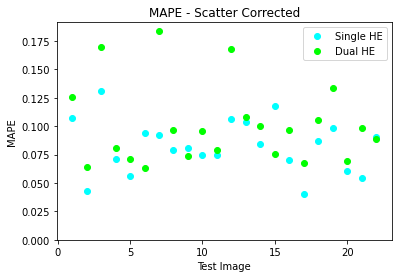

In [ ]:
plt.plot(np.arange(1,23),Test_MAPE_NS_HE_ROI,'o',color='cyan')
plt.plot(np.arange(1,23),Test_MAPE_NS_DUAL_ROI,'o',color='lime')
plt.ylim(0)
plt.title('MAPE - Scatter Corrected')
plt.xlabel('Test Image')
plt.ylabel('MAPE')
plt.legend(('Single HE','Dual HE'))

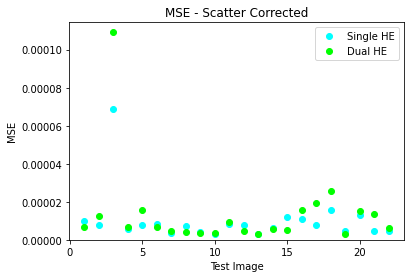

In [ ]:
plt.plot(np.arange(1,23),Test_MSE_NS_HE_ROI,'o',color='cyan')
plt.plot(np.arange(1,23),Test_MSE_NS_DUAL_ROI,'o',color='lime')
plt.ylim(0)
plt.title('MSE - Scatter Corrected')
plt.xlabel('Test Image')
plt.ylabel('MSE')
plt.legend(('Single HE','Dual HE'))

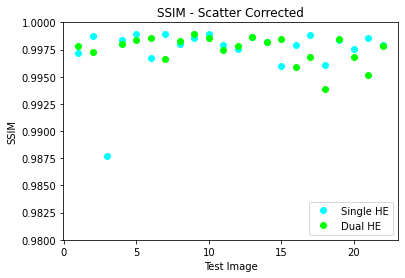

In [ ]:
plt.plot(np.arange(1,23),Test_SSIM_NS_HE0_ROI,'o',color='cyan')
plt.plot(np.arange(1,23),Test_SSIM_NS_DUAL0_ROI,'o',color='lime')
plt.ylim(0.98,1.0)
plt.title('SSIM - Scatter Corrected')
plt.xlabel('Test Image')
plt.ylabel('SSIM')
plt.legend(('Single HE','Dual HE'))

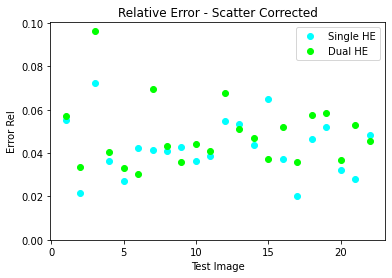

In [ ]:
plt.plot(np.arange(1,23),Test_DIF_HE_NSrel_ROI,'o',color='cyan')
plt.plot(np.arange(1,23),Test_DIF_DUAL_HE_NSrel_ROI,'o',color='lime')
plt.ylim(0)
plt.title('Relative Error - Scatter Corrected')
plt.xlabel('Test Image')
plt.ylabel('Error Rel')
plt.legend(('Single HE','Dual HE'))

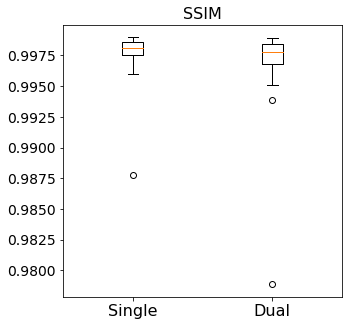

In [ ]:
# BOX AND WHISKERS PLOT - SSIM
#MultipleBoxplot
labels = ['Single', 'Dual']
Test_SSIM_boxplt_ROI = np.zeros((2,22))
Test_SSIM_boxplt_ROI[0,:] = Test_SSIM_NS_HE0_ROI[:,0]
Test_SSIM_boxplt_ROI[1,:] = Test_SSIM_NS_DUAL0_ROI[:,0]
Test_SSIM_boxplt_ROI = np.transpose(Test_SSIM_boxplt_ROI)
plt.figure(figsize=(5,5))
plt.boxplot(Test_SSIM_boxplt_ROI, vert=True, patch_artist=False, labels=labels, showmeans=False)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.title('SSIM',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
stats.ttest_ind(Test_SSIM_NS_HE0_ROI[:,0], Test_SSIM_NS_DUAL0_ROI[:,0])

Ttest_indResult(statistic=0.8499425417156059, pvalue=0.400176280121732)

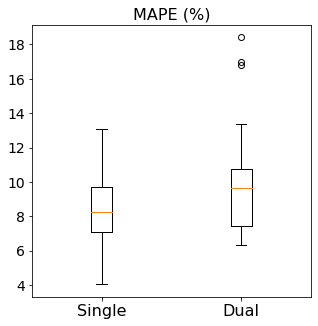

In [ ]:
#MultipleBoxplot - MAPE
labels = ['Single', 'Dual']
Test_MAPE_boxplt_ROI = np.zeros((22,2))
Test_MAPE_boxplt_ROI[:,0] = Test_MAPE_NS_HE_ROI[:,0]*100
Test_MAPE_boxplt_ROI[:,1] = Test_MAPE_NS_DUAL_ROI[:,0]*100
#Test_MAPE_boxplt = np.transpose(Test_MAPE_boxplt)
plt.figure(figsize=(5,5))
plt.boxplot(Test_MAPE_boxplt_ROI, vert=True, patch_artist=False, labels=labels, showmeans=False)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.title('MAPE (%)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
stats.ttest_ind(Test_MAPE_NS_HE_ROI[:,0], Test_MAPE_NS_DUAL_ROI[:,0])

Ttest_indResult(statistic=-1.993900026965279, pvalue=0.052682666819530516)

In [ ]:
#Valores máximo y mínimo MAPE
print('Máximo MAPE HE: ',Test_MAPE_boxplt_ROI[:,0].max())
print('Mínimo MAPE HE: ',Test_MAPE_boxplt_ROI[:,0].min())
print('Máximo MAPE DUAL: ',Test_MAPE_boxplt_ROI[:,1].max())
print('Mínimo MAPE DUAL: ',Test_MAPE_boxplt_ROI[:,1].min())

Máximo MAPE HE:  13.077172911482998
Mínimo MAPE HE:  4.0247576855454446
Máximo MAPE DUAL:  18.414658706718605
Mínimo MAPE DUAL:  6.336085110789012


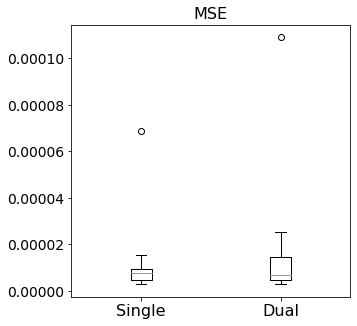

In [ ]:
#MultipleBoxplot - MSE
labels = ['Single', 'Dual']
Test_MSE_boxplt_ROI = np.zeros((22,2))
Test_MSE_boxplt_ROI[:,0] = Test_MSE_NS_HE_ROI[:,0]
Test_MSE_boxplt_ROI[:,1] = Test_MSE_NS_DUAL_ROI[:,0]
#Test_MAPE_boxplt = np.transpose(Test_MAPE_boxplt)
plt.figure(figsize=(5,5))
plt.boxplot(Test_MSE_boxplt_ROI, vert=True, patch_artist=False, labels=labels, showmeans=False)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.title('MSE',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
stats.ttest_ind(Test_MSE_NS_HE_ROI[:,0], Test_MSE_NS_DUAL_ROI[:,0])

Ttest_indResult(statistic=-0.6197717261886796, pvalue=0.5387561538326416)

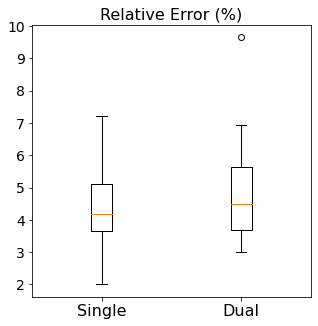

In [ ]:
#MultipleBoxplot - ERROR REL
labels = ['Single', 'Dual']
Test_EREL_boxplt_ROI = np.zeros((22,2))
Test_EREL_boxplt_ROI[:,0] = Test_DIF_HE_NSrel_ROI[:,0]*100
Test_EREL_boxplt_ROI[:,1] = Test_DIF_DUAL_HE_NSrel_ROI[:,0]*100
#Test_MAPE_boxplt = np.transpose(Test_MAPE_boxplt)
plt.figure(figsize=(5,5))
plt.boxplot(Test_EREL_boxplt_ROI, vert=True, patch_artist=False, labels=labels, showmeans=False)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.title('Relative Error (%)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
#Valores máximo y mínimo MAPE
print('Máximo EREL HE: ',Test_EREL_boxplt_ROI[:,0].max())
print('Mínimo EREL HE: ',Test_EREL_boxplt_ROI[:,0].min())
print('Máximo EREL DUAL: ',Test_EREL_boxplt_ROI[:,1].max())
print('Mínimo EREL DUAL: ',Test_EREL_boxplt_ROI[:,1].min())

Máximo EREL HE:  7.2304157550077175
Mínimo EREL HE:  2.000521499096349
Máximo EREL DUAL:  9.653653234485345
Mínimo EREL DUAL:  3.0163736107001036


In [ ]:
stats.ttest_ind(Test_DIF_HE_NSrel_ROI[:,0], Test_DIF_DUAL_HE_NSrel_ROI[:,0])

Ttest_indResult(statistic=-1.3794011687147896, pvalue=0.175071999019745)

#### Scatter ROI

In [ ]:
print('Media MSE HE:',Test_MSE_S_HE_ROI.mean())
print('Std MSE HE:',Test_MSE_S_HE_ROI.std())
print('Media MSE DUAL:',Test_MSE_S_DUAL_ROI.mean())
print('Std MSE DUAL:',Test_MSE_S_DUAL_ROI.std())
print('Media MAPE HE:',Test_MAPE_S_HE_ROI.mean())
print('Std MAPE HE:',Test_MAPE_S_HE_ROI.std())
print('Media MAPE DUAL:',Test_MAPE_S_DUAL_ROI.mean())
print('Std MAPE DUAL:',Test_MAPE_S_DUAL_ROI.std())
print('Media SSIM HE:',Test_SSIM_S_HE0_ROI.mean())
print('Std SSIM HE:',Test_SSIM_S_HE0_ROI.std())
print('Media SSIM DUAL:',Test_SSIM_S_DUAL0_ROI.mean())
print('Std SSIM DUAL:',Test_SSIM_S_DUAL0_ROI.std())
print('Media EREL HE:',Test_DIF_HE_rel_ROI.mean())
print('Std EREL HE:',Test_DIF_HE_rel_ROI.std())
print('Media EREL DUAL:',Test_DIF_DUAL_HE_rel_ROI.mean())
print('Std EREL DUAL:',Test_DIF_DUAL_HE_rel_ROI.std())

Media MSE HE: 1.0212774028668625e-05
Std MSE HE: 1.318674449312268e-05
Media MSE DUAL: 1.3641145764242182e-05
Std MSE DUAL: 2.1649394036363006e-05
Media MAPE HE: 0.05683995663003832
Std MAPE HE: 0.026055147129863638
Media MAPE DUAL: 0.0628579246563002
Std MAPE DUAL: 0.034980041559960505
Media SSIM HE: 0.9976718592922513
Std SSIM HE: 0.0021980779942386984
Media SSIM DUAL: 0.9971286265926561
Std SSIM DUAL: 0.003448797446518521
Media EREL HE: 0.02727972813713856
Std EREL HE: 0.011602702503592266
Media EREL DUAL: 0.03027802678160103
Std EREL DUAL: 0.015463447062126554


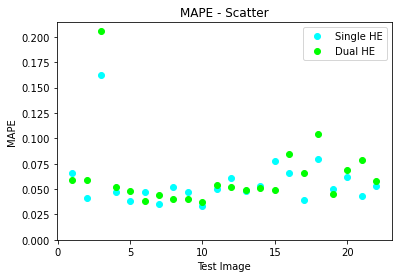

In [ ]:
plt.plot(np.arange(1,23),Test_MAPE_S_HE_ROI,'o',color='cyan')
plt.plot(np.arange(1,23),Test_MAPE_S_DUAL_ROI,'o',color='lime')
plt.ylim(0)
plt.title('MAPE - Scatter')
plt.xlabel('Test Image')
plt.ylabel('MAPE')
plt.legend(('Single HE','Dual HE'))

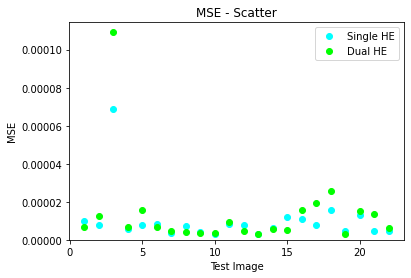

In [ ]:
plt.plot(np.arange(1,23),Test_MSE_S_HE_ROI,'o',color='cyan')
plt.plot(np.arange(1,23),Test_MSE_S_DUAL_ROI,'o',color='lime')
plt.ylim(0)
plt.title('MSE - Scatter')
plt.xlabel('Test Image')
plt.ylabel('MSE')
plt.legend(('Single HE','Dual HE'))

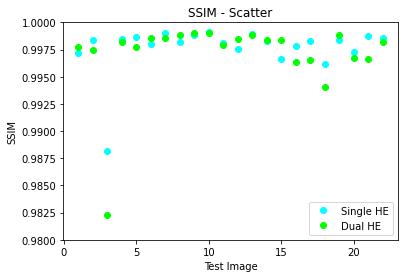

In [ ]:
plt.plot(np.arange(1,23),Test_SSIM_S_HE0_ROI,'o',color='cyan')
plt.plot(np.arange(1,23),Test_SSIM_S_DUAL0_ROI,'o',color='lime')
plt.ylim(0.98,1.0)
plt.title('SSIM - Scatter')
plt.xlabel('Test Image')
plt.ylabel('SSIM')
plt.legend(('Single HE','Dual HE'))

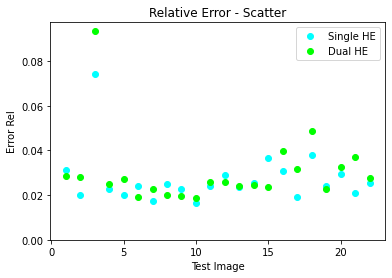

In [ ]:
plt.plot(np.arange(1,23),Test_DIF_HE_rel_ROI,'o',color='cyan')
plt.plot(np.arange(1,23),Test_DIF_DUAL_HE_rel_ROI,'o',color='lime')
plt.ylim(0)
plt.title('Relative Error - Scatter')
plt.xlabel('Test Image')
plt.ylabel('Error Rel')
plt.legend(('Single HE','Dual HE'))

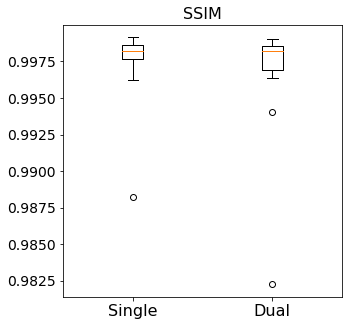

In [ ]:
# BOX AND WHISKERS PLOT - SSIM
#MultipleBoxplot
labels = ['Single', 'Dual']
Test_SSIM_boxplt_ROI = np.zeros((2,22))
Test_SSIM_boxplt_ROI[0,:] = Test_SSIM_S_HE0_ROI[:,0]
Test_SSIM_boxplt_ROI[1,:] = Test_SSIM_S_DUAL0_ROI[:,0]
Test_SSIM_boxplt_ROI = np.transpose(Test_SSIM_boxplt_ROI)
plt.figure(figsize=(5,5))
plt.boxplot(Test_SSIM_boxplt_ROI, vert=True, patch_artist=False, labels=labels, showmeans=False)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.title('SSIM',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
stats.ttest_ind(Test_SSIM_S_HE0_ROI[:,0], Test_SSIM_S_DUAL0_ROI[:,0])

Ttest_indResult(statistic=0.6086992154103583, pvalue=0.5460021383394148)

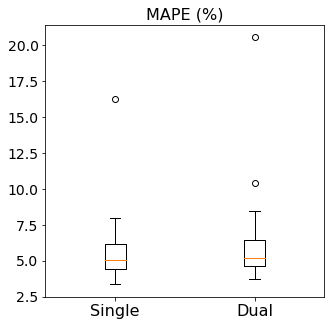

In [ ]:
#MultipleBoxplot - MAPE
labels = ['Single', 'Dual']
Test_MAPE_boxplt_ROI = np.zeros((22,2))
Test_MAPE_boxplt_ROI[:,0] = Test_MAPE_S_HE_ROI[:,0]*100
Test_MAPE_boxplt_ROI[:,1] = Test_MAPE_S_DUAL_ROI[:,0]*100
#Test_MAPE_boxplt = np.transpose(Test_MAPE_boxplt)
plt.figure(figsize=(5,5))
plt.boxplot(Test_MAPE_boxplt_ROI, vert=True, patch_artist=False, labels=labels, showmeans=False)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.title('MAPE (%)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
stats.ttest_ind(Test_MAPE_S_HE_ROI[:,0], Test_MAPE_S_DUAL_ROI[:,0])

Ttest_indResult(statistic=-0.6322664803774843, pvalue=0.5306398357206543)

In [ ]:
#Valores máximo y mínimo MAPE
print('Máximo MAPE HE: ',Test_MAPE_boxplt_ROI[:,0].max())
print('Mínimo MAPE HE: ',Test_MAPE_boxplt_ROI[:,0].min())
print('Máximo MAPE DUAL: ',Test_MAPE_boxplt_ROI[:,1].max())
print('Mínimo MAPE DUAL: ',Test_MAPE_boxplt_ROI[:,1].min())

Máximo MAPE HE:  16.256864897915374
Mínimo MAPE HE:  3.3427921805287717
Máximo MAPE DUAL:  20.56680157687178
Mínimo MAPE DUAL:  3.7283640392507236


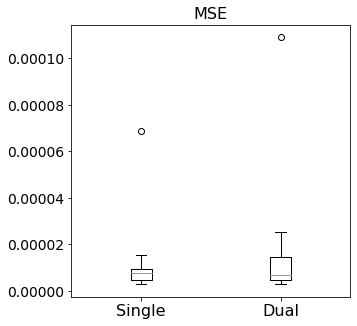

In [ ]:
#MultipleBoxplot - MSE
labels = ['Single', 'Dual']
Test_MSE_boxplt_ROI = np.zeros((22,2))
Test_MSE_boxplt_ROI[:,0] = Test_MSE_S_HE_ROI[:,0]
Test_MSE_boxplt_ROI[:,1] = Test_MSE_S_DUAL_ROI[:,0]
#Test_MAPE_boxplt = np.transpose(Test_MAPE_boxplt)
plt.figure(figsize=(5,5))
plt.boxplot(Test_MSE_boxplt_ROI, vert=True, patch_artist=False, labels=labels, showmeans=False)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.title('MSE',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
stats.ttest_ind(Test_MSE_S_HE_ROI[:,0], Test_MSE_S_DUAL_ROI[:,0])

Ttest_indResult(statistic=-0.6197717223487441, pvalue=0.5387561563368553)

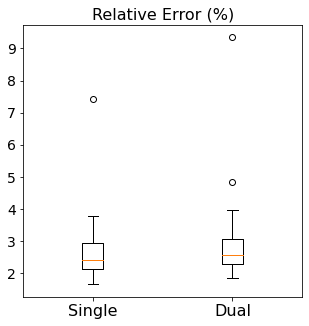

In [ ]:
#MultipleBoxplot - ERROR REL
labels = ['Single', 'Dual']
Test_EREL_boxplt_ROI = np.zeros((22,2))
Test_EREL_boxplt_ROI[:,0] = Test_DIF_HE_rel_ROI[:,0]*100
Test_EREL_boxplt_ROI[:,1] = Test_DIF_DUAL_HE_rel_ROI[:,0]*100
#Test_MAPE_boxplt = np.transpose(Test_MAPE_boxplt)
plt.figure(figsize=(5,5))
plt.boxplot(Test_EREL_boxplt_ROI, vert=True, patch_artist=False, labels=labels, showmeans=False)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.title('Relative Error (%)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
#Valores máximo y mínimo MAPE
print('Máximo EREL HE: ',Test_EREL_boxplt_ROI[:,0].max())
print('Mínimo EREL HE: ',Test_EREL_boxplt_ROI[:,0].min())
print('Máximo EREL DUAL: ',Test_EREL_boxplt_ROI[:,1].max())
print('Mínimo EREL DUAL: ',Test_EREL_boxplt_ROI[:,1].min())

Máximo EREL HE:  7.418769075724869
Mínimo EREL HE:  1.6534415793587436
Máximo EREL DUAL:  9.343653545111952
Mínimo EREL DUAL:  1.8512341823313052


In [ ]:
stats.ttest_ind(Test_DIF_HE_rel_ROI[:,0], Test_DIF_DUAL_HE_rel_ROI[:,0])

Ttest_indResult(statistic=-0.7107211212002891, pvalue=0.4811853778354791)

In [ ]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [ ]:
np.mean(signaltonoise(scat_ref_HE[50,:,:,0]))

8.328342

### EJEMPLO FIGURAS NUEVAS

Text(0.5, 0, 'X (cm)')

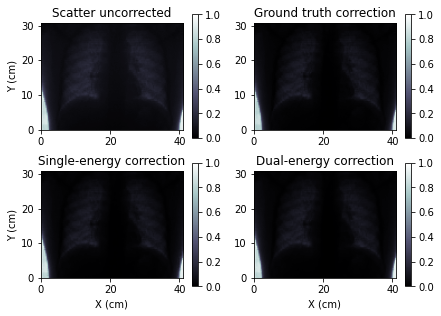

In [ ]:
plt.figure(figsize=(7, 5))
plt.subplot(2,2,1)
plt.imshow(np.rot90(total_HE[103,:,:,0]),cmap=plt.cm.bone,vmin=0,vmax=1,extent=[0,41,0,30.76])
plt.title('Scatter uncorrected')
#plt.axis('off')
plt.colorbar()
#plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
#plt.plot([14.41,14.41],[0.48,30.11],'dodgerblue',linestyle='-')

plt.subplot(2,2,2)
plt.imshow(np.rot90(NS_REF_HE[103,:,:]),cmap=plt.cm.bone,vmin=0,vmax=1,extent=[0,41,0,30.76])
plt.title('Ground truth correction')
#plt.axis('off')
plt.colorbar()
#plt.xlabel('X (cm)')
#plt.ylabel('Y (cm)')
#plt.plot([14.41,14.41],[0.48,30.11],'r',linestyle='-')

plt.subplot(2,2,3)
plt.imshow(np.rot90(NS_ESTIM_HE[103,:,:]),cmap=plt.cm.bone,vmin=0,vmax=1,extent=[0,41,0,30.76])
plt.title('Single-energy correction')
#plt.axis('off')
plt.colorbar()
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
#plt.plot([14.41,14.41],[0.48,30.11],'forestgreen',linestyle='--')

plt.subplot(2,2,4)
plt.imshow(np.rot90(NS_ESTIM_DUAL_HE[103,:,:]),cmap=plt.cm.bone,vmin=0,vmax=1,extent=[0,41,0,30.76])
plt.title('Dual-energy correction')
#plt.axis('off')
plt.colorbar()
plt.xlabel('X (cm)')
#plt.ylabel('Y (cm)')
#plt.plot([14.41,14.41],[0.48,30.11],'darkviolet',linestyle='--')

Text(0.5, 0, 'X (cm)')

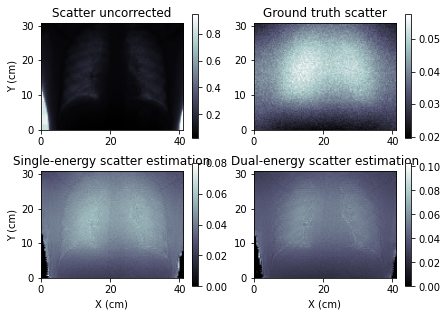

In [ ]:
plt.figure(figsize=(7, 5))
plt.subplot(2,2,1)
plt.imshow(np.rot90(total_HE[103,:,:,0]),cmap=plt.cm.bone,extent=[0,41,0,30.76])
plt.title('Scatter uncorrected')
#plt.axis('off')
plt.colorbar()
#plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
#plt.plot([14.41,14.41],[0.48,30.11],'dodgerblue',linestyle='-')

plt.subplot(2,2,2)
plt.imshow(np.rot90(S_REF_HE[103,:,:]),cmap=plt.cm.bone,extent=[0,41,0,30.76])
plt.title('Ground truth scatter')
#plt.axis('off')
plt.colorbar()
#plt.xlabel('X (cm)')
#plt.ylabel('Y (cm)')
#plt.plot([14.41,14.41],[0.48,30.11],'r',linestyle='-')

plt.subplot(2,2,3)
plt.imshow(np.rot90(S_ESTIM_HE[103,:,:]),cmap=plt.cm.bone,extent=[0,41,0,30.76])
plt.title('Single-energy scatter estimation')
#plt.axis('off')
plt.colorbar()
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
#plt.plot([14.41,14.41],[0.48,30.11],'forestgreen',linestyle='--')

plt.subplot(2,2,4)
plt.imshow(np.rot90(S_ESTIM_DUAL_HE[103,:,:]),cmap=plt.cm.bone,extent=[0,41,0,30.76])
plt.title('Dual-energy scatter estimation')
#plt.axis('off')
plt.colorbar()
plt.xlabel('X (cm)')
#plt.ylabel('Y (cm)')
#plt.plot([14.41,14.41],[0.48,30.11],'darkviolet',linestyle='--')

In [ ]:
plt.figure(figsize=(14, 4))
plt.subplot(1,3,1)
plt.imshow(np.rot90(out_np_HE_norm[103,:,:,0]),cmap=plt.cm.bone,extent=[0,41,0,30.76])
plt.title('Scatter fraction ground truth')
#plt.axis('off')
plt.colorbar()
#plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
#plt.plot([14.41,14.41],[0.48,30.11],'dodgerblue',linestyle='-')

plt.subplot(1,3,2)
plt.imshow(np.rot90(ST_ESTIM_HE[103,:,:]),cmap=plt.cm.bone,extent=[0,41,0,30.76])
plt.title('Output Single-energy')
#plt.axis('off')
plt.colorbar()
#plt.xlabel('X (cm)')
#plt.ylabel('Y (cm)')
#plt.plot([14.41,14.41],[0.48,30.11],'r',linestyle='-')

plt.subplot(1,3,3)
plt.imshow(np.rot90(ST_ESTIM_DUAL_HE[103,:,:]),cmap=plt.cm.bone,extent=[0,41,0,30.76])
plt.title('Output Dual-energy')
#plt.axis('off')
plt.colorbar()

## CONTRASTE cuando se limpia el scatter

#### Load Test Images and their Covid masks (2050x2050)

##### Low Energy

In [ ]:
filelist_LE_NS = glob.glob('drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/NOSCATTER/*.raw')
#x = np.array([np.array(Image.open(fname)) for fname in filelist])
PROJ_LE_NS = np.zeros((22,2050,2050),dtype='float32')
i = 0
for filename in sorted(filelist_LE_NS):
  PROJ_LE_single = np.fromfile(filename,dtype='float32')
  PROJ_LE_single = np.reshape(PROJ_LE_single,(2050,2050))
  print(filename)
  PROJ_LE_NS[i,:,:] = PROJ_LE_single
  i = i+1

drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/NOSCATTER/P_NSLE_A-0462.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/NOSCATTER/P_NSLE_A-0463.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/NOSCATTER/P_NSLE_A-0464.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/NOSCATTER/P_NSLE_A-0472.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/NOSCATTER/P_NSLE_A-0473.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/NOSCATTER/P_NSLE_A-0476.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/NOSCATTER/P_NSLE_A-0483.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/NOSCATTER/P_NSLE_A-0494.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/NOSCATTER/P_NSLE_A-0495.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/NOSCATTER/P_NSLE_A-0500.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_B

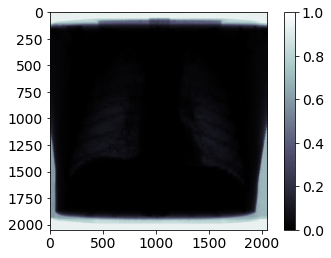

In [ ]:
#plt.figure(figsize=(4,4))
im = plt.imshow(np.rot90(PROJ_LE_NS[7,:,:]),cmap=plt.cm.bone,vmin=0,vmax=1) #,extent=[0,41,0,30.76])
#plt.axis('off')
#plt.xlabel('X (cm)',fontsize=16)
plt.xticks(fontsize=14)
#plt.ylabel('Y (cm)',fontsize=16)
plt.yticks(fontsize=14)
#plt.colorbar()
cb = plt.colorbar(im) #, orientation="horizontal", pad=0.15)
cb.set_label(label='',size=4) #, weight='bold')
cb.ax.tick_params(labelsize=14)

In [ ]:
filelist_LE_S = glob.glob('drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/SCATTER/*.raw')
#x = np.array([np.array(Image.open(fname)) for fname in filelist])
PROJ_LE_S = np.zeros((22,2050,2050),dtype='float32')
i = 0
for filename in sorted(filelist_LE_S):
  PROJ_LE_single = np.fromfile(filename,dtype='float32')
  PROJ_LE_single = np.reshape(PROJ_LE_single,(2050,2050))
  print(filename)
  PROJ_LE_S[i,:,:] = PROJ_LE_single
  i = i+1

drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/SCATTER/P_SLE_A-0462.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/SCATTER/P_SLE_A-0463.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/SCATTER/P_SLE_A-0464.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/SCATTER/P_SLE_A-0472.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/SCATTER/P_SLE_A-0473.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/SCATTER/P_SLE_A-0476.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/SCATTER/P_SLE_A-0483.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/SCATTER/P_SLE_A-0494.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/SCATTER/P_SLE_A-0495.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/SCATTER/P_SLE_A-0500.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/SCATTER/P_SLE

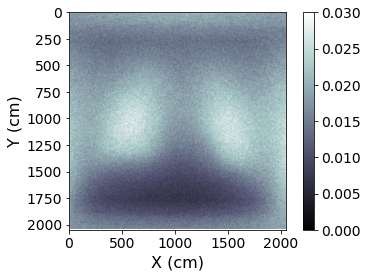

In [ ]:
#plt.figure(figsize=(4,4))
im = plt.imshow(np.rot90(PROJ_LE_S[7,:,:]),cmap=plt.cm.bone,vmin=0,vmax=0.03) #,extent=[0,41,0,30.76])
#plt.axis('off')
plt.xlabel('X (cm)',fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Y (cm)',fontsize=16)
plt.yticks(fontsize=14)
#plt.colorbar()
cb = plt.colorbar(im) #, orientation="horizontal", pad=0.15)
cb.set_label(label='',size=4) #, weight='bold')
cb.ax.tick_params(labelsize=14)

In [ ]:
filelist_LE_T = glob.glob('drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/TOTAL/*.raw')
#x = np.array([np.array(Image.open(fname)) for fname in filelist])
PROJ_LE_T = np.zeros((22,2050,2050),dtype='float32')
i = 0
for filename in sorted(filelist_LE_T):
  PROJ_LE_single = np.fromfile(filename,dtype='float32')
  PROJ_LE_single = np.reshape(PROJ_LE_single,(2050,2050))
  print(filename)
  PROJ_LE_T[i,:,:] = PROJ_LE_single
  i = i+1

drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/TOTAL/P_TLE_A-0462.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/TOTAL/P_TLE_A-0463.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/TOTAL/P_TLE_A-0464.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/TOTAL/P_TLE_A-0472.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/TOTAL/P_TLE_A-0473.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/TOTAL/P_TLE_A-0476.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/TOTAL/P_TLE_A-0483.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/TOTAL/P_TLE_A-0494.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/TOTAL/P_TLE_A-0495.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/TOTAL/P_TLE_A-0500.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/BAJA_ENERGIA/TOTAL/P_TLE_A-0502.raw
drive/My D

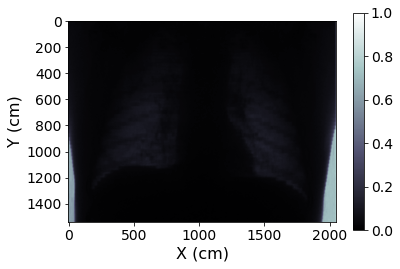

In [ ]:
im = plt.imshow(np.rot90(PROJ_LE_T[7,:,256:1794]),cmap=plt.cm.bone,vmin=0,vmax=1) #,extent=[0,41,0,30.76])
#plt.axis('off')
plt.xlabel('X (cm)',fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Y (cm)',fontsize=16)
plt.yticks(fontsize=14)
#plt.colorbar()
cb = plt.colorbar(im) #, orientation="horizontal", pad=0.15)
cb.set_label(label='',size=4) #, weight='bold')
cb.ax.tick_params(labelsize=14)

##### High Energy

In [ ]:
filelist_HE_NS = glob.glob('drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/NOSCATTER/*.raw')
#x = np.array([np.array(Image.open(fname)) for fname in filelist])
PROJ_HE_NS = np.zeros((22,2050,2050),dtype='float32')
i = 0
for filename in sorted(filelist_HE_NS):
  PROJ_HE_single = np.fromfile(filename,dtype='float32')
  PROJ_HE_single = np.reshape(PROJ_HE_single,(2050,2050))
  print(filename)
  PROJ_HE_NS[i,:,:] = PROJ_HE_single
  i = i+1

drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/NOSCATTER/P_NSHE_A-0462.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/NOSCATTER/P_NSHE_A-0463.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/NOSCATTER/P_NSHE_A-0464.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/NOSCATTER/P_NSHE_A-0472.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/NOSCATTER/P_NSHE_A-0473.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/NOSCATTER/P_NSHE_A-0476.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/NOSCATTER/P_NSHE_A-0483.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/NOSCATTER/P_NSHE_A-0494.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/NOSCATTER/P_NSHE_A-0495.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/NOSCATTER/P_NSHE_A-0500.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_B

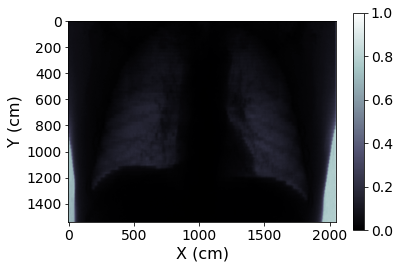

In [ ]:
im = plt.imshow(np.rot90(PROJ_HE_NS[7,:,256:1794]),cmap=plt.cm.bone,vmin=0,vmax=1) #,extent=[0,41,0,30.76])
#plt.axis('off')
plt.xlabel('X (cm)',fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Y (cm)',fontsize=16)
plt.yticks(fontsize=14)
#plt.colorbar()
cb = plt.colorbar(im) #, orientation="horizontal", pad=0.15)
cb.set_label(label='',size=4) #, weight='bold')
cb.ax.tick_params(labelsize=14)

In [ ]:
filelist_HE_S = glob.glob('drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/SCATTER/*.raw')
#x = np.array([np.array(Image.open(fname)) for fname in filelist])
PROJ_HE_S = np.zeros((22,2050,2050),dtype='float32')
i = 0
for filename in sorted(filelist_HE_S):
  PROJ_HE_single = np.fromfile(filename,dtype='float32')
  PROJ_HE_single = np.reshape(PROJ_HE_single,(2050,2050))
  print(filename)
  PROJ_HE_S[i,:,:] = PROJ_HE_single
  i = i+1

drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/SCATTER/P_SHE_A-0462.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/SCATTER/P_SHE_A-0463.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/SCATTER/P_SHE_A-0464.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/SCATTER/P_SHE_A-0472.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/SCATTER/P_SHE_A-0473.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/SCATTER/P_SHE_A-0476.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/SCATTER/P_SHE_A-0483.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/SCATTER/P_SHE_A-0494.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/SCATTER/P_SHE_A-0495.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/SCATTER/P_SHE_A-0500.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/SCATTER/P_SHE

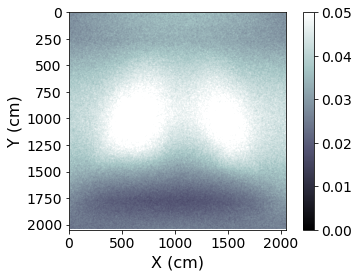

In [ ]:
im = plt.imshow(np.rot90(PROJ_HE_S[7,:,:]),cmap=plt.cm.bone,vmin=0,vmax=0.05) #extent=[0,41,0,30.76])
#plt.axis('off')
plt.xlabel('X (cm)',fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Y (cm)',fontsize=16)
plt.yticks(fontsize=14)
#plt.colorbar()
cb = plt.colorbar(im) #, orientation="horizontal", pad=0.15)
cb.set_label(label='',size=4) #, weight='bold')
cb.ax.tick_params(labelsize=14)

In [ ]:
filelist_HE_T = glob.glob('drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/TOTAL/*.raw')
#x = np.array([np.array(Image.open(fname)) for fname in filelist])
PROJ_HE_T = np.zeros((22,2050,2050),dtype='float32')
i = 0
for filename in sorted(filelist_HE_T):
  PROJ_HE_single = np.fromfile(filename,dtype='float32')
  PROJ_HE_single = np.reshape(PROJ_HE_single,(2050,2050))
  print(filename)
  PROJ_HE_T[i,:,:] = PROJ_HE_single
  i = i+1

drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/TOTAL/P_THE_A-0462.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/TOTAL/P_THE_A-0463.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/TOTAL/P_THE_A-0464.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/TOTAL/P_THE_A-0472.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/TOTAL/P_THE_A-0473.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/TOTAL/P_THE_A-0476.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/TOTAL/P_THE_A-0483.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/TOTAL/P_THE_A-0494.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/TOTAL/P_THE_A-0495.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/TOTAL/P_THE_A-0500.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/ALTA_ENERGIA/TOTAL/P_THE_A-0502.raw
drive/My D

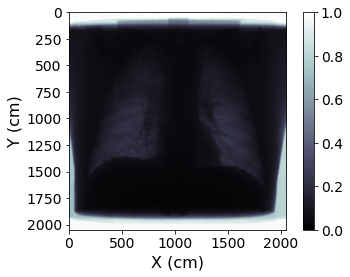

In [ ]:
im = plt.imshow(np.rot90(PROJ_HE_T[7,:,:]),cmap=plt.cm.bone,vmin=0,vmax=1) #,extent=[0,41,0,30.76])
#plt.axis('off')
plt.xlabel('X (cm)',fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Y (cm)',fontsize=16)
plt.yticks(fontsize=14)
#plt.colorbar()
cb = plt.colorbar(im) #, orientation="horizontal", pad=0.15)
cb.set_label(label='',size=4) #, weight='bold')
cb.ax.tick_params(labelsize=14)

##### COVID MASKS

In [ ]:
filelist_MASK = glob.glob('drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/MASK/*.raw')
#x = np.array([np.array(Image.open(fname)) for fname in filelist])
PROJ_MASK = np.zeros((22,2050,2050),dtype='float32')
i = 0
for filename in sorted(filelist_MASK):
  PROJ_M_single = np.fromfile(filename,dtype='float32')
  PROJ_M_single = np.reshape(PROJ_M_single,(2050,2050))
  print(filename)
  PROJ_MASK[i,:,:] = PROJ_M_single
  i = i+1

drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/MASK/P_Mask_A-0462.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/MASK/P_Mask_A-0463.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/MASK/P_Mask_A-0464.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/MASK/P_Mask_A-0472.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/MASK/P_Mask_A-0473.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/MASK/P_Mask_A-0476.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/MASK/P_Mask_A-0483.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/MASK/P_Mask_A-0494.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/MASK/P_Mask_A-0495.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/MASK/P_Mask_A-0500.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/MASK/P_Mask_A-0502.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/MASK/P_Mask_A-0504.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/MASK/P_Mask_A-0521.raw

#### Resize Images 2050x2050 --> 128x128



In [ ]:
PROJ_LE_T = np.expand_dims(PROJ_LE_T,axis=-1)
PROJ_LE_NS = np.expand_dims(PROJ_LE_NS,axis=-1)
PROJ_LE_S = np.expand_dims(PROJ_LE_S,axis=-1)
PROJ_HE_T = np.expand_dims(PROJ_HE_T,axis=-1)
PROJ_HE_NS = np.expand_dims(PROJ_HE_NS,axis=-1)
PROJ_HE_S = np.expand_dims(PROJ_HE_S,axis=-1)
PROJ_MASK = np.expand_dims(PROJ_MASK,axis=-1)

PROJ_LE_T = tf.convert_to_tensor(PROJ_LE_T, tf.float32)
PROJ_LE_NS = tf.convert_to_tensor(PROJ_LE_NS, tf.float32)
PROJ_LE_S = tf.convert_to_tensor(PROJ_LE_S, tf.float32)
PROJ_HE_T = tf.convert_to_tensor(PROJ_HE_T, tf.float32)
PROJ_HE_NS = tf.convert_to_tensor(PROJ_HE_NS, tf.float32)
PROJ_HE_S = tf.convert_to_tensor(PROJ_HE_S, tf.float32)
PROJ_MASK = tf.convert_to_tensor(PROJ_MASK, tf.float32)

Nx2 = 128 #256
Ny2 = 128

PROJ_LE_T = tf.image.resize(PROJ_LE_T,[Nx2,Ny2],method='bilinear')
PROJ_LE_NS = tf.image.resize(PROJ_LE_NS,[Nx2,Ny2],method='bilinear')
PROJ_LE_S = tf.image.resize(PROJ_LE_S,[Nx2,Ny2],method='bilinear')
PROJ_HE_T = tf.image.resize(PROJ_HE_T,[Nx2,Ny2],method='bilinear')
PROJ_HE_NS = tf.image.resize(PROJ_HE_NS,[Nx2,Ny2],method='bilinear')
PROJ_HE_S = tf.image.resize(PROJ_HE_S,[Nx2,Ny2],method='bilinear')
PROJ_MASK = tf.image.resize(PROJ_MASK,[Nx2,Ny2],method='bilinear')


In [ ]:
print(tf.shape(PROJ_HE_T))

tf.Tensor([ 22 128 128   1], shape=(4,), dtype=int32)


In [ ]:
PROJ_LE_T = PROJ_LE_T[:,:,16:112,:]
PROJ_LE_NS = PROJ_LE_NS[:,:,16:112,:]
PROJ_LE_S = PROJ_LE_S[:,:,16:112,:]
PROJ_HE_T = PROJ_HE_T[:,:,16:112,:]
PROJ_HE_NS = PROJ_HE_NS[:,:,16:112,:]
PROJ_HE_S = PROJ_HE_S[:,:,16:112,:]
PROJ_MASK = PROJ_MASK[:,:,16:112,:]

#### Load Filtered Projections for Lung Seg

In [ ]:
model_lung = tf.keras.models.load_model('drive/My Drive/ENERGIA_DUAL_IMAGENES/lung_segmentator_KERAS_Gabi.h5',compile=False)

In [ ]:
def analyze_mask(mask, visual):
  etiquetas = np.int32(np.round(np.squeeze(mask)))
  labels_mask = measure.label(etiquetas)
  regions = measure.regionprops(labels_mask)
  regions.sort(key=lambda x: x.area, reverse=True)
  if len(regions) > 1:
     for rg in regions[2:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
  labels_mask[labels_mask!=0] = 1

  if visual:
    #fig, ax = plt.subplots()
    #ax.imshow(np.squeeze(labels_mask), cmap=plt.cm.gray)
    bx_2=[ ]
    by_2=[ ]
    for props in regions[0:2]:
      y0, x0 = props.centroid
      orientation = props.orientation
      x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
      y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
      x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
      y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

      #ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
      #ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
      #ax.plot(x0, y0, '.g', markersize=15)

      minr, minc, maxr, maxc = props.bbox
      bx = (minc, maxc, maxc, minc, minc)
      by = (minr, minr, maxr, maxr, minr)
      bx_2.append(bx)
      by_2.append(by)
      #ax.plot(bx, by, '-b', linewidth=2.5)

    bx_2=np.array(bx_2)
    by_2=np.array(by_2)
    #ax.axis((0, 320, 320, 0))
    #plt.show()

  return regions[0:2],labels_mask,bx_2,by_2

In [ ]:
filelist_seg = glob.glob('drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/PARA_SEG_PULMON/*nocut.mat')
#x = np.array([np.array(Image.open(fname)) for fname in filelist])
PROJ_SEG = np.zeros((22,512,512),dtype='float32')
MASK_TEST = np.zeros((22,64,64),dtype='float32')
MASK_TEST_FILT3 = np.zeros((22,64,64),dtype='float32')
MASK_TEST_FILT1 = np.zeros((22,64,64),dtype='float32')
MASK_TEST_DEF = np.zeros((22,128,96,1),dtype='float32')

i = 0
for filename in sorted(filelist_seg):
  PROJ_S_single = loadmat(filename)
  PROJ_S_single = PROJ_S_single['Z1_b2']
  print(filename)
  PROJ_SEG[i,:,:] = PROJ_S_single
  plt.imsave('filename.png',PROJ_SEG[i,:,:])
  img=cv2.imread('filename.png',0)
  clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(1,1))
  img = clahe.apply(img)
  plt.imsave('filename.png',img)
  image = tf.reshape(img, [1, 512, 512, 1])
  image = tf.image.resize(image,[64, 64])
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  mask = model_lung(image, training=False)>0.5
  MASK_TEST[i,:,:]=np.squeeze(mask)
  reg, MASK_TEST_FILT, Bx, By = analyze_mask(MASK_TEST[i,:,:],True)
  MASK_TEST_FILT[reg[0].coords[:,0], reg[0].coords[:,1]] = 2
  MASK_TEST_FILT1[i,:,:] = MASK_TEST_FILT
  A = np.zeros_like(MASK_TEST_FILT)
  A[reg[0].coords[:,0], reg[0].coords[:,1]] = 1
  #A2 = 2*convex_hull_image(A)
  B = np.zeros_like(MASK_TEST_FILT)
  B[reg[1].coords[:,0], reg[1].coords[:,1]] = 1
  #B2 = convex_hull_image(B)
  # MÉTODO 3: dilation - erosion
  kernel = np.ones((5,5), np.uint8)
  kernel = nd.generate_binary_structure(2, 1)
  A3 = nd.binary_dilation(A,kernel,iterations=4)
  A3 = nd.binary_erosion(A3,kernel,iterations=4)
  B3 = nd.binary_dilation(B,kernel,iterations=4)
  B3 = nd.binary_erosion(B3,kernel,iterations=4)
  MASK_TEST_FILT3[i,:,:] = 2*A3 + B3

  MASK_FILT3_rot = np.rot90(MASK_TEST_FILT3[i,:,:],3)

  MASK_TEST_RES = tf.reshape(MASK_FILT3_rot, [1, 64, 64, 1])
  MASK_TEST_RES = tf.image.resize(MASK_TEST_RES,[128, 128])

  MASK_TEST_DEF[i,:,:,0] = MASK_TEST_RES[0,:,16:112,0]
  i = i+1


drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/PARA_SEG_PULMON/P_Filtros_A0462_nocut.mat
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/PARA_SEG_PULMON/P_Filtros_A0463_nocut.mat
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/PARA_SEG_PULMON/P_Filtros_A0464_nocut.mat
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/PARA_SEG_PULMON/P_Filtros_A0472_nocut.mat
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/PARA_SEG_PULMON/P_Filtros_A0473_nocut.mat
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/PARA_SEG_PULMON/P_Filtros_A0476_nocut.mat
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/PARA_SEG_PULMON/P_Filtros_A0483_nocut.mat
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/PARA_SEG_PULMON/P_Filtros_A0494_nocut.mat
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/PARA_SEG_PULMON/P_Filtros_A0495_nocut.mat
drive/My Drive/ENERGIA_DUAL_IMAGENES/TEST_IMAGES_BIEN/PARA_SEG_PULMON/P_Filtros_A0500_nocut.mat
drive/My Drive/ENERGIA_DUAL_IMAGENES/TES

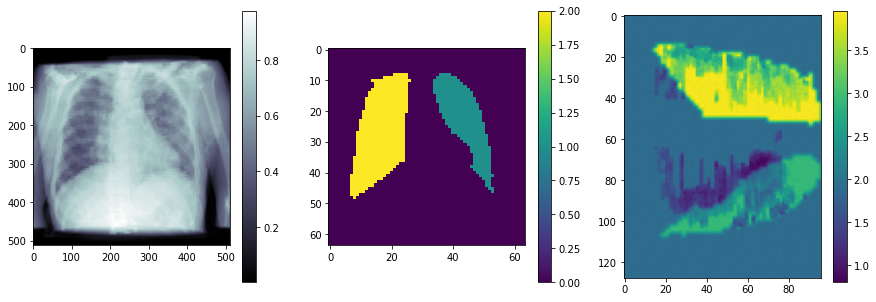

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(PROJ_SEG[5,:,:],cmap=plt.cm.bone)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(MASK_TEST_FILT3[5,:,:])
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(MASK_TEST_DEF[5,:,:,0] + 2*PROJ_MASK[5,:,:,0])
plt.colorbar()

### Contrast between Covid (or NonCovid) Regions and Full Lung

#### Index Lung Segmentation

In [ ]:
MASK_IZQ_LUNG = np.zeros_like(MASK_TEST_DEF)
MASK_DCH_LUNG = np.zeros_like(MASK_TEST_DEF)
for i in range(22):
  MASK_IZQ_LUNG[i,:,:,0] = np.where(MASK_TEST_DEF[i,:,:,0] > 1,MASK_TEST_DEF[i,:,:,0],0)
  MASK_DCH_LUNG[i,64:,:,0] = np.where(MASK_TEST_DEF[i,64:,:,0] > 0,MASK_TEST_DEF[i,64:,:,0],0)
  globals()['MASK_IZQ_LUNG_ID%s' % i] = np.nonzero(MASK_IZQ_LUNG[i,:,:,0])
  globals()['MASK_DCH_LUNG_ID%s' % i] = np.nonzero(MASK_DCH_LUNG[i,:,:,0])

#### Index COVID MASK

In [ ]:
PROJ_MASK_IZQ_ID = np.zeros_like(PROJ_MASK)
PROJ_MASK_DCH_ID = np.zeros_like(PROJ_MASK)
#COVID_ID = np.zeros_like(PROJ_MASK)
for i in range(22):
  PROJ_MASK_IZQ_ID[i,:64,:,0] = np.where(PROJ_MASK[i,:64,:,0],PROJ_MASK[i,:64,:,0] < 0.9, 1)
  PROJ_MASK_DCH_ID[i,64:,:,0] = np.where(PROJ_MASK[i,64:,:,0],PROJ_MASK[i,64:,:,0] < 0.9, 1)
  globals()['COVID_IZQ_ID%s' % i] = np.nonzero(PROJ_MASK_IZQ_ID[i,:,:,0])
  globals()['COVID_DCH_ID%s' % i] = np.nonzero(PROJ_MASK_DCH_ID[i,:,:,0])


In [ ]:
print(type(COVID_IZQ_ID10))

<class 'tuple'>


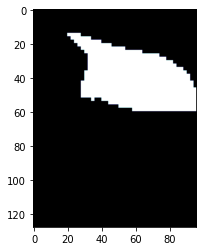

In [ ]:
prueba0 = np.zeros((128,96))
prueba0[MASK_IZQ_LUNG_ID9] = 1
plt.imshow(prueba0,cmap=plt.cm.bone)

#### Visualization PROJ + MASK LUNG + MASK COVID

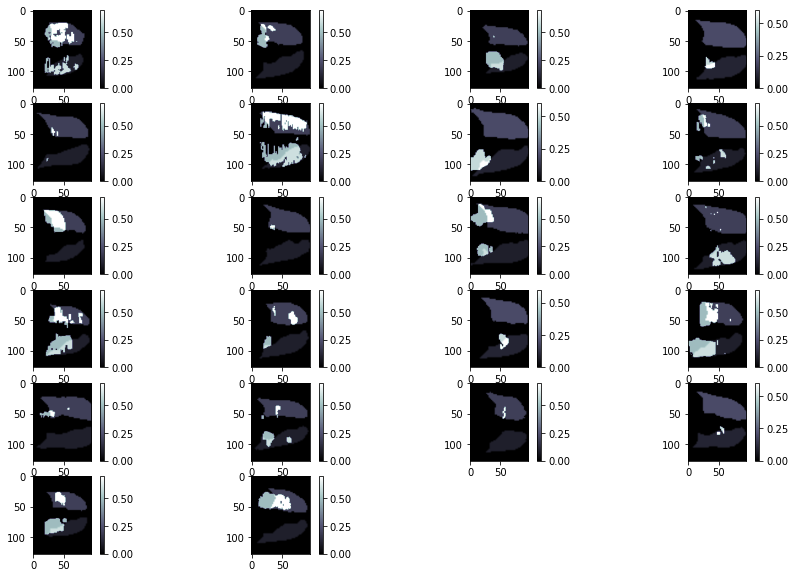

In [ ]:
plt.figure(figsize=(15,10))
for i in range(0,22):
   plt.subplot(6,4,i+1)
   #plt.imshow(np.squeeze(PROJ_HE_T[i,:,:,0]) + 0.5*np.squeeze(PROJ_MASK_ID[i,:,:,0]) + 0.1*np.squeeze(MASK_IZQ[i,:,:,0]) + 0.1*np.squeeze(MASK_DCH[i,:,:,0]),cmap=plt.cm.bone)
   plt.imshow(0.5*np.squeeze(PROJ_MASK_IZQ_ID[i,:,:,0]) + 0.5*np.squeeze(PROJ_MASK_DCH_ID[i,:,:,0])
    + 0.1*np.squeeze(MASK_IZQ_LUNG[i,:,:,0]) + 0.1*np.squeeze(MASK_DCH_LUNG[i,:,:,0]),cmap=plt.cm.bone)
   plt.colorbar()

#### Case 0 - A0462 (2 Pulmones)

##### Left Lung

In [ ]:
PROJ_T_0 = np.squeeze(PROJ_HE_T[0,:,:,0])
PROJ_NS_ESTIM_HE_0 = np.squeeze(Test_NS_ESTIM_HE[0,:,:])
PROJ_NS_ESTIM_DUAL_0 = np.squeeze(Test_NS_ESTIM_DUAL_HE[0,:,:])
PROJ_NS_REF_HE_0 = np.squeeze(Test_NS_REF_HE[0,:,:])

ctr_lung_total = PROJ_T_0[COVID_IZQ_ID0].mean()/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_0[COVID_IZQ_ID0].mean()/PROJ_NS_ESTIM_HE_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_0[COVID_IZQ_ID0].mean()/PROJ_NS_REF_HE_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_0[COVID_IZQ_ID0].mean()/PROJ_NS_ESTIM_DUAL_0[MASK_IZQ_LUNG_ID0].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.92017704
Contraste en la imagen limpia de scatter de referencia: 0.9031090993172436
Contraste en la imagen limpia de scatter estimda SINGLE: 0.9062046340407427
Contraste en la imagen limpia de scatter estimda DUAL: 0.9023748830086341


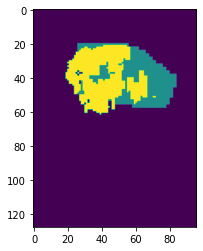

In [ ]:
# COMPROBACIÓN
prueba0_left = np.zeros((128,96))
prueba0_left[MASK_IZQ_LUNG_ID0] = 1
prueba0_left[COVID_IZQ_ID0] = 2
plt.imshow(prueba0_left)

Contraste en la imagen sin corregir: 1.1140618
Contraste en la imagen limpia de scatter de referencia: 1.1788801254033527
Contraste en la imagen limpia de scatter estimda SINGLE: 1.1787711743296279
Contraste en la imagen limpia de scatter estimda DUAL: 1.1764546436153083


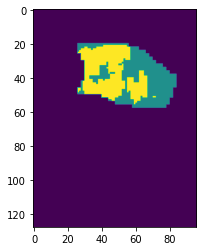

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_0NEW = np.where(MASK_IZQ_LUNG[0,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[0,:,:,0])
COVID_IZQ_ID0_NEW = np.nonzero(PROJ_MASK_IZQ_0NEW)

prueba0_left_new = np.zeros((128,96))
prueba0_left_new[MASK_IZQ_LUNG_ID0] = 1
prueba0_left_new[COVID_IZQ_ID0_NEW] = 2
plt.imshow(prueba0_left_new)

ctr_lung_total = PROJ_T_0[COVID_IZQ_ID0_NEW].mean()/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_0[COVID_IZQ_ID0_NEW].mean()/PROJ_NS_ESTIM_HE_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_0[COVID_IZQ_ID0_NEW].mean()/PROJ_NS_REF_HE_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_0[COVID_IZQ_ID0_NEW].mean()/PROJ_NS_ESTIM_DUAL_0[MASK_IZQ_LUNG_ID0].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.88995916
Contraste en la imagen limpia de scatter de referencia: 0.8274258719669184
Contraste en la imagen limpia de scatter estimda SINGLE: 0.8275309822272332
Contraste en la imagen limpia de scatter estimda DUAL: 0.8297658491090858


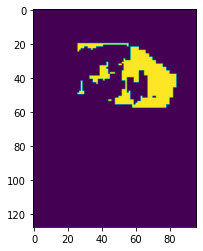

In [ ]:
# CONTRASTE ZONA NO COVID/PULMON
prueba0_left_NC = np.zeros((128,96))
prueba0_left_NC[MASK_IZQ_LUNG_ID0] = 1
prueba0_left_NC[COVID_IZQ_ID0] = 0
#lung_total_izq = np.zeros_like(lung_izq)
#lung_total_izq[idx_lung_izq] = 1
#lung_covid_izq = np.zeros_like(lung_izq)
#lung_covid_izq[id_covid] = 1
#lung_nocovid = lung_total_izq-lung_covid_izq
#lung_nocovid[:,:60] = 0
id_nocovid_0left = np.nonzero(prueba0_left_NC)

ctr_lung_total = PROJ_T_0[id_nocovid_0left].mean()/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_0[id_nocovid_0left].mean()/PROJ_NS_ESTIM_HE_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_0[id_nocovid_0left].mean()/PROJ_NS_REF_HE_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_0[id_nocovid_0left].mean()/PROJ_NS_ESTIM_DUAL_0[MASK_IZQ_LUNG_ID0].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

plt.imshow(prueba0_left_NC)

Contraste en la imagen sin corregir: 1.2518122
Contraste en la imagen limpia de scatter de referencia: 1.4247561809989981
Contraste en la imagen limpia de scatter estimda SINGLE: 1.4244435551609922
Contraste en la imagen limpia de scatter estimda DUAL: 1.4178152124222274


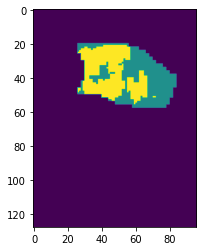

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba0_left_NC = np.zeros((128,96))
prueba0_left_NC[MASK_IZQ_LUNG_ID0] = 1
prueba0_left_NC[COVID_IZQ_ID0] = 0
id_nocovid_0left = np.nonzero(prueba0_left_NC)

prueba0_left_new = np.zeros((128,96))
prueba0_left_new[id_nocovid_0left] = 1
prueba0_left_new[COVID_IZQ_ID0_NEW] = 2
plt.imshow(prueba0_left_new)

ctr_lung_total = PROJ_T_0[COVID_IZQ_ID0_NEW].mean()/PROJ_T_0[id_nocovid_0left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_0[COVID_IZQ_ID0_NEW].mean()/PROJ_NS_ESTIM_HE_0[id_nocovid_0left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_0[COVID_IZQ_ID0_NEW].mean()/PROJ_NS_REF_HE_0[id_nocovid_0left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_0[COVID_IZQ_ID0_NEW].mean()/PROJ_NS_ESTIM_DUAL_0[id_nocovid_0left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

##### Right Lung

In [ ]:
ctr_lung_total = PROJ_T_0[COVID_DCH_ID0].mean()/PROJ_T_0[MASK_DCH_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_0[COVID_DCH_ID0].mean()/PROJ_NS_ESTIM_HE_0[MASK_DCH_LUNG_ID0].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_0[COVID_DCH_ID0].mean()/PROJ_NS_REF_HE_0[MASK_DCH_LUNG_ID0].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_0[COVID_DCH_ID0].mean()/PROJ_NS_ESTIM_DUAL_0[MASK_DCH_LUNG_ID0].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.97445434
Contraste en la imagen limpia de scatter de referencia: 0.9896633126236307
Contraste en la imagen limpia de scatter estimda SINGLE: 0.9930147386174724
Contraste en la imagen limpia de scatter estimda DUAL: 0.9897461754556798


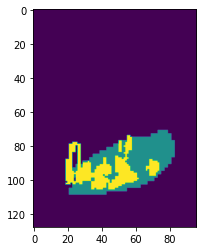

In [ ]:
# COMPROBACIÓN
prueba0_right = np.zeros((128,96))
prueba0_right[MASK_DCH_LUNG_ID0] = 1
prueba0_right[COVID_DCH_ID0] = 2
plt.imshow(prueba0_right)

Contraste en la imagen sin corregir: 1.1117524
Contraste en la imagen limpia de scatter de referencia: 1.1758913339066466
Contraste en la imagen limpia de scatter estimda SINGLE: 1.179398301835641
Contraste en la imagen limpia de scatter estimda DUAL: 1.1765939632150915


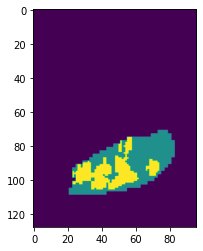

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_DCH_0NEW = np.where(MASK_DCH_LUNG[0,:,:,0] == 0,0,PROJ_MASK_DCH_ID[0,:,:,0])
COVID_DCH_ID0_NEW = np.nonzero(PROJ_MASK_DCH_0NEW)

prueba0_right_new = np.zeros((128,96))
prueba0_right_new[MASK_DCH_LUNG_ID0] = 1
prueba0_right_new[COVID_DCH_ID0_NEW] = 2
plt.imshow(prueba0_right_new)

ctr_lung_total = PROJ_T_0[COVID_DCH_ID0_NEW].mean()/PROJ_T_0[MASK_DCH_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_0[COVID_DCH_ID0_NEW].mean()/PROJ_NS_ESTIM_HE_0[MASK_DCH_LUNG_ID0].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_0[COVID_DCH_ID0_NEW].mean()/PROJ_NS_REF_HE_0[MASK_DCH_LUNG_ID0].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_0[COVID_DCH_ID0_NEW].mean()/PROJ_NS_ESTIM_DUAL_0[MASK_DCH_LUNG_ID0].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.1859066
Contraste en la imagen limpia de scatter de referencia: 1.3042527541330915
Contraste en la imagen limpia de scatter estimda SINGLE: 1.310995902356861
Contraste en la imagen limpia de scatter estimda DUAL: 1.3056014074687257


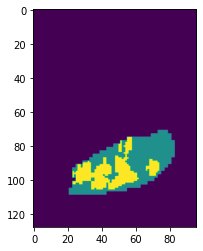

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba0_right_NC = np.zeros((128,96))
prueba0_right_NC[MASK_DCH_LUNG_ID0] = 1
prueba0_right_NC[COVID_DCH_ID0] = 0
id_nocovid_0right = np.nonzero(prueba0_right_NC)

prueba0_right_new = np.zeros((128,96))
prueba0_right_new[id_nocovid_0right] = 1
prueba0_right_new[COVID_DCH_ID0_NEW] = 2
plt.imshow(prueba0_right_new)

ctr_lung_total = PROJ_T_0[COVID_DCH_ID0_NEW].mean()/PROJ_T_0[id_nocovid_0right].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_0[COVID_DCH_ID0_NEW].mean()/PROJ_NS_ESTIM_HE_0[id_nocovid_0right].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_0[COVID_DCH_ID0_NEW].mean()/PROJ_NS_REF_HE_0[id_nocovid_0right].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_0[COVID_DCH_ID0_NEW].mean()/PROJ_NS_ESTIM_DUAL_0[id_nocovid_0right].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 1- A0463 (pulmon izq)

##### Left Lung

In [ ]:
PROJ_T_1 = np.squeeze(PROJ_HE_T[1,:,:,0])
PROJ_NS_ESTIM_HE_1 = np.squeeze(Test_NS_ESTIM_HE[1,:,:])
PROJ_NS_ESTIM_DUAL_1 = np.squeeze(Test_NS_ESTIM_DUAL_HE[1,:,:])
PROJ_NS_REF_HE_1 = np.squeeze(Test_NS_REF_HE[1,:,:])

ctr_lung_total = PROJ_T_1[COVID_IZQ_ID1].mean()/PROJ_T_1[MASK_IZQ_LUNG_ID1].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_1[COVID_IZQ_ID1].mean()/PROJ_NS_ESTIM_HE_1[MASK_IZQ_LUNG_ID1].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_1[COVID_IZQ_ID1].mean()/PROJ_NS_REF_HE_1[MASK_IZQ_LUNG_ID1].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_1[COVID_IZQ_ID1].mean()/PROJ_NS_ESTIM_DUAL_1[MASK_IZQ_LUNG_ID1].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.6469124
Contraste en la imagen limpia de scatter de referencia: 0.5540650775152656
Contraste en la imagen limpia de scatter estimda SINGLE: 0.5565534459084454
Contraste en la imagen limpia de scatter estimda DUAL: 0.5572557695577005


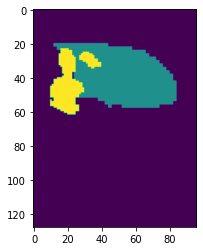

In [ ]:
# COMPROBACIÓN
prueba1_left = np.zeros((128,96))
prueba1_left[MASK_IZQ_LUNG_ID1] = 1
prueba1_left[COVID_IZQ_ID1] = 2
plt.imshow(prueba1_left)

Contraste en la imagen sin corregir: 1.0207862
Contraste en la imagen limpia de scatter de referencia: 1.0842480831594103
Contraste en la imagen limpia de scatter estimda SINGLE: 1.0773783723155683
Contraste en la imagen limpia de scatter estimda DUAL: 1.0780227665167093


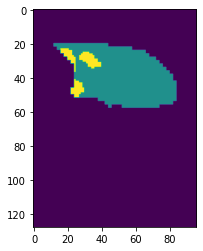

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_1NEW = np.where(MASK_IZQ_LUNG[1,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[1,:,:,0])
COVID_IZQ_ID1_NEW = np.nonzero(PROJ_MASK_IZQ_1NEW)

prueba1_left_new = np.zeros((128,96))
prueba1_left_new[MASK_IZQ_LUNG_ID1] = 1
prueba1_left_new[COVID_IZQ_ID1_NEW] = 2
plt.imshow(prueba1_left_new)

ctr_lung_total = PROJ_T_1[COVID_IZQ_ID1_NEW].mean()/PROJ_T_1[MASK_IZQ_LUNG_ID1].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_1[COVID_IZQ_ID1_NEW].mean()/PROJ_NS_ESTIM_HE_1[MASK_IZQ_LUNG_ID1].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_1[COVID_IZQ_ID1_NEW].mean()/PROJ_NS_REF_HE_1[MASK_IZQ_LUNG_ID1].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_1[COVID_IZQ_ID1_NEW].mean()/PROJ_NS_ESTIM_DUAL_1[MASK_IZQ_LUNG_ID1].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.0229826
Contraste en la imagen limpia de scatter de referencia: 1.0937661774300689
Contraste en la imagen limpia de scatter estimda SINGLE: 1.0860587453849038
Contraste en la imagen limpia de scatter estimda DUAL: 1.0867812510367987


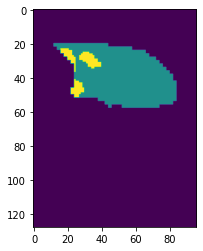

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba1_left_NC = np.zeros((128,96))
prueba1_left_NC[MASK_IZQ_LUNG_ID1] = 1
prueba1_left_NC[COVID_IZQ_ID1] = 0
id_nocovid_1left = np.nonzero(prueba1_left_NC)

prueba1_left_new = np.zeros((128,96))
prueba1_left_new[id_nocovid_1left] = 1
prueba1_left_new[COVID_IZQ_ID1_NEW] = 2
plt.imshow(prueba1_left_new)

ctr_lung_total = PROJ_T_1[COVID_IZQ_ID1_NEW].mean()/PROJ_T_1[id_nocovid_1left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_1[COVID_IZQ_ID1_NEW].mean()/PROJ_NS_ESTIM_HE_1[id_nocovid_1left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_1[COVID_IZQ_ID1_NEW].mean()/PROJ_NS_REF_HE_1[id_nocovid_1left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_1[COVID_IZQ_ID1_NEW].mean()/PROJ_NS_ESTIM_DUAL_1[id_nocovid_1left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 2 - A0464 (Pulmón dch)

In [ ]:
PROJ_T_2 = np.squeeze(PROJ_HE_T[2,:,:,0])
PROJ_NS_ESTIM_HE_2 = np.squeeze(Test_NS_ESTIM_HE[2,:,:])
PROJ_NS_ESTIM_DUAL_2 = np.squeeze(Test_NS_ESTIM_DUAL_HE[2,:,:])
PROJ_NS_REF_HE_2 = np.squeeze(Test_NS_REF_HE[2,:,:])

ctr_lung_total = PROJ_T_2[COVID_DCH_ID2].mean()/PROJ_T_2[MASK_DCH_LUNG_ID2].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_2[COVID_DCH_ID2].mean()/PROJ_NS_ESTIM_HE_2[MASK_DCH_LUNG_ID2].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_2[COVID_DCH_ID2].mean()/PROJ_NS_REF_HE_2[MASK_DCH_LUNG_ID2].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_2[COVID_DCH_ID2].mean()/PROJ_NS_ESTIM_DUAL_2[MASK_DCH_LUNG_ID2].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.83132416
Contraste en la imagen limpia de scatter de referencia: 0.7456628335913728
Contraste en la imagen limpia de scatter estimda SINGLE: 0.7308244026794325
Contraste en la imagen limpia de scatter estimda DUAL: 0.7190069131821872


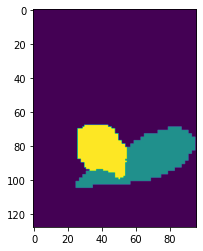

In [ ]:
# COMPROBACIÓN
prueba2_left = np.zeros((128,96))
prueba2_left[MASK_DCH_LUNG_ID2] = 1
prueba2_left[COVID_DCH_ID2] = 2
plt.imshow(prueba2_left)

Contraste en la imagen sin corregir: 1.3180947
Contraste en la imagen limpia de scatter de referencia: 1.4260087195125908
Contraste en la imagen limpia de scatter estimda SINGLE: 1.4552396095336548
Contraste en la imagen limpia de scatter estimda DUAL: 1.427507401161282


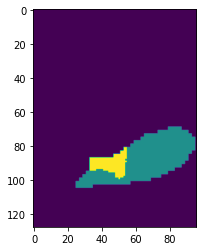

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_DCH_2NEW = np.where(MASK_DCH_LUNG[2,:,:,0] == 0,0,PROJ_MASK_DCH_ID[2,:,:,0])
COVID_DCH_ID2_NEW = np.nonzero(PROJ_MASK_DCH_2NEW)

prueba2_right_new = np.zeros((128,96))
prueba2_right_new[MASK_DCH_LUNG_ID2] = 1
prueba2_right_new[COVID_DCH_ID2_NEW] = 2
plt.imshow(prueba2_right_new)

ctr_lung_total = PROJ_T_2[COVID_DCH_ID2_NEW].mean()/PROJ_T_2[MASK_DCH_LUNG_ID2].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_2[COVID_DCH_ID2_NEW].mean()/PROJ_NS_ESTIM_HE_2[MASK_DCH_LUNG_ID2].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_2[COVID_DCH_ID2_NEW].mean()/PROJ_NS_REF_HE_2[MASK_DCH_LUNG_ID2].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_2[COVID_DCH_ID2_NEW].mean()/PROJ_NS_ESTIM_DUAL_2[MASK_DCH_LUNG_ID2].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.4046499
Contraste en la imagen limpia de scatter de referencia: 1.5542757100080455
Contraste en la imagen limpia de scatter estimda SINGLE: 1.5959860748121322
Contraste en la imagen limpia de scatter estimda DUAL: 1.5564016944127606


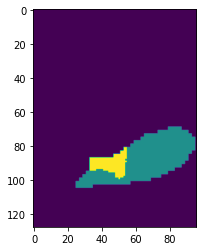

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba2_right_NC = np.zeros((128,96))
prueba2_right_NC[MASK_DCH_LUNG_ID2] = 1
prueba2_right_NC[COVID_DCH_ID2] = 0
id_nocovid_2right = np.nonzero(prueba2_right_NC)

prueba2_right_new = np.zeros((128,96))
prueba2_right_new[id_nocovid_2right] = 1
prueba2_right_new[COVID_DCH_ID2_NEW] = 2
plt.imshow(prueba2_right_new)

ctr_lung_total = PROJ_T_2[COVID_DCH_ID2_NEW].mean()/PROJ_T_2[id_nocovid_2right].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_2[COVID_DCH_ID2_NEW].mean()/PROJ_NS_ESTIM_HE_2[id_nocovid_2right].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_2[COVID_DCH_ID2_NEW].mean()/PROJ_NS_REF_HE_2[id_nocovid_2right].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_2[COVID_DCH_ID2_NEW].mean()/PROJ_NS_ESTIM_DUAL_2[id_nocovid_2right].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 3 - A0472 (Pulmón dch)

In [ ]:
PROJ_T_3 = np.squeeze(PROJ_HE_T[3,:,:,0])
PROJ_NS_ESTIM_HE_3 = np.squeeze(Test_NS_ESTIM_HE[3,:,:])
PROJ_NS_ESTIM_DUAL_3 = np.squeeze(Test_NS_ESTIM_DUAL_HE[3,:,:])
PROJ_NS_REF_HE_3 = np.squeeze(Test_NS_REF_HE[3,:,:])

ctr_lung_total = PROJ_T_3[COVID_DCH_ID3].mean()/PROJ_T_3[MASK_DCH_LUNG_ID3].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_3[COVID_DCH_ID3].mean()/PROJ_NS_ESTIM_HE_3[MASK_DCH_LUNG_ID3].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_3[COVID_DCH_ID3].mean()/PROJ_NS_REF_HE_3[MASK_DCH_LUNG_ID3].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_3[COVID_DCH_ID3].mean()/PROJ_NS_ESTIM_DUAL_3[MASK_DCH_LUNG_ID3].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.0298694
Contraste en la imagen limpia de scatter de referencia: 1.0317093098034562
Contraste en la imagen limpia de scatter estimda SINGLE: 1.013959087340279
Contraste en la imagen limpia de scatter estimda DUAL: 1.0150451687006972


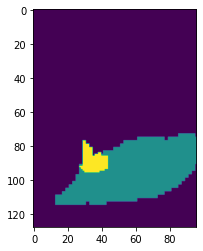

In [ ]:
# COMPROBACIÓN
prueba3_left = np.zeros((128,96))
prueba3_left[MASK_DCH_LUNG_ID3] = 1
prueba3_left[COVID_DCH_ID3] = 2
plt.imshow(prueba3_left)

Contraste en la imagen sin corregir: 1.228616
Contraste en la imagen limpia de scatter de referencia: 1.3537104964806705
Contraste en la imagen limpia de scatter estimda SINGLE: 1.3408825918477005
Contraste en la imagen limpia de scatter estimda DUAL: 1.3398924545087139


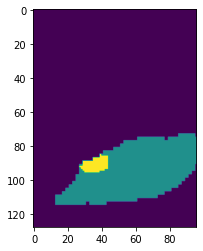

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_DCH_3NEW = np.where(MASK_DCH_LUNG[3,:,:,0] == 0,0,PROJ_MASK_DCH_ID[3,:,:,0])
COVID_DCH_ID3_NEW = np.nonzero(PROJ_MASK_DCH_3NEW)

prueba3_right_new = np.zeros((128,96))
prueba3_right_new[MASK_DCH_LUNG_ID3] = 1
prueba3_right_new[COVID_DCH_ID3_NEW] = 2
plt.imshow(prueba3_right_new)

ctr_lung_total = PROJ_T_3[COVID_DCH_ID3_NEW].mean()/PROJ_T_3[MASK_DCH_LUNG_ID3].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_3[COVID_DCH_ID3_NEW].mean()/PROJ_NS_ESTIM_HE_3[MASK_DCH_LUNG_ID3].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_3[COVID_DCH_ID3_NEW].mean()/PROJ_NS_REF_HE_3[MASK_DCH_LUNG_ID3].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_3[COVID_DCH_ID3_NEW].mean()/PROJ_NS_ESTIM_DUAL_3[MASK_DCH_LUNG_ID3].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.2450166
Contraste en la imagen limpia de scatter de referencia: 1.3818746045208414
Contraste en la imagen limpia de scatter estimda SINGLE: 1.3677478035660682
Contraste en la imagen limpia de scatter estimda DUAL: 1.366658294865237


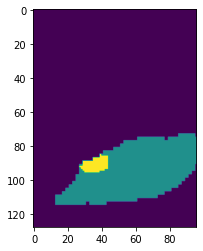

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba3_right_NC = np.zeros((128,96))
prueba3_right_NC[MASK_DCH_LUNG_ID3] = 1
prueba3_right_NC[COVID_DCH_ID3] = 0
id_nocovid_3right = np.nonzero(prueba3_right_NC)

prueba3_right_new = np.zeros((128,96))
prueba3_right_new[id_nocovid_3right] = 1
prueba3_right_new[COVID_DCH_ID3_NEW] = 2
plt.imshow(prueba3_right_new)

ctr_lung_total = PROJ_T_3[COVID_DCH_ID3_NEW].mean()/PROJ_T_3[id_nocovid_3right].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_3[COVID_DCH_ID3_NEW].mean()/PROJ_NS_ESTIM_HE_3[id_nocovid_3right].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_3[COVID_DCH_ID3_NEW].mean()/PROJ_NS_REF_HE_3[id_nocovid_3right].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_3[COVID_DCH_ID3_NEW].mean()/PROJ_NS_ESTIM_DUAL_3[id_nocovid_3right].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 4 - A0473 (Pulmón izq)

In [ ]:
PROJ_T_4 = np.squeeze(PROJ_HE_T[4,:,:,0])
PROJ_NS_ESTIM_HE_4 = np.squeeze(Test_NS_ESTIM_HE[4,:,:])
PROJ_NS_ESTIM_DUAL_4 = np.squeeze(Test_NS_ESTIM_DUAL_HE[4,:,:])
PROJ_NS_REF_HE_4 = np.squeeze(Test_NS_REF_HE[4,:,:])

ctr_lung_total = PROJ_T_4[COVID_IZQ_ID4].mean()/PROJ_T_4[MASK_IZQ_LUNG_ID4].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_4[COVID_IZQ_ID4].mean()/PROJ_NS_ESTIM_HE_4[MASK_IZQ_LUNG_ID4].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_4[COVID_IZQ_ID4].mean()/PROJ_NS_REF_HE_4[MASK_IZQ_LUNG_ID4].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_4[COVID_IZQ_ID4].mean()/PROJ_NS_ESTIM_DUAL_4[MASK_IZQ_LUNG_ID4].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.0024236
Contraste en la imagen limpia de scatter de referencia: 0.9860647765006479
Contraste en la imagen limpia de scatter estimda SINGLE: 0.9910644287089305
Contraste en la imagen limpia de scatter estimda DUAL: 0.9972175719004406


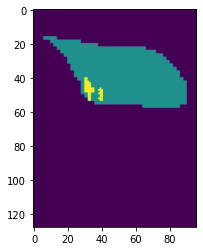

In [ ]:
# COMPROBACIÓN
prueba4_right = np.zeros((128,96))
prueba4_right[MASK_IZQ_LUNG_ID4] = 1
prueba4_right[COVID_IZQ_ID4] = 2
plt.imshow(prueba4_right)

Contraste en la imagen sin corregir: 1.0024236
Contraste en la imagen limpia de scatter de referencia: 0.9860647765006479
Contraste en la imagen limpia de scatter estimda SINGLE: 0.9910644287089305
Contraste en la imagen limpia de scatter estimda DUAL: 0.9972175719004406


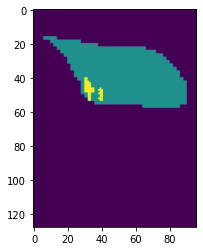

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_4NEW = np.where(MASK_IZQ_LUNG[4,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[4,:,:,0])
COVID_IZQ_ID4_NEW = np.nonzero(PROJ_MASK_IZQ_4NEW)

prueba4_left_new = np.zeros((128,96))
prueba4_left_new[MASK_IZQ_LUNG_ID4] = 1
prueba4_left_new[COVID_IZQ_ID4_NEW] = 2
plt.imshow(prueba4_left_new)

ctr_lung_total = PROJ_T_4[COVID_IZQ_ID4_NEW].mean()/PROJ_T_4[MASK_IZQ_LUNG_ID4].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_4[COVID_IZQ_ID4_NEW].mean()/PROJ_NS_ESTIM_HE_4[MASK_IZQ_LUNG_ID4].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_4[COVID_IZQ_ID4_NEW].mean()/PROJ_NS_REF_HE_4[MASK_IZQ_LUNG_ID4].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_4[COVID_IZQ_ID4_NEW].mean()/PROJ_NS_ESTIM_DUAL_4[MASK_IZQ_LUNG_ID4].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.0024986
Contraste en la imagen limpia de scatter de referencia: 0.985641053983073
Contraste en la imagen limpia de scatter estimda SINGLE: 0.9907913088160298
Contraste en la imagen limpia de scatter estimda DUAL: 0.997131981429218


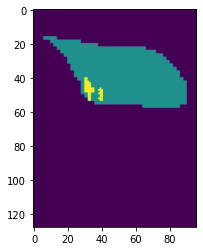

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba4_left_NC = np.zeros((128,96))
prueba4_left_NC[MASK_IZQ_LUNG_ID4] = 1
prueba4_left_NC[COVID_IZQ_ID4] = 0
id_nocovid_4left = np.nonzero(prueba4_left_NC)

prueba4_left_new = np.zeros((128,96))
prueba4_left_new[id_nocovid_4left] = 1
prueba4_left_new[COVID_IZQ_ID4_NEW] = 2
plt.imshow(prueba4_left_new)

ctr_lung_total = PROJ_T_4[COVID_IZQ_ID4_NEW].mean()/PROJ_T_4[id_nocovid_4left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_4[COVID_IZQ_ID4_NEW].mean()/PROJ_NS_ESTIM_HE_4[id_nocovid_4left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_4[COVID_IZQ_ID4_NEW].mean()/PROJ_NS_REF_HE_4[id_nocovid_4left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_4[COVID_IZQ_ID4_NEW].mean()/PROJ_NS_ESTIM_DUAL_4[id_nocovid_4left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 5 - A0476 (2 pulmones)

##### Left lung

In [ ]:
PROJ_T_5 = np.squeeze(PROJ_HE_T[5,:,:,0])
PROJ_NS_ESTIM_HE_5 = np.squeeze(Test_NS_ESTIM_HE[5,:,:])
PROJ_NS_ESTIM_DUAL_5 = np.squeeze(Test_NS_ESTIM_DUAL_HE[5,:,:])
PROJ_NS_REF_HE_5 = np.squeeze(Test_NS_REF_HE[5,:,:])

ctr_lung_total = PROJ_T_5[COVID_IZQ_ID5].mean()/PROJ_T_5[MASK_IZQ_LUNG_ID5].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_5[COVID_IZQ_ID5].mean()/PROJ_NS_ESTIM_HE_5[MASK_IZQ_LUNG_ID5].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_5[COVID_IZQ_ID5].mean()/PROJ_NS_REF_HE_5[MASK_IZQ_LUNG_ID5].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_5[COVID_IZQ_ID5].mean()/PROJ_NS_ESTIM_DUAL_5[MASK_IZQ_LUNG_ID5].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.99587244
Contraste en la imagen limpia de scatter de referencia: 0.9969901963796051
Contraste en la imagen limpia de scatter estimda SINGLE: 1.0006440625258683
Contraste en la imagen limpia de scatter estimda DUAL: 1.001235934005154


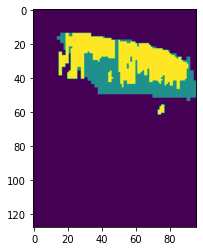

In [ ]:
# COMPROBACIÓN
prueba5_left = np.zeros((128,96))
prueba5_left[MASK_IZQ_LUNG_ID5] = 1
prueba5_left[COVID_IZQ_ID5] = 2
plt.imshow(prueba5_left)

Contraste en la imagen sin corregir: 1.071389
Contraste en la imagen limpia de scatter de referencia: 1.101458449636626
Contraste en la imagen limpia de scatter estimda SINGLE: 1.1022770398901225
Contraste en la imagen limpia de scatter estimda DUAL: 1.1023409093706458


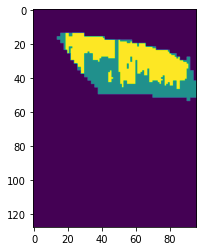

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_5NEW = np.where(MASK_IZQ_LUNG[5,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[5,:,:,0])
COVID_IZQ_ID5_NEW = np.nonzero(PROJ_MASK_IZQ_5NEW)

prueba5_left_new = np.zeros((128,96))
prueba5_left_new[MASK_IZQ_LUNG_ID5] = 1
prueba5_left_new[COVID_IZQ_ID5_NEW] = 2
plt.imshow(prueba5_left_new)

ctr_lung_total = PROJ_T_5[COVID_IZQ_ID5_NEW].mean()/PROJ_T_5[MASK_IZQ_LUNG_ID5].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_5[COVID_IZQ_ID5_NEW].mean()/PROJ_NS_ESTIM_HE_5[MASK_IZQ_LUNG_ID5].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_5[COVID_IZQ_ID5_NEW].mean()/PROJ_NS_REF_HE_5[MASK_IZQ_LUNG_ID5].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_5[COVID_IZQ_ID5_NEW].mean()/PROJ_NS_ESTIM_DUAL_5[MASK_IZQ_LUNG_ID5].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.1744245
Contraste en la imagen limpia de scatter de referencia: 1.2583588306500453
Contraste en la imagen limpia de scatter estimda SINGLE: 1.260743001989293
Contraste en la imagen limpia de scatter estimda DUAL: 1.260929254738092


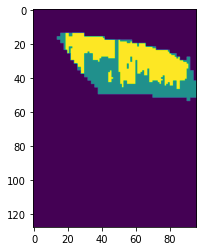

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba5_left_NC = np.zeros((128,96))
prueba5_left_NC[MASK_IZQ_LUNG_ID5] = 1
prueba5_left_NC[COVID_IZQ_ID5] = 0
id_nocovid_5left = np.nonzero(prueba5_left_NC)

prueba5_left_new = np.zeros((128,96))
prueba5_left_new[id_nocovid_5left] = 1
prueba5_left_new[COVID_IZQ_ID5_NEW] = 2
plt.imshow(prueba5_left_new)

ctr_lung_total = PROJ_T_5[COVID_IZQ_ID5_NEW].mean()/PROJ_T_5[id_nocovid_5left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_5[COVID_IZQ_ID5_NEW].mean()/PROJ_NS_ESTIM_HE_5[id_nocovid_5left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_5[COVID_IZQ_ID5_NEW].mean()/PROJ_NS_REF_HE_5[id_nocovid_5left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_5[COVID_IZQ_ID5_NEW].mean()/PROJ_NS_ESTIM_DUAL_5[id_nocovid_5left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

##### Right Lung

In [ ]:
ctr_lung_total = PROJ_T_5[COVID_DCH_ID5].mean()/PROJ_T_5[MASK_DCH_LUNG_ID5].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_5[COVID_DCH_ID5].mean()/PROJ_NS_ESTIM_HE_5[MASK_DCH_LUNG_ID5].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_5[COVID_DCH_ID5].mean()/PROJ_NS_REF_HE_5[MASK_DCH_LUNG_ID5].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_5[COVID_DCH_ID5].mean()/PROJ_NS_ESTIM_DUAL_5[MASK_DCH_LUNG_ID5].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.8748446
Contraste en la imagen limpia de scatter de referencia: 0.7934121889770224
Contraste en la imagen limpia de scatter estimda SINGLE: 0.7865950688687786
Contraste en la imagen limpia de scatter estimda DUAL: 0.795211658739165


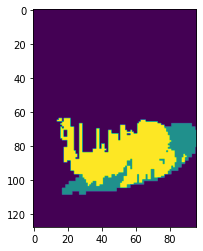

In [ ]:
# COMPROBACIÓN
prueba5_right = np.zeros((128,96))
prueba5_right[MASK_DCH_LUNG_ID5] = 1
prueba5_right[COVID_DCH_ID5] = 2
plt.imshow(prueba5_right)

Contraste en la imagen sin corregir: 1.1195908
Contraste en la imagen limpia de scatter de referencia: 1.1726361153238498
Contraste en la imagen limpia de scatter estimda SINGLE: 1.1668954629163182
Contraste en la imagen limpia de scatter estimda DUAL: 1.1659242198519209


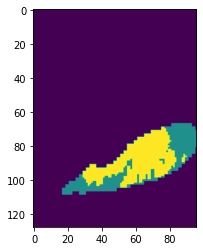

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_DCH_5NEW = np.where(MASK_DCH_LUNG[5,:,:,0] == 0,0,PROJ_MASK_DCH_ID[5,:,:,0])
COVID_DCH_ID5_NEW = np.nonzero(PROJ_MASK_DCH_5NEW)

prueba5_right_new = np.zeros((128,96))
prueba5_right_new[MASK_DCH_LUNG_ID5] = 1
prueba5_right_new[COVID_DCH_ID5_NEW] = 2
plt.imshow(prueba5_right_new)

ctr_lung_total = PROJ_T_5[COVID_DCH_ID5_NEW].mean()/PROJ_T_5[MASK_DCH_LUNG_ID5].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_5[COVID_DCH_ID5_NEW].mean()/PROJ_NS_ESTIM_HE_5[MASK_DCH_LUNG_ID5].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_5[COVID_DCH_ID5_NEW].mean()/PROJ_NS_REF_HE_5[MASK_DCH_LUNG_ID5].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_5[COVID_DCH_ID5_NEW].mean()/PROJ_NS_ESTIM_DUAL_5[MASK_DCH_LUNG_ID5].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.3439131
Contraste en la imagen limpia de scatter de referencia: 1.5448831619000827
Contraste en la imagen limpia de scatter estimda SINGLE: 1.5212617968265463
Contraste en la imagen limpia de scatter estimda DUAL: 1.5173140938903684


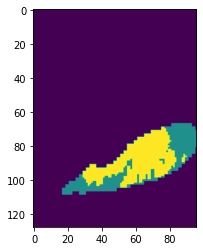

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba5_right_NC = np.zeros((128,96))
prueba5_right_NC[MASK_DCH_LUNG_ID5] = 1
prueba5_right_NC[COVID_DCH_ID5] = 0
id_nocovid_5right = np.nonzero(prueba5_right_NC)

prueba5_right_new = np.zeros((128,96))
prueba5_right_new[id_nocovid_5right] = 1
prueba5_right_new[COVID_DCH_ID5_NEW] = 2
plt.imshow(prueba5_right_new)

ctr_lung_total = PROJ_T_5[COVID_DCH_ID5_NEW].mean()/PROJ_T_5[id_nocovid_5right].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_5[COVID_DCH_ID5_NEW].mean()/PROJ_NS_ESTIM_HE_5[id_nocovid_5right].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_5[COVID_DCH_ID5_NEW].mean()/PROJ_NS_REF_HE_5[id_nocovid_5right].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_5[COVID_DCH_ID5_NEW].mean()/PROJ_NS_ESTIM_DUAL_5[id_nocovid_5right].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 6 - A0483 (pulmón dch)

In [ ]:
PROJ_T_6 = np.squeeze(PROJ_HE_T[6,:,:,0])
PROJ_NS_ESTIM_HE_6 = np.squeeze(Test_NS_ESTIM_HE[6,:,:])
PROJ_NS_ESTIM_DUAL_6 = np.squeeze(Test_NS_ESTIM_DUAL_HE[6,:,:])
PROJ_NS_REF_HE_6 = np.squeeze(Test_NS_REF_HE[6,:,:])

ctr_lung_total = PROJ_T_6[COVID_DCH_ID6].mean()/PROJ_T_6[MASK_DCH_LUNG_ID6].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_6[COVID_DCH_ID6].mean()/PROJ_NS_ESTIM_HE_6[MASK_DCH_LUNG_ID6].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_6[COVID_DCH_ID6].mean()/PROJ_NS_REF_HE_6[MASK_DCH_LUNG_ID6].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_6[COVID_DCH_ID6].mean()/PROJ_NS_ESTIM_DUAL_6[MASK_DCH_LUNG_ID6].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.5899027
Contraste en la imagen limpia de scatter de referencia: 0.47074105402075106
Contraste en la imagen limpia de scatter estimda SINGLE: 0.4748516365953938
Contraste en la imagen limpia de scatter estimda DUAL: 0.4657497528097486


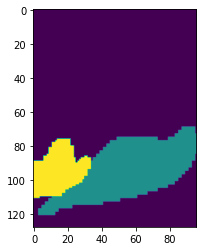

In [ ]:
# COMPROBACIÓN
prueba6_right = np.zeros((128,96))
prueba6_right[MASK_DCH_LUNG_ID6] = 1
prueba6_right[COVID_DCH_ID6] = 2
plt.imshow(prueba6_right)

Contraste en la imagen sin corregir: 1.1486549
Contraste en la imagen limpia de scatter de referencia: 1.3350947375909985
Contraste en la imagen limpia de scatter estimda SINGLE: 1.3195179596661808
Contraste en la imagen limpia de scatter estimda DUAL: 1.3157793899820294


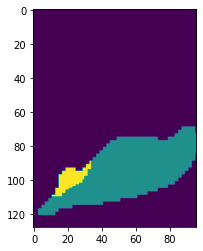

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_DCH_6NEW = np.where(MASK_DCH_LUNG[6,:,:,0] == 0,0,PROJ_MASK_DCH_ID[6,:,:,0])
COVID_DCH_ID6_NEW = np.nonzero(PROJ_MASK_DCH_6NEW)

prueba6_right_new = np.zeros((128,96))
prueba6_right_new[MASK_DCH_LUNG_ID6] = 1
prueba6_right_new[COVID_DCH_ID6_NEW] = 2
plt.imshow(prueba6_right_new)

ctr_lung_total = PROJ_T_6[COVID_DCH_ID6_NEW].mean()/PROJ_T_6[MASK_DCH_LUNG_ID6].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_6[COVID_DCH_ID6_NEW].mean()/PROJ_NS_ESTIM_HE_6[MASK_DCH_LUNG_ID6].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_6[COVID_DCH_ID6_NEW].mean()/PROJ_NS_REF_HE_6[MASK_DCH_LUNG_ID6].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_6[COVID_DCH_ID6_NEW].mean()/PROJ_NS_ESTIM_DUAL_6[MASK_DCH_LUNG_ID6].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.1634843
Contraste en la imagen limpia de scatter de referencia: 1.3745879025362477
Contraste en la imagen limpia de scatter estimda SINGLE: 1.3566848356891132
Contraste en la imagen limpia de scatter estimda DUAL: 1.3523952493982112


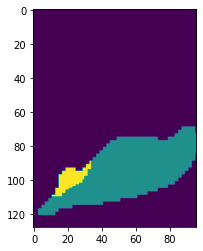

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba6_right_NC = np.zeros((128,96))
prueba6_right_NC[MASK_DCH_LUNG_ID6] = 1
prueba6_right_NC[COVID_DCH_ID6] = 0
id_nocovid_6right = np.nonzero(prueba6_right_NC)

prueba6_right_new = np.zeros((128,96))
prueba6_right_new[id_nocovid_6right] = 1
prueba6_right_new[COVID_DCH_ID6_NEW] = 2
plt.imshow(prueba6_right_new)

ctr_lung_total = PROJ_T_6[COVID_DCH_ID6_NEW].mean()/PROJ_T_6[id_nocovid_6right].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_6[COVID_DCH_ID6_NEW].mean()/PROJ_NS_ESTIM_HE_6[id_nocovid_6right].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_6[COVID_DCH_ID6_NEW].mean()/PROJ_NS_REF_HE_6[id_nocovid_6right].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_6[COVID_DCH_ID6_NEW].mean()/PROJ_NS_ESTIM_DUAL_6[id_nocovid_6right].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 7 - A0494

##### Left Lung

In [ ]:
PROJ_T_7 = np.squeeze(PROJ_HE_T[7,:,:,0])
PROJ_NS_ESTIM_HE_7 = np.squeeze(Test_NS_ESTIM_HE[7,:,:])
PROJ_NS_ESTIM_DUAL_7 = np.squeeze(Test_NS_ESTIM_DUAL_HE[7,:,:])
PROJ_NS_REF_HE_7 = np.squeeze(Test_NS_REF_HE[7,:,:])

ctr_lung_total = PROJ_T_7[COVID_IZQ_ID7].mean()/PROJ_T_7[MASK_IZQ_LUNG_ID7].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_7[COVID_IZQ_ID7].mean()/PROJ_NS_ESTIM_HE_7[MASK_IZQ_LUNG_ID7].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_7[COVID_IZQ_ID7].mean()/PROJ_NS_REF_HE_7[MASK_IZQ_LUNG_ID7].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_7[COVID_IZQ_ID7].mean()/PROJ_NS_ESTIM_DUAL_7[MASK_IZQ_LUNG_ID7].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.74954927
Contraste en la imagen limpia de scatter de referencia: 0.7120749143494867
Contraste en la imagen limpia de scatter estimda SINGLE: 0.7205621016275449
Contraste en la imagen limpia de scatter estimda DUAL: 0.706946917085783


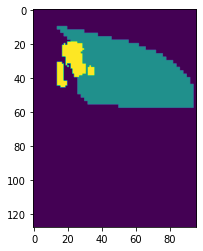

In [ ]:
# COMPROBACIÓN
prueba7_left = np.zeros((128,96))
prueba7_left[MASK_IZQ_LUNG_ID7] = 1
prueba7_left[COVID_IZQ_ID7] = 2
plt.imshow(prueba7_left)

Contraste en la imagen sin corregir: 1.3475376
Contraste en la imagen limpia de scatter de referencia: 1.578058874687415
Contraste en la imagen limpia de scatter estimda SINGLE: 1.5737557208816122
Contraste en la imagen limpia de scatter estimda DUAL: 1.5510122079004234


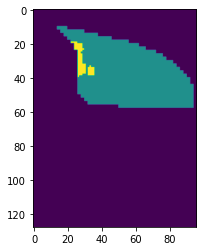

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_7NEW = np.where(MASK_IZQ_LUNG[7,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[7,:,:,0])
COVID_IZQ_ID7_NEW = np.nonzero(PROJ_MASK_IZQ_7NEW)

prueba7_left_new = np.zeros((128,96))
prueba7_left_new[MASK_IZQ_LUNG_ID7] = 1
prueba7_left_new[COVID_IZQ_ID7_NEW] = 2
plt.imshow(prueba7_left_new)

ctr_lung_total = PROJ_T_7[COVID_IZQ_ID7_NEW].mean()/PROJ_T_7[MASK_IZQ_LUNG_ID7].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_7[COVID_IZQ_ID7_NEW].mean()/PROJ_NS_ESTIM_HE_7[MASK_IZQ_LUNG_ID7].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_7[COVID_IZQ_ID7_NEW].mean()/PROJ_NS_REF_HE_7[MASK_IZQ_LUNG_ID7].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_7[COVID_IZQ_ID7_NEW].mean()/PROJ_NS_ESTIM_DUAL_7[MASK_IZQ_LUNG_ID7].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.3688701
Contraste en la imagen limpia de scatter de referencia: 1.6200519066220898
Contraste en la imagen limpia de scatter estimda SINGLE: 1.615314261254665
Contraste en la imagen limpia de scatter estimda DUAL: 1.5903054623973238


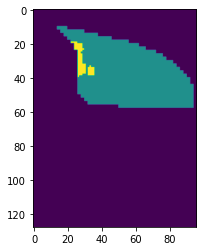

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba7_left_NC = np.zeros((128,96))
prueba7_left_NC[MASK_IZQ_LUNG_ID7] = 1
prueba7_left_NC[COVID_IZQ_ID7] = 0
id_nocovid_7left = np.nonzero(prueba7_left_NC)

prueba7_left_new = np.zeros((128,96))
prueba7_left_new[id_nocovid_7left] = 1
prueba7_left_new[COVID_IZQ_ID7_NEW] = 2
plt.imshow(prueba7_left_new)

ctr_lung_total = PROJ_T_7[COVID_IZQ_ID7_NEW].mean()/PROJ_T_7[id_nocovid_7left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_7[COVID_IZQ_ID7_NEW].mean()/PROJ_NS_ESTIM_HE_7[id_nocovid_7left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_7[COVID_IZQ_ID7_NEW].mean()/PROJ_NS_REF_HE_7[id_nocovid_7left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_7[COVID_IZQ_ID7_NEW].mean()/PROJ_NS_ESTIM_DUAL_7[id_nocovid_7left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

##### Right Lung

In [ ]:
ctr_lung_total = PROJ_T_7[COVID_DCH_ID7].mean()/PROJ_T_7[MASK_DCH_LUNG_ID7].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_7[COVID_DCH_ID7].mean()/PROJ_NS_ESTIM_HE_7[MASK_DCH_LUNG_ID7].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_7[COVID_DCH_ID7].mean()/PROJ_NS_REF_HE_7[MASK_DCH_LUNG_ID7].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_7[COVID_DCH_ID7].mean()/PROJ_NS_ESTIM_DUAL_7[MASK_DCH_LUNG_ID7].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.9218775
Contraste en la imagen limpia de scatter de referencia: 0.8947621161556729
Contraste en la imagen limpia de scatter estimda SINGLE: 0.8937834453865737
Contraste en la imagen limpia de scatter estimda DUAL: 0.8923421842395888


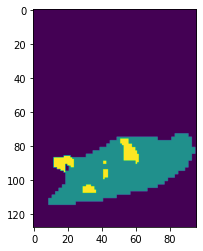

In [ ]:
# COMPROBACIÓN
prueba7_right = np.zeros((128,96))
prueba7_right[MASK_DCH_LUNG_ID7] = 1
prueba7_right[COVID_DCH_ID7] = 2
plt.imshow(prueba7_right)

Contraste en la imagen sin corregir: 1.1553288
Contraste en la imagen limpia de scatter de referencia: 1.1995853831722358
Contraste en la imagen limpia de scatter estimda SINGLE: 1.1959692939379374
Contraste en la imagen limpia de scatter estimda DUAL: 1.1928847211636344


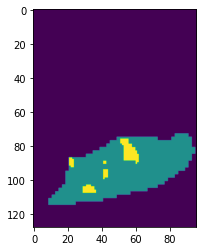

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_DCH_7NEW = np.where(MASK_DCH_LUNG[7,:,:,0] == 0,0,PROJ_MASK_DCH_ID[7,:,:,0])
COVID_DCH_ID7_NEW = np.nonzero(PROJ_MASK_DCH_7NEW)

prueba7_right_new = np.zeros((128,96))
prueba7_right_new[MASK_DCH_LUNG_ID7] = 1
prueba7_right_new[COVID_DCH_ID7_NEW] = 2
plt.imshow(prueba7_right_new)

ctr_lung_total = PROJ_T_7[COVID_DCH_ID7_NEW].mean()/PROJ_T_7[MASK_DCH_LUNG_ID7].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_7[COVID_DCH_ID7_NEW].mean()/PROJ_NS_ESTIM_HE_7[MASK_DCH_LUNG_ID7].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_7[COVID_DCH_ID7_NEW].mean()/PROJ_NS_REF_HE_7[MASK_DCH_LUNG_ID7].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_7[COVID_DCH_ID7_NEW].mean()/PROJ_NS_ESTIM_DUAL_7[MASK_DCH_LUNG_ID7].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.1701739
Contraste en la imagen limpia de scatter de referencia: 1.2194636134810197
Contraste en la imagen limpia de scatter estimda SINGLE: 1.2154226935610966
Contraste en la imagen limpia de scatter estimda DUAL: 1.2119776510894609


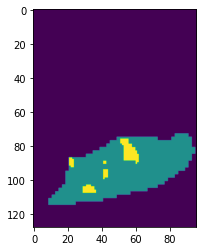

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba7_right_NC = np.zeros((128,96))
prueba7_right_NC[MASK_DCH_LUNG_ID7] = 1
prueba7_right_NC[COVID_DCH_ID7] = 0
id_nocovid_7right = np.nonzero(prueba7_right_NC)

prueba7_right_new = np.zeros((128,96))
prueba7_right_new[id_nocovid_7right] = 1
prueba7_right_new[COVID_DCH_ID7_NEW] = 2
plt.imshow(prueba7_right_new)

ctr_lung_total = PROJ_T_7[COVID_DCH_ID7_NEW].mean()/PROJ_T_7[id_nocovid_7right].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_7[COVID_DCH_ID7_NEW].mean()/PROJ_NS_ESTIM_HE_7[id_nocovid_7right].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_7[COVID_DCH_ID7_NEW].mean()/PROJ_NS_REF_HE_7[id_nocovid_7right].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_7[COVID_DCH_ID7_NEW].mean()/PROJ_NS_ESTIM_DUAL_7[id_nocovid_7right].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 8 - A0495 (Pulmón Izq)

In [ ]:
PROJ_T_8 = np.squeeze(PROJ_HE_T[8,:,:,0])
PROJ_NS_ESTIM_HE_8 = np.squeeze(Test_NS_ESTIM_HE[8,:,:])
PROJ_NS_ESTIM_DUAL_8 = np.squeeze(Test_NS_ESTIM_DUAL_HE[8,:,:])
PROJ_NS_REF_HE_8 = np.squeeze(Test_NS_REF_HE[8,:,:])

ctr_lung_total = PROJ_T_8[COVID_IZQ_ID8].mean()/PROJ_T_8[MASK_IZQ_LUNG_ID8].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_8[COVID_IZQ_ID8].mean()/PROJ_NS_ESTIM_HE_8[MASK_IZQ_LUNG_ID8].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_8[COVID_IZQ_ID8].mean()/PROJ_NS_REF_HE_8[MASK_IZQ_LUNG_ID8].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_8[COVID_IZQ_ID8].mean()/PROJ_NS_ESTIM_DUAL_8[MASK_IZQ_LUNG_ID8].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.9006325
Contraste en la imagen limpia de scatter de referencia: 0.8896998295237514
Contraste en la imagen limpia de scatter estimda SINGLE: 0.887267976376832
Contraste en la imagen limpia de scatter estimda DUAL: 0.8879647710144318


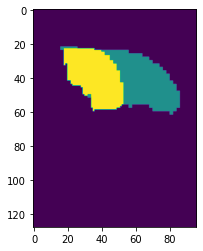

In [ ]:
# COMPROBACIÓN
prueba8_left = np.zeros((128,96))
prueba8_left[MASK_IZQ_LUNG_ID8] = 1
prueba8_left[COVID_IZQ_ID8] = 2
plt.imshow(prueba8_left)

Contraste en la imagen sin corregir: 1.043588
Contraste en la imagen limpia de scatter de referencia: 1.1157205107061963
Contraste en la imagen limpia de scatter estimda SINGLE: 1.1079362656311158
Contraste en la imagen limpia de scatter estimda DUAL: 1.1111938357134363


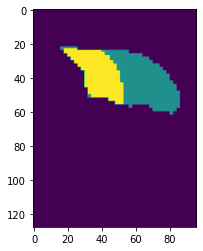

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_8NEW = np.where(MASK_IZQ_LUNG[8,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[8,:,:,0])
COVID_IZQ_ID8_NEW = np.nonzero(PROJ_MASK_IZQ_8NEW)

prueba8_left_new = np.zeros((128,96))
prueba8_left_new[MASK_IZQ_LUNG_ID8] = 1
prueba8_left_new[COVID_IZQ_ID8_NEW] = 2
plt.imshow(prueba8_left_new)

ctr_lung_total = PROJ_T_8[COVID_IZQ_ID8_NEW].mean()/PROJ_T_8[MASK_IZQ_LUNG_ID8].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_8[COVID_IZQ_ID8_NEW].mean()/PROJ_NS_ESTIM_HE_8[MASK_IZQ_LUNG_ID8].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_8[COVID_IZQ_ID8_NEW].mean()/PROJ_NS_REF_HE_8[MASK_IZQ_LUNG_ID8].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_8[COVID_IZQ_ID8_NEW].mean()/PROJ_NS_ESTIM_DUAL_8[MASK_IZQ_LUNG_ID8].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.0747386
Contraste en la imagen limpia de scatter de referencia: 1.2087308871191085
Contraste en la imagen limpia de scatter estimda SINGLE: 1.1936043852511038
Contraste en la imagen limpia de scatter estimda DUAL: 1.1999139857386236


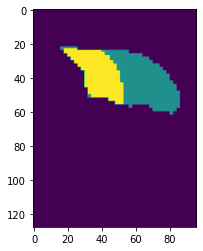

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba8_left_NC = np.zeros((128,96))
prueba8_left_NC[MASK_IZQ_LUNG_ID8] = 1
prueba8_left_NC[COVID_IZQ_ID8] = 0
id_nocovid_8left = np.nonzero(prueba8_left_NC)

prueba8_left_new = np.zeros((128,96))
prueba8_left_new[id_nocovid_8left] = 1
prueba8_left_new[COVID_IZQ_ID8_NEW] = 2
plt.imshow(prueba8_left_new)

ctr_lung_total = PROJ_T_8[COVID_IZQ_ID8_NEW].mean()/PROJ_T_8[id_nocovid_8left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_8[COVID_IZQ_ID8_NEW].mean()/PROJ_NS_ESTIM_HE_8[id_nocovid_8left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_8[COVID_IZQ_ID8_NEW].mean()/PROJ_NS_REF_HE_8[id_nocovid_8left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_8[COVID_IZQ_ID8_NEW].mean()/PROJ_NS_ESTIM_DUAL_8[id_nocovid_8left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 9 - A0500 (Pulmón izq)

In [ ]:
PROJ_T_9 = np.squeeze(PROJ_HE_T[9,:,:,0])
PROJ_NS_ESTIM_HE_9 = np.squeeze(Test_NS_ESTIM_HE[9,:,:])
PROJ_NS_ESTIM_DUAL_9 = np.squeeze(Test_NS_ESTIM_DUAL_HE[9,:,:])
PROJ_NS_REF_HE_9 = np.squeeze(Test_NS_REF_HE[9,:,:])

ctr_lung_total = PROJ_T_9[COVID_IZQ_ID9].mean()/PROJ_T_9[MASK_IZQ_LUNG_ID9].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_9[COVID_IZQ_ID9].mean()/PROJ_NS_ESTIM_HE_9[MASK_IZQ_LUNG_ID9].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_9[COVID_IZQ_ID9].mean()/PROJ_NS_REF_HE_9[MASK_IZQ_LUNG_ID9].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_9[COVID_IZQ_ID9].mean()/PROJ_NS_ESTIM_DUAL_9[MASK_IZQ_LUNG_ID9].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.6861355
Contraste en la imagen limpia de scatter de referencia: 0.5052050873086716
Contraste en la imagen limpia de scatter estimda SINGLE: 0.5132682155008034
Contraste en la imagen limpia de scatter estimda DUAL: 0.5107574614408938


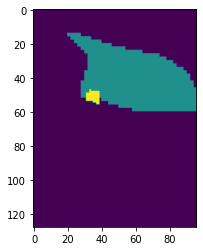

In [ ]:
# COMPROBACIÓN
prueba9_left = np.zeros((128,96))
prueba9_left[MASK_IZQ_LUNG_ID9] = 1
prueba9_left[COVID_IZQ_ID9] = 2
plt.imshow(prueba9_left)

Contraste en la imagen sin corregir: 0.75526243
Contraste en la imagen limpia de scatter de referencia: 0.6144863445955768
Contraste en la imagen limpia de scatter estimda SINGLE: 0.6227601745827138
Contraste en la imagen limpia de scatter estimda DUAL: 0.6220691597961997


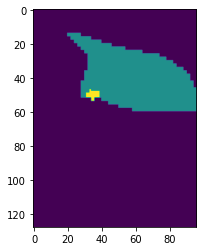

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_9NEW = np.where(MASK_IZQ_LUNG[9,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[9,:,:,0])
COVID_IZQ_ID9_NEW = np.nonzero(PROJ_MASK_IZQ_9NEW)

prueba9_left_new = np.zeros((128,96))
prueba9_left_new[MASK_IZQ_LUNG_ID9] = 1
prueba9_left_new[COVID_IZQ_ID9_NEW] = 2
plt.imshow(prueba9_left_new)

ctr_lung_total = PROJ_T_9[COVID_IZQ_ID9_NEW].mean()/PROJ_T_9[MASK_IZQ_LUNG_ID9].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_9[COVID_IZQ_ID9_NEW].mean()/PROJ_NS_ESTIM_HE_9[MASK_IZQ_LUNG_ID9].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_9[COVID_IZQ_ID9_NEW].mean()/PROJ_NS_REF_HE_9[MASK_IZQ_LUNG_ID9].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_9[COVID_IZQ_ID9_NEW].mean()/PROJ_NS_ESTIM_DUAL_9[MASK_IZQ_LUNG_ID9].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.75221884
Contraste en la imagen limpia de scatter de referencia: 0.6105946393529901
Contraste en la imagen limpia de scatter estimda SINGLE: 0.6189001920536461
Contraste en la imagen limpia de scatter estimda DUAL: 0.6182064414240045


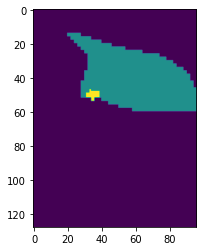

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba9_left_NC = np.zeros((128,96))
prueba9_left_NC[MASK_IZQ_LUNG_ID9] = 1
prueba9_left_NC[COVID_IZQ_ID9] = 0
id_nocovid_9left = np.nonzero(prueba9_left_NC)

prueba9_left_new = np.zeros((128,96))
prueba9_left_new[id_nocovid_9left] = 1
prueba9_left_new[COVID_IZQ_ID9_NEW] = 2
plt.imshow(prueba9_left_new)

ctr_lung_total = PROJ_T_9[COVID_IZQ_ID9_NEW].mean()/PROJ_T_9[id_nocovid_9left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_9[COVID_IZQ_ID9_NEW].mean()/PROJ_NS_ESTIM_HE_9[id_nocovid_9left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_9[COVID_IZQ_ID9_NEW].mean()/PROJ_NS_REF_HE_9[id_nocovid_9left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_9[COVID_IZQ_ID9_NEW].mean()/PROJ_NS_ESTIM_DUAL_9[id_nocovid_9left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 10 - A0502

##### Left Lung

In [ ]:
PROJ_T_10 = np.squeeze(PROJ_HE_T[10,:,:,0])
PROJ_NS_ESTIM_HE_10 = np.squeeze(Test_NS_ESTIM_HE[10,:,:])
PROJ_NS_ESTIM_DUAL_10 = np.squeeze(Test_NS_ESTIM_DUAL_HE[10,:,:])
PROJ_NS_REF_HE_10 = np.squeeze(Test_NS_REF_HE[10,:,:])

ctr_lung_total = PROJ_T_10[COVID_IZQ_ID10].mean()/PROJ_T_10[MASK_IZQ_LUNG_ID10].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_10[COVID_IZQ_ID10].mean()/PROJ_NS_ESTIM_HE_10[MASK_IZQ_LUNG_ID10].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_10[COVID_IZQ_ID10].mean()/PROJ_NS_REF_HE_10[MASK_IZQ_LUNG_ID10].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_10[COVID_IZQ_ID10].mean()/PROJ_NS_ESTIM_DUAL_10[MASK_IZQ_LUNG_ID10].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.70439726
Contraste en la imagen limpia de scatter de referencia: 0.6584173418035023
Contraste en la imagen limpia de scatter estimda SINGLE: 0.6608233398769183
Contraste en la imagen limpia de scatter estimda DUAL: 0.6553633536550558


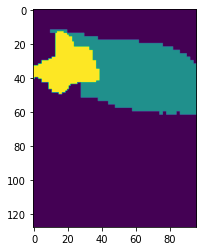

In [ ]:
# COMPROBACIÓN
prueba10_left = np.zeros((128,96))
prueba10_left[MASK_IZQ_LUNG_ID10] = 1
prueba10_left[COVID_IZQ_ID10] = 2
plt.imshow(prueba10_left)

Contraste en la imagen sin corregir: 1.2423387
Contraste en la imagen limpia de scatter de referencia: 1.458453722953482
Contraste en la imagen limpia de scatter estimda SINGLE: 1.4641291974569368
Contraste en la imagen limpia de scatter estimda DUAL: 1.4615480903754274


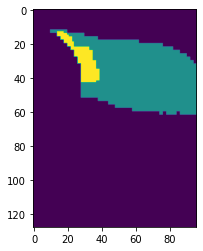

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_10NEW = np.where(MASK_IZQ_LUNG[10,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[10,:,:,0])
COVID_IZQ_ID10_NEW = np.nonzero(PROJ_MASK_IZQ_10NEW)

prueba10_left_new = np.zeros((128,96))
prueba10_left_new[MASK_IZQ_LUNG_ID10] = 1
prueba10_left_new[COVID_IZQ_ID10_NEW] = 2
plt.imshow(prueba10_left_new)

ctr_lung_total = PROJ_T_10[COVID_IZQ_ID10_NEW].mean()/PROJ_T_10[MASK_IZQ_LUNG_ID10].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_10[COVID_IZQ_ID10_NEW].mean()/PROJ_NS_ESTIM_HE_10[MASK_IZQ_LUNG_ID10].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_10[COVID_IZQ_ID10_NEW].mean()/PROJ_NS_REF_HE_10[MASK_IZQ_LUNG_ID10].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_10[COVID_IZQ_ID10_NEW].mean()/PROJ_NS_ESTIM_DUAL_10[MASK_IZQ_LUNG_ID10].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.2761705
Contraste en la imagen limpia de scatter de referencia: 1.5354603051877243
Contraste en la imagen limpia de scatter estimda SINGLE: 1.5424436560323536
Contraste en la imagen limpia de scatter estimda DUAL: 1.5392666173123848


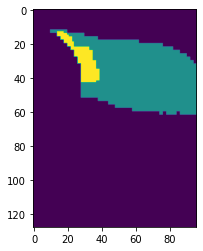

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba10_left_NC = np.zeros((128,96))
prueba10_left_NC[MASK_IZQ_LUNG_ID10] = 1
prueba10_left_NC[COVID_IZQ_ID10] = 0
id_nocovid_10left = np.nonzero(prueba10_left_NC)

prueba10_left_new = np.zeros((128,96))
prueba10_left_new[id_nocovid_10left] = 1
prueba10_left_new[COVID_IZQ_ID10_NEW] = 2
plt.imshow(prueba10_left_new)

ctr_lung_total = PROJ_T_10[COVID_IZQ_ID10_NEW].mean()/PROJ_T_10[id_nocovid_10left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_10[COVID_IZQ_ID10_NEW].mean()/PROJ_NS_ESTIM_HE_10[id_nocovid_10left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_10[COVID_IZQ_ID10_NEW].mean()/PROJ_NS_REF_HE_10[id_nocovid_10left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_10[COVID_IZQ_ID10_NEW].mean()/PROJ_NS_ESTIM_DUAL_10[id_nocovid_10left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

##### Right Lung

In [ ]:
ctr_lung_total = PROJ_T_10[COVID_DCH_ID10].mean()/PROJ_T_10[MASK_DCH_LUNG_ID10].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_10[COVID_DCH_ID10].mean()/PROJ_NS_ESTIM_HE_10[MASK_DCH_LUNG_ID10].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_10[COVID_DCH_ID10].mean()/PROJ_NS_REF_HE_10[MASK_DCH_LUNG_ID10].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_10[COVID_DCH_ID10].mean()/PROJ_NS_ESTIM_DUAL_10[MASK_DCH_LUNG_ID10].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.8907821
Contraste en la imagen limpia de scatter de referencia: 0.8885410866407691
Contraste en la imagen limpia de scatter estimda SINGLE: 0.8835904917132406
Contraste en la imagen limpia de scatter estimda DUAL: 0.8816290762909706


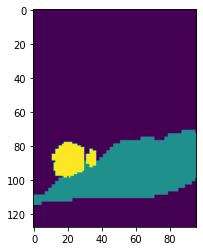

In [ ]:
# COMPROBACIÓN
prueba10_right = np.zeros((128,96))
prueba10_right[MASK_DCH_LUNG_ID10] = 1
prueba10_right[COVID_DCH_ID10] = 2
plt.imshow(prueba10_right)

Contraste en la imagen sin corregir: 1.3942145
Contraste en la imagen limpia de scatter de referencia: 1.6550832305820493
Contraste en la imagen limpia de scatter estimda SINGLE: 1.6597419123982808
Contraste en la imagen limpia de scatter estimda DUAL: 1.6494679417999467


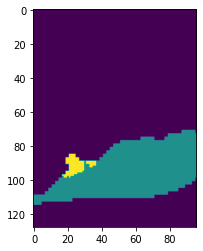

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_DCH_10NEW = np.where(MASK_DCH_LUNG[10,:,:,0] == 0,0,PROJ_MASK_DCH_ID[10,:,:,0])
COVID_DCH_ID10_NEW = np.nonzero(PROJ_MASK_DCH_10NEW)

prueba10_right_new = np.zeros((128,96))
prueba10_right_new[MASK_DCH_LUNG_ID10] = 1
prueba10_right_new[COVID_DCH_ID10_NEW] = 2
plt.imshow(prueba10_right_new)

ctr_lung_total = PROJ_T_10[COVID_DCH_ID10_NEW].mean()/PROJ_T_10[MASK_DCH_LUNG_ID10].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_10[COVID_DCH_ID10_NEW].mean()/PROJ_NS_ESTIM_HE_10[MASK_DCH_LUNG_ID10].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_10[COVID_DCH_ID10_NEW].mean()/PROJ_NS_REF_HE_10[MASK_DCH_LUNG_ID10].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_10[COVID_DCH_ID10_NEW].mean()/PROJ_NS_ESTIM_DUAL_10[MASK_DCH_LUNG_ID10].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.4244719
Contraste en la imagen limpia de scatter de referencia: 1.7156405905010026
Contraste en la imagen limpia de scatter estimda SINGLE: 1.7209175167797823
Contraste en la imagen limpia de scatter estimda DUAL: 1.7092837565744394


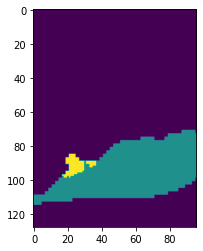

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba10_right_NC = np.zeros((128,96))
prueba10_right_NC[MASK_DCH_LUNG_ID10] = 1
prueba10_right_NC[COVID_DCH_ID10] = 0
id_nocovid_10right = np.nonzero(prueba10_right_NC)

prueba10_right_new = np.zeros((128,96))
prueba10_right_new[id_nocovid_10right] = 1
prueba10_right_new[COVID_DCH_ID10_NEW] = 2
plt.imshow(prueba10_right_new)

ctr_lung_total = PROJ_T_10[COVID_DCH_ID10_NEW].mean()/PROJ_T_10[id_nocovid_10right].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_10[COVID_DCH_ID10_NEW].mean()/PROJ_NS_ESTIM_HE_10[id_nocovid_10right].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_10[COVID_DCH_ID10_NEW].mean()/PROJ_NS_REF_HE_10[id_nocovid_10right].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_10[COVID_DCH_ID10_NEW].mean()/PROJ_NS_ESTIM_DUAL_10[id_nocovid_10right].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 11 - A0504 (Pulmón dch)

In [ ]:
PROJ_T_11 = np.squeeze(PROJ_HE_T[11,:,:,0])
PROJ_NS_ESTIM_HE_11 = np.squeeze(Test_NS_ESTIM_HE[11,:,:])
PROJ_NS_ESTIM_DUAL_11 = np.squeeze(Test_NS_ESTIM_DUAL_HE[11,:,:])
PROJ_NS_REF_HE_11 = np.squeeze(Test_NS_REF_HE[11,:,:])

ctr_lung_total = PROJ_T_11[COVID_DCH_ID11].mean()/PROJ_T_11[MASK_DCH_LUNG_ID11].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_11[COVID_DCH_ID11].mean()/PROJ_NS_ESTIM_HE_11[MASK_DCH_LUNG_ID11].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_11[COVID_DCH_ID11].mean()/PROJ_NS_REF_HE_11[MASK_DCH_LUNG_ID11].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_11[COVID_DCH_ID11].mean()/PROJ_NS_ESTIM_DUAL_11[MASK_DCH_LUNG_ID11].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.0802528
Contraste en la imagen limpia de scatter de referencia: 1.1076562084812103
Contraste en la imagen limpia de scatter estimda SINGLE: 1.1116688202971885
Contraste en la imagen limpia de scatter estimda DUAL: 1.11340752659537


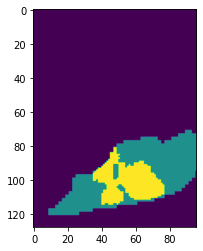

In [ ]:
# COMPROBACIÓN
prueba11_right = np.zeros((128,96))
prueba11_right[MASK_DCH_LUNG_ID11] = 1
prueba11_right[COVID_DCH_ID11] = 2
plt.imshow(prueba11_right)

Contraste en la imagen sin corregir: 1.0888526
Contraste en la imagen limpia de scatter de referencia: 1.1227272407588782
Contraste en la imagen limpia de scatter estimda SINGLE: 1.127040761549153
Contraste en la imagen limpia de scatter estimda DUAL: 1.1290942992957436


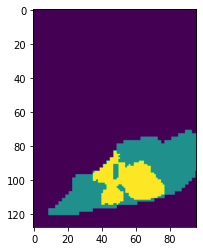

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_DCH_11NEW = np.where(MASK_DCH_LUNG[11,:,:,0] == 0,0,PROJ_MASK_DCH_ID[11,:,:,0])
COVID_DCH_ID11_NEW = np.nonzero(PROJ_MASK_DCH_11NEW)

prueba11_right_new = np.zeros((128,96))
prueba11_right_new[MASK_DCH_LUNG_ID11] = 1
prueba11_right_new[COVID_DCH_ID11_NEW] = 2
plt.imshow(prueba11_right_new)

ctr_lung_total = PROJ_T_11[COVID_DCH_ID11_NEW].mean()/PROJ_T_11[MASK_DCH_LUNG_ID11].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_11[COVID_DCH_ID11_NEW].mean()/PROJ_NS_ESTIM_HE_11[MASK_DCH_LUNG_ID11].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_11[COVID_DCH_ID11_NEW].mean()/PROJ_NS_REF_HE_11[MASK_DCH_LUNG_ID11].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_11[COVID_DCH_ID11_NEW].mean()/PROJ_NS_ESTIM_DUAL_11[MASK_DCH_LUNG_ID11].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.1336691
Contraste en la imagen limpia de scatter de referencia: 1.1875729240911646
Contraste en la imagen limpia de scatter estimda SINGLE: 1.1945605495541716
Contraste en la imagen limpia de scatter estimda DUAL: 1.197897146143484


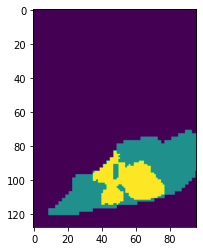

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba11_right_NC = np.zeros((128,96))
prueba11_right_NC[MASK_DCH_LUNG_ID11] = 1
prueba11_right_NC[COVID_DCH_ID11] = 0
id_nocovid_11right = np.nonzero(prueba11_right_NC)

prueba11_right_new = np.zeros((128,96))
prueba11_right_new[id_nocovid_11right] = 1
prueba11_right_new[COVID_DCH_ID11_NEW] = 2
plt.imshow(prueba11_right_new)

ctr_lung_total = PROJ_T_11[COVID_DCH_ID11_NEW].mean()/PROJ_T_11[id_nocovid_11right].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_11[COVID_DCH_ID11_NEW].mean()/PROJ_NS_ESTIM_HE_11[id_nocovid_11right].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_11[COVID_DCH_ID11_NEW].mean()/PROJ_NS_REF_HE_11[id_nocovid_11right].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_11[COVID_DCH_ID11_NEW].mean()/PROJ_NS_ESTIM_DUAL_11[id_nocovid_11right].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 12 - A0521

##### Left lung

In [ ]:
PROJ_T_12 = np.squeeze(PROJ_HE_T[12,:,:,0])
PROJ_NS_ESTIM_HE_12 = np.squeeze(Test_NS_ESTIM_HE[12,:,:])
PROJ_NS_ESTIM_DUAL_12 = np.squeeze(Test_NS_ESTIM_DUAL_HE[12,:,:])
PROJ_NS_REF_HE_12 = np.squeeze(Test_NS_REF_HE[12,:,:])

ctr_lung_total = PROJ_T_12[COVID_IZQ_ID12].mean()/PROJ_T_12[MASK_IZQ_LUNG_ID12].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_12[COVID_IZQ_ID12].mean()/PROJ_NS_ESTIM_HE_12[MASK_IZQ_LUNG_ID12].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_12[COVID_IZQ_ID12].mean()/PROJ_NS_REF_HE_12[MASK_IZQ_LUNG_ID12].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_12[COVID_IZQ_ID12].mean()/PROJ_NS_ESTIM_DUAL_12[MASK_IZQ_LUNG_ID12].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.8703837
Contraste en la imagen limpia de scatter de referencia: 0.8074687294509336
Contraste en la imagen limpia de scatter estimda SINGLE: 0.8111276848616397
Contraste en la imagen limpia de scatter estimda DUAL: 0.8169467346918242


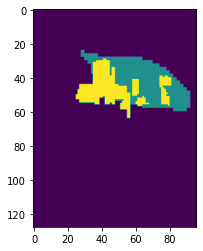

In [ ]:
# COMPROBACIÓN
prueba12_left = np.zeros((128,96))
prueba12_left[MASK_IZQ_LUNG_ID12] = 1
prueba12_left[COVID_IZQ_ID12] = 2
plt.imshow(prueba12_left)

Contraste en la imagen sin corregir: 0.97401154
Contraste en la imagen limpia de scatter de referencia: 0.9628454732602717
Contraste en la imagen limpia de scatter estimda SINGLE: 0.9639887011167851
Contraste en la imagen limpia de scatter estimda DUAL: 0.9717337422148142


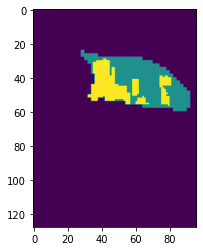

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_12NEW = np.where(MASK_IZQ_LUNG[12,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[12,:,:,0])
COVID_IZQ_ID12_NEW = np.nonzero(PROJ_MASK_IZQ_12NEW)

prueba12_left_new = np.zeros((128,96))
prueba12_left_new[MASK_IZQ_LUNG_ID12] = 1
prueba12_left_new[COVID_IZQ_ID12_NEW] = 2
plt.imshow(prueba12_left_new)

ctr_lung_total = PROJ_T_12[COVID_IZQ_ID12_NEW].mean()/PROJ_T_12[MASK_IZQ_LUNG_ID12].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_12[COVID_IZQ_ID12_NEW].mean()/PROJ_NS_ESTIM_HE_12[MASK_IZQ_LUNG_ID12].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_12[COVID_IZQ_ID12_NEW].mean()/PROJ_NS_REF_HE_12[MASK_IZQ_LUNG_ID12].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_12[COVID_IZQ_ID12_NEW].mean()/PROJ_NS_ESTIM_DUAL_12[MASK_IZQ_LUNG_ID12].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.9598972
Contraste en la imagen limpia de scatter de referencia: 0.943021612292731
Contraste en la imagen limpia de scatter estimda SINGLE: 0.9447398034916852
Contraste en la imagen limpia de scatter estimda DUAL: 0.956437672560259


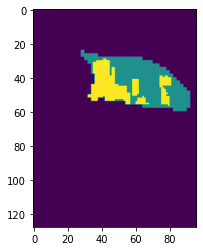

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba12_left_NC = np.zeros((128,96))
prueba12_left_NC[MASK_IZQ_LUNG_ID12] = 1
prueba12_left_NC[COVID_IZQ_ID12] = 0
id_nocovid_12left = np.nonzero(prueba12_left_NC)

prueba12_left_new = np.zeros((128,96))
prueba12_left_new[id_nocovid_12left] = 1
prueba12_left_new[COVID_IZQ_ID12_NEW] = 2
plt.imshow(prueba12_left_new)

ctr_lung_total = PROJ_T_12[COVID_IZQ_ID12_NEW].mean()/PROJ_T_12[id_nocovid_12left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_12[COVID_IZQ_ID12_NEW].mean()/PROJ_NS_ESTIM_HE_12[id_nocovid_12left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_12[COVID_IZQ_ID12_NEW].mean()/PROJ_NS_REF_HE_12[id_nocovid_12left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_12[COVID_IZQ_ID12_NEW].mean()/PROJ_NS_ESTIM_DUAL_12[id_nocovid_12left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

##### Right lung

In [ ]:
PROJ_T_12 = np.squeeze(PROJ_HE_T[12,:,:,0])
PROJ_NS_ESTIM_HE_12 = np.squeeze(Test_NS_ESTIM_HE[12,:,:])
PROJ_NS_ESTIM_DUAL_12 = np.squeeze(Test_NS_ESTIM_DUAL_HE[12,:,:])
PROJ_NS_REF_HE_12 = np.squeeze(Test_NS_REF_HE[12,:,:])

ctr_lung_total = PROJ_T_12[COVID_DCH_ID12].mean()/PROJ_T_12[MASK_DCH_LUNG_ID12].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_12[COVID_DCH_ID12].mean()/PROJ_NS_ESTIM_HE_12[MASK_DCH_LUNG_ID12].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_12[COVID_DCH_ID12].mean()/PROJ_NS_REF_HE_12[MASK_DCH_LUNG_ID12].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_12[COVID_DCH_ID12].mean()/PROJ_NS_ESTIM_DUAL_12[MASK_DCH_LUNG_ID12].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.76914626
Contraste en la imagen limpia de scatter de referencia: 0.6475763134242575
Contraste en la imagen limpia de scatter estimda SINGLE: 0.64079317996561
Contraste en la imagen limpia de scatter estimda DUAL: 0.6454469617088034


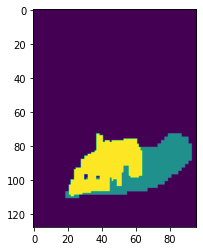

In [ ]:
# COMPROBACIÓN
prueba12_right = np.zeros((128,96))
prueba12_right[MASK_DCH_LUNG_ID12] = 1
prueba12_right[COVID_DCH_ID12] = 2
plt.imshow(prueba12_right)

Contraste en la imagen sin corregir: 1.0848309
Contraste en la imagen limpia de scatter de referencia: 1.153555845828899
Contraste en la imagen limpia de scatter estimda SINGLE: 1.1461300681380475
Contraste en la imagen limpia de scatter estimda DUAL: 1.1575822815146717


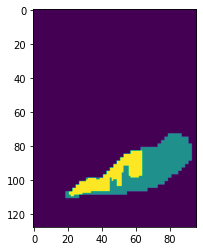

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_DCH_12NEW = np.where(MASK_DCH_LUNG[12,:,:,0] == 0,0,PROJ_MASK_DCH_ID[12,:,:,0])
COVID_DCH_ID12_NEW = np.nonzero(PROJ_MASK_DCH_12NEW)

prueba12_right_new = np.zeros((128,96))
prueba12_right_new[MASK_DCH_LUNG_ID12] = 1
prueba12_right_new[COVID_DCH_ID12_NEW] = 2
plt.imshow(prueba12_right_new)

ctr_lung_total = PROJ_T_12[COVID_DCH_ID12_NEW].mean()/PROJ_T_12[MASK_DCH_LUNG_ID12].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_12[COVID_DCH_ID12_NEW].mean()/PROJ_NS_ESTIM_HE_12[MASK_DCH_LUNG_ID12].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_12[COVID_DCH_ID12_NEW].mean()/PROJ_NS_REF_HE_12[MASK_DCH_LUNG_ID12].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_12[COVID_DCH_ID12_NEW].mean()/PROJ_NS_ESTIM_DUAL_12[MASK_DCH_LUNG_ID12].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.1294868
Contraste en la imagen limpia de scatter de referencia: 1.2424758030921228
Contraste en la imagen limpia de scatter estimda SINGLE: 1.229892999472863
Contraste en la imagen limpia de scatter estimda DUAL: 1.2493378049231767


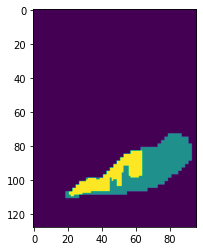

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba12_right_NC = np.zeros((128,96))
prueba12_right_NC[MASK_DCH_LUNG_ID12] = 1
prueba12_right_NC[COVID_DCH_ID12] = 0
id_nocovid_12right = np.nonzero(prueba12_right_NC)

prueba12_right_new = np.zeros((128,96))
prueba12_right_new[id_nocovid_12right] = 1
prueba12_right_new[COVID_DCH_ID12_NEW] = 2
plt.imshow(prueba12_right_new)

ctr_lung_total = PROJ_T_12[COVID_DCH_ID12_NEW].mean()/PROJ_T_12[id_nocovid_12right].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_12[COVID_DCH_ID12_NEW].mean()/PROJ_NS_ESTIM_HE_12[id_nocovid_12right].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_12[COVID_DCH_ID12_NEW].mean()/PROJ_NS_REF_HE_12[id_nocovid_12right].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_12[COVID_DCH_ID12_NEW].mean()/PROJ_NS_ESTIM_DUAL_12[id_nocovid_12right].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 13 - A0522

##### Left lung

In [ ]:
PROJ_T_13 = np.squeeze(PROJ_HE_T[13,:,:,0])
PROJ_NS_ESTIM_HE_13 = np.squeeze(Test_NS_ESTIM_HE[13,:,:])
PROJ_NS_ESTIM_DUAL_13 = np.squeeze(Test_NS_ESTIM_DUAL_HE[13,:,:])
PROJ_NS_REF_HE_13 = np.squeeze(Test_NS_REF_HE[13,:,:])

ctr_lung_total = PROJ_T_13[COVID_IZQ_ID13].mean()/PROJ_T_13[MASK_IZQ_LUNG_ID13].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_13[COVID_IZQ_ID13].mean()/PROJ_NS_ESTIM_HE_13[MASK_IZQ_LUNG_ID13].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_13[COVID_IZQ_ID13].mean()/PROJ_NS_REF_HE_13[MASK_IZQ_LUNG_ID13].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_13[COVID_IZQ_ID13].mean()/PROJ_NS_ESTIM_DUAL_13[MASK_IZQ_LUNG_ID13].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.0435182
Contraste en la imagen limpia de scatter de referencia: 1.044558033628346
Contraste en la imagen limpia de scatter estimda SINGLE: 1.0472286343067871
Contraste en la imagen limpia de scatter estimda DUAL: 1.043331627780673


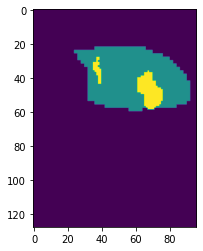

In [ ]:
# COMPROBACIÓN
prueba13_left = np.zeros((128,96))
prueba13_left[MASK_IZQ_LUNG_ID13] = 1
prueba13_left[COVID_IZQ_ID13] = 2
plt.imshow(prueba13_left)

Contraste en la imagen sin corregir: 1.0513835
Contraste en la imagen limpia de scatter de referencia: 1.0577381503703431
Contraste en la imagen limpia de scatter estimda SINGLE: 1.0601863721288873
Contraste en la imagen limpia de scatter estimda DUAL: 1.0567886692308275


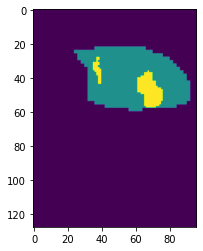

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_13NEW = np.where(MASK_IZQ_LUNG[13,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[13,:,:,0])
COVID_IZQ_ID13_NEW = np.nonzero(PROJ_MASK_IZQ_13NEW)

prueba13_left_new = np.zeros((128,96))
prueba13_left_new[MASK_IZQ_LUNG_ID13] = 1
prueba13_left_new[COVID_IZQ_ID13_NEW] = 2
plt.imshow(prueba13_left_new)

ctr_lung_total = PROJ_T_13[COVID_IZQ_ID13_NEW].mean()/PROJ_T_13[MASK_IZQ_LUNG_ID13].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_13[COVID_IZQ_ID13_NEW].mean()/PROJ_NS_ESTIM_HE_13[MASK_IZQ_LUNG_ID13].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_13[COVID_IZQ_ID13_NEW].mean()/PROJ_NS_REF_HE_13[MASK_IZQ_LUNG_ID13].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_13[COVID_IZQ_ID13_NEW].mean()/PROJ_NS_ESTIM_DUAL_13[MASK_IZQ_LUNG_ID13].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.0598058
Contraste en la imagen limpia de scatter de referencia: 1.06726884566152
Contraste en la imagen limpia de scatter estimda SINGLE: 1.0701479903086732
Contraste en la imagen limpia de scatter estimda DUAL: 1.0661528339098219


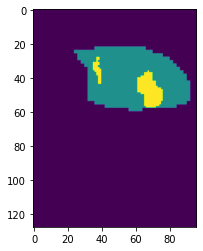

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba13_left_NC = np.zeros((128,96))
prueba13_left_NC[MASK_IZQ_LUNG_ID13] = 1
prueba13_left_NC[COVID_IZQ_ID13] = 0
id_nocovid_13left = np.nonzero(prueba13_left_NC)

prueba13_left_new = np.zeros((128,96))
prueba13_left_new[id_nocovid_13left] = 1
prueba13_left_new[COVID_IZQ_ID13_NEW] = 2
plt.imshow(prueba13_left_new)

ctr_lung_total = PROJ_T_13[COVID_IZQ_ID13_NEW].mean()/PROJ_T_13[id_nocovid_13left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_13[COVID_IZQ_ID13_NEW].mean()/PROJ_NS_ESTIM_HE_13[id_nocovid_13left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_13[COVID_IZQ_ID13_NEW].mean()/PROJ_NS_REF_HE_13[id_nocovid_13left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_13[COVID_IZQ_ID13_NEW].mean()/PROJ_NS_ESTIM_DUAL_13[id_nocovid_13left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

##### Right lung

In [ ]:
PROJ_T_13 = np.squeeze(PROJ_HE_T[13,:,:,0])
PROJ_NS_ESTIM_HE_13 = np.squeeze(Test_NS_ESTIM_HE[13,:,:])
PROJ_NS_ESTIM_DUAL_13 = np.squeeze(Test_NS_ESTIM_DUAL_HE[13,:,:])
PROJ_NS_REF_HE_13 = np.squeeze(Test_NS_REF_HE[13,:,:])

ctr_lung_total = PROJ_T_13[COVID_DCH_ID13].mean()/PROJ_T_13[MASK_DCH_LUNG_ID13].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_13[COVID_DCH_ID13].mean()/PROJ_NS_ESTIM_HE_13[MASK_DCH_LUNG_ID13].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_13[COVID_DCH_ID13].mean()/PROJ_NS_REF_HE_13[MASK_DCH_LUNG_ID13].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_13[COVID_DCH_ID13].mean()/PROJ_NS_ESTIM_DUAL_13[MASK_DCH_LUNG_ID13].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.58327544
Contraste en la imagen limpia de scatter de referencia: 0.41447298259658605
Contraste en la imagen limpia de scatter estimda SINGLE: 0.4115196389456398
Contraste en la imagen limpia de scatter estimda DUAL: 0.41411501273343687


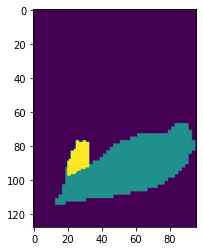

In [ ]:
# COMPROBACIÓN
prueba13_right = np.zeros((128,96))
prueba13_right[MASK_DCH_LUNG_ID13] = 1
prueba13_right[COVID_DCH_ID13] = 2
plt.imshow(prueba13_right)

Contraste en la imagen sin corregir: 0.88704044
Contraste en la imagen limpia de scatter de referencia: 0.8960841960459035
Contraste en la imagen limpia de scatter estimda SINGLE: 0.8917037017540411
Contraste en la imagen limpia de scatter estimda DUAL: 0.9108844711455854


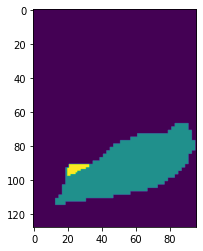

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_DCH_13NEW = np.where(MASK_DCH_LUNG[13,:,:,0] == 0,0,PROJ_MASK_DCH_ID[13,:,:,0])
COVID_DCH_ID13_NEW = np.nonzero(PROJ_MASK_DCH_13NEW)

prueba13_right_new = np.zeros((128,96))
prueba13_right_new[MASK_DCH_LUNG_ID13] = 1
prueba13_right_new[COVID_DCH_ID13_NEW] = 2
plt.imshow(prueba13_right_new)

ctr_lung_total = PROJ_T_13[COVID_DCH_ID13_NEW].mean()/PROJ_T_13[MASK_DCH_LUNG_ID13].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_13[COVID_DCH_ID13_NEW].mean()/PROJ_NS_ESTIM_HE_13[MASK_DCH_LUNG_ID13].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_13[COVID_DCH_ID13_NEW].mean()/PROJ_NS_REF_HE_13[MASK_DCH_LUNG_ID13].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_13[COVID_DCH_ID13_NEW].mean()/PROJ_NS_ESTIM_DUAL_13[MASK_DCH_LUNG_ID13].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.88426584
Contraste en la imagen limpia de scatter de referencia: 0.8935050489487216
Contraste en la imagen limpia de scatter estimda SINGLE: 0.889029296702234
Contraste en la imagen limpia de scatter estimda DUAL: 0.9086352070618892


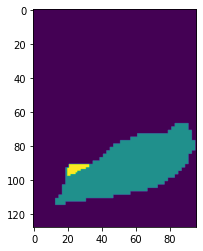

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba13_right_NC = np.zeros((128,96))
prueba13_right_NC[MASK_DCH_LUNG_ID13] = 1
prueba13_right_NC[COVID_DCH_ID13] = 0
id_nocovid_13right = np.nonzero(prueba13_right_NC)

prueba13_right_new = np.zeros((128,96))
prueba13_right_new[id_nocovid_13right] = 1
prueba13_right_new[COVID_DCH_ID13_NEW] = 2
plt.imshow(prueba13_right_new)

ctr_lung_total = PROJ_T_13[COVID_DCH_ID13_NEW].mean()/PROJ_T_13[id_nocovid_13right].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_13[COVID_DCH_ID13_NEW].mean()/PROJ_NS_ESTIM_HE_13[id_nocovid_13right].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_13[COVID_DCH_ID13_NEW].mean()/PROJ_NS_REF_HE_13[id_nocovid_13right].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_13[COVID_DCH_ID13_NEW].mean()/PROJ_NS_ESTIM_DUAL_13[id_nocovid_13right].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 14 - A0524 (Pulmón dch)

In [ ]:
PROJ_T_14 = np.squeeze(PROJ_HE_T[14,:,:,0])
PROJ_NS_ESTIM_HE_14 = np.squeeze(Test_NS_ESTIM_HE[14,:,:])
PROJ_NS_ESTIM_DUAL_14 = np.squeeze(Test_NS_ESTIM_DUAL_HE[14,:,:])
PROJ_NS_REF_HE_14 = np.squeeze(Test_NS_REF_HE[14,:,:])

ctr_lung_total = PROJ_T_14[COVID_DCH_ID14].mean()/PROJ_T_14[MASK_DCH_LUNG_ID14].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_14[COVID_DCH_ID14].mean()/PROJ_NS_ESTIM_HE_14[MASK_DCH_LUNG_ID14].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_14[COVID_DCH_ID14].mean()/PROJ_NS_REF_HE_14[MASK_DCH_LUNG_ID14].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_14[COVID_DCH_ID14].mean()/PROJ_NS_ESTIM_DUAL_14[MASK_DCH_LUNG_ID14].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.8966346
Contraste en la imagen limpia de scatter de referencia: 0.7981109100286209
Contraste en la imagen limpia de scatter estimda SINGLE: 0.788224944865759
Contraste en la imagen limpia de scatter estimda DUAL: 0.7865637051209211


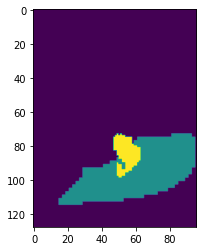

In [ ]:
# COMPROBACIÓN
prueba14_right = np.zeros((128,96))
prueba14_right[MASK_DCH_LUNG_ID14] = 1
prueba14_right[COVID_DCH_ID14] = 2
plt.imshow(prueba14_right)

Contraste en la imagen sin corregir: 1.1218456
Contraste en la imagen limpia de scatter de referencia: 1.1340314251386554
Contraste en la imagen limpia de scatter estimda SINGLE: 1.1314160114475118
Contraste en la imagen limpia de scatter estimda DUAL: 1.130074295207572


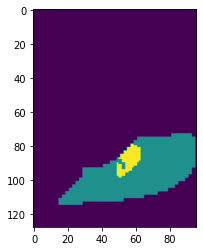

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_DCH_14NEW = np.where(MASK_DCH_LUNG[14,:,:,0] == 0,0,PROJ_MASK_DCH_ID[14,:,:,0])
COVID_DCH_ID14_NEW = np.nonzero(PROJ_MASK_DCH_14NEW)

prueba14_right_new = np.zeros((128,96))
prueba14_right_new[MASK_DCH_LUNG_ID14] = 1
prueba14_right_new[COVID_DCH_ID14_NEW] = 2
plt.imshow(prueba14_right_new)

ctr_lung_total = PROJ_T_14[COVID_DCH_ID14_NEW].mean()/PROJ_T_14[MASK_DCH_LUNG_ID14].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_14[COVID_DCH_ID14_NEW].mean()/PROJ_NS_ESTIM_HE_14[MASK_DCH_LUNG_ID14].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_14[COVID_DCH_ID14_NEW].mean()/PROJ_NS_REF_HE_14[MASK_DCH_LUNG_ID14].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_14[COVID_DCH_ID14_NEW].mean()/PROJ_NS_ESTIM_DUAL_14[MASK_DCH_LUNG_ID14].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.1342137
Contraste en la imagen limpia de scatter de referencia: 1.1477993126322001
Contraste en la imagen limpia de scatter estimda SINGLE: 1.1448809169920635
Contraste en la imagen limpia de scatter estimda DUAL: 1.1433843064121756


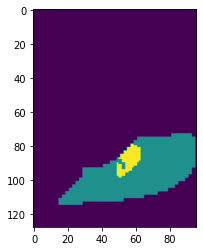

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba14_right_NC = np.zeros((128,96))
prueba14_right_NC[MASK_DCH_LUNG_ID14] = 1
prueba14_right_NC[COVID_DCH_ID14] = 0
id_nocovid_14right = np.nonzero(prueba14_right_NC)

prueba14_right_new = np.zeros((128,96))
prueba14_right_new[id_nocovid_14right] = 1
prueba14_right_new[COVID_DCH_ID14_NEW] = 2
plt.imshow(prueba14_right_new)

ctr_lung_total = PROJ_T_14[COVID_DCH_ID14_NEW].mean()/PROJ_T_14[id_nocovid_14right].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_14[COVID_DCH_ID14_NEW].mean()/PROJ_NS_ESTIM_HE_14[id_nocovid_14right].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_14[COVID_DCH_ID14_NEW].mean()/PROJ_NS_REF_HE_14[id_nocovid_14right].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_14[COVID_DCH_ID14_NEW].mean()/PROJ_NS_ESTIM_DUAL_14[id_nocovid_14right].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 15 - A0525

##### Left lung

In [ ]:
PROJ_T_15 = np.squeeze(PROJ_HE_T[15,:,:,0])
PROJ_NS_ESTIM_HE_15 = np.squeeze(Test_NS_ESTIM_HE[15,:,:])
PROJ_NS_ESTIM_DUAL_15 = np.squeeze(Test_NS_ESTIM_DUAL_HE[15,:,:])
PROJ_NS_REF_HE_15 = np.squeeze(Test_NS_REF_HE[15,:,:])

ctr_lung_total = PROJ_T_15[COVID_IZQ_ID15].mean()/PROJ_T_15[MASK_IZQ_LUNG_ID15].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_15[COVID_IZQ_ID15].mean()/PROJ_NS_ESTIM_HE_15[MASK_IZQ_LUNG_ID15].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_15[COVID_IZQ_ID15].mean()/PROJ_NS_REF_HE_15[MASK_IZQ_LUNG_ID15].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_15[COVID_IZQ_ID15].mean()/PROJ_NS_ESTIM_DUAL_15[MASK_IZQ_LUNG_ID15].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.7287686
Contraste en la imagen limpia de scatter de referencia: 0.656725384506996
Contraste en la imagen limpia de scatter estimda SINGLE: 0.6678545712523639
Contraste en la imagen limpia de scatter estimda DUAL: 0.6616221413397345


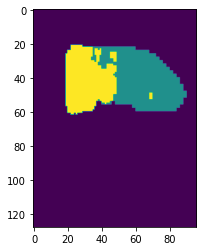

In [ ]:
# COMPROBACIÓN
prueba15_left = np.zeros((128,96))
prueba15_left[MASK_IZQ_LUNG_ID15] = 1
prueba15_left[COVID_IZQ_ID15] = 2
plt.imshow(prueba15_left)

Contraste en la imagen sin corregir: 1.0332956
Contraste en la imagen limpia de scatter de referencia: 1.0611200372310934
Contraste en la imagen limpia de scatter estimda SINGLE: 1.0684233396822016
Contraste en la imagen limpia de scatter estimda DUAL: 1.0651620094618353


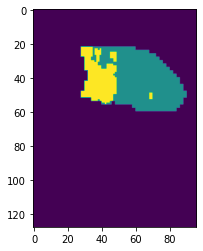

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_15NEW = np.where(MASK_IZQ_LUNG[15,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[15,:,:,0])
COVID_IZQ_ID15_NEW = np.nonzero(PROJ_MASK_IZQ_15NEW)

prueba15_left_new = np.zeros((128,96))
prueba15_left_new[MASK_IZQ_LUNG_ID15] = 1
prueba15_left_new[COVID_IZQ_ID15_NEW] = 2
plt.imshow(prueba15_left_new)

ctr_lung_total = PROJ_T_15[COVID_IZQ_ID15_NEW].mean()/PROJ_T_15[MASK_IZQ_LUNG_ID15].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_15[COVID_IZQ_ID15_NEW].mean()/PROJ_NS_ESTIM_HE_15[MASK_IZQ_LUNG_ID15].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_15[COVID_IZQ_ID15_NEW].mean()/PROJ_NS_REF_HE_15[MASK_IZQ_LUNG_ID15].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_15[COVID_IZQ_ID15_NEW].mean()/PROJ_NS_ESTIM_DUAL_15[MASK_IZQ_LUNG_ID15].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.0465717
Contraste en la imagen limpia de scatter de referencia: 1.086418416677491
Contraste en la imagen limpia de scatter estimda SINGLE: 1.0970210458986942
Contraste en la imagen limpia de scatter estimda DUAL: 1.092278906268716


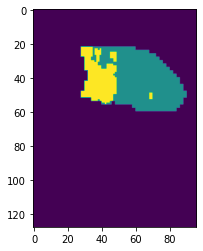

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba15_left_NC = np.zeros((128,96))
prueba15_left_NC[MASK_IZQ_LUNG_ID15] = 1
prueba15_left_NC[COVID_IZQ_ID15] = 0
id_nocovid_15left = np.nonzero(prueba15_left_NC)

prueba15_left_new = np.zeros((128,96))
prueba15_left_new[id_nocovid_15left] = 1
prueba15_left_new[COVID_IZQ_ID15_NEW] = 2
plt.imshow(prueba15_left_new)

ctr_lung_total = PROJ_T_15[COVID_IZQ_ID15_NEW].mean()/PROJ_T_15[id_nocovid_15left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_15[COVID_IZQ_ID15_NEW].mean()/PROJ_NS_ESTIM_HE_15[id_nocovid_15left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_15[COVID_IZQ_ID15_NEW].mean()/PROJ_NS_REF_HE_15[id_nocovid_15left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_15[COVID_IZQ_ID15_NEW].mean()/PROJ_NS_ESTIM_DUAL_15[id_nocovid_15left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

##### Right lung

In [ ]:
PROJ_T_15 = np.squeeze(PROJ_HE_T[15,:,:,0])
PROJ_NS_ESTIM_HE_15 = np.squeeze(Test_NS_ESTIM_HE[15,:,:])
PROJ_NS_ESTIM_DUAL_15 = np.squeeze(Test_NS_ESTIM_DUAL_HE[15,:,:])
PROJ_NS_REF_HE_15 = np.squeeze(Test_NS_REF_HE[15,:,:])

ctr_lung_total = PROJ_T_15[COVID_DCH_ID15].mean()/PROJ_T_15[MASK_DCH_LUNG_ID15].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_15[COVID_DCH_ID15].mean()/PROJ_NS_ESTIM_HE_15[MASK_DCH_LUNG_ID15].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_15[COVID_DCH_ID15].mean()/PROJ_NS_REF_HE_15[MASK_DCH_LUNG_ID15].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_15[COVID_DCH_ID15].mean()/PROJ_NS_ESTIM_DUAL_15[MASK_DCH_LUNG_ID15].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.75314045
Contraste en la imagen limpia de scatter de referencia: 0.7155179729558334
Contraste en la imagen limpia de scatter estimda SINGLE: 0.7097572973091647
Contraste en la imagen limpia de scatter estimda DUAL: 0.7086461402068088


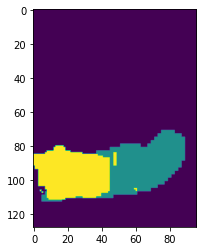

In [ ]:
# COMPROBACIÓN
prueba15_right = np.zeros((128,96))
prueba15_right[MASK_DCH_LUNG_ID15] = 1
prueba15_right[COVID_DCH_ID15] = 2
plt.imshow(prueba15_right)

Contraste en la imagen sin corregir: 0.97000307
Contraste en la imagen limpia de scatter de referencia: 0.994277872494582
Contraste en la imagen limpia de scatter estimda SINGLE: 0.9900857223482704
Contraste en la imagen limpia de scatter estimda DUAL: 0.9921906011181607


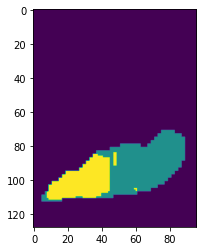

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_DCH_15NEW = np.where(MASK_DCH_LUNG[15,:,:,0] == 0,0,PROJ_MASK_DCH_ID[15,:,:,0])
COVID_DCH_ID15_NEW = np.nonzero(PROJ_MASK_DCH_15NEW)

prueba15_right_new = np.zeros((128,96))
prueba15_right_new[MASK_DCH_LUNG_ID15] = 1
prueba15_right_new[COVID_DCH_ID15_NEW] = 2
plt.imshow(prueba15_right_new)

ctr_lung_total = PROJ_T_15[COVID_DCH_ID15_NEW].mean()/PROJ_T_15[MASK_DCH_LUNG_ID15].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_15[COVID_DCH_ID15_NEW].mean()/PROJ_NS_ESTIM_HE_15[MASK_DCH_LUNG_ID15].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_15[COVID_DCH_ID15_NEW].mean()/PROJ_NS_REF_HE_15[MASK_DCH_LUNG_ID15].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_15[COVID_DCH_ID15_NEW].mean()/PROJ_NS_ESTIM_DUAL_15[MASK_DCH_LUNG_ID15].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.9550102
Contraste en la imagen limpia de scatter de referencia: 0.9913091830443004
Contraste en la imagen limpia de scatter estimda SINGLE: 0.9849749753412701
Contraste en la imagen limpia de scatter estimda DUAL: 0.9881519212067136


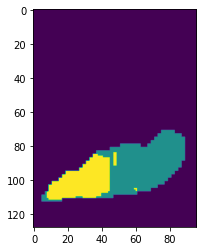

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba15_right_NC = np.zeros((128,96))
prueba15_right_NC[MASK_DCH_LUNG_ID15] = 1
prueba15_right_NC[COVID_DCH_ID15] = 0
id_nocovid_15right = np.nonzero(prueba15_right_NC)

prueba15_right_new = np.zeros((128,96))
prueba15_right_new[id_nocovid_15right] = 1
prueba15_right_new[COVID_DCH_ID15_NEW] = 2
plt.imshow(prueba15_right_new)

ctr_lung_total = PROJ_T_15[COVID_DCH_ID15_NEW].mean()/PROJ_T_15[id_nocovid_15right].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_15[COVID_DCH_ID15_NEW].mean()/PROJ_NS_ESTIM_HE_15[id_nocovid_15right].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_15[COVID_DCH_ID15_NEW].mean()/PROJ_NS_REF_HE_15[id_nocovid_15right].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_15[COVID_DCH_ID15_NEW].mean()/PROJ_NS_ESTIM_DUAL_15[id_nocovid_15right].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 16 - A0526 (Pulmón izq)

In [ ]:
PROJ_T_16 = np.squeeze(PROJ_HE_T[16,:,:,0])
PROJ_NS_ESTIM_HE_16 = np.squeeze(Test_NS_ESTIM_HE[16,:,:])
PROJ_NS_ESTIM_DUAL_16 = np.squeeze(Test_NS_ESTIM_DUAL_HE[16,:,:])
PROJ_NS_REF_HE_16 = np.squeeze(Test_NS_REF_HE[16,:,:])

ctr_lung_total = PROJ_T_16[COVID_IZQ_ID16].mean()/PROJ_T_16[MASK_IZQ_LUNG_ID16].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_16[COVID_IZQ_ID16].mean()/PROJ_NS_ESTIM_HE_16[MASK_IZQ_LUNG_ID16].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_16[COVID_IZQ_ID16].mean()/PROJ_NS_REF_HE_16[MASK_IZQ_LUNG_ID16].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_16[COVID_IZQ_ID16].mean()/PROJ_NS_ESTIM_DUAL_16[MASK_IZQ_LUNG_ID16].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.7826321
Contraste en la imagen limpia de scatter de referencia: 0.7260960916122234
Contraste en la imagen limpia de scatter estimda SINGLE: 0.7252580647088165
Contraste en la imagen limpia de scatter estimda DUAL: 0.7270803612717611


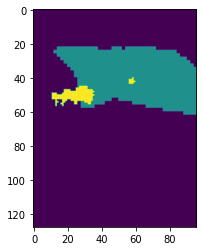

In [ ]:
# COMPROBACIÓN
prueba16_left = np.zeros((128,96))
prueba16_left[MASK_IZQ_LUNG_ID16] = 1
prueba16_left[COVID_IZQ_ID16] = 2
plt.imshow(prueba16_left)

Contraste en la imagen sin corregir: 1.1678802
Contraste en la imagen limpia de scatter de referencia: 1.2407012067858534
Contraste en la imagen limpia de scatter estimda SINGLE: 1.2415869171752385
Contraste en la imagen limpia de scatter estimda DUAL: 1.2409782455733547


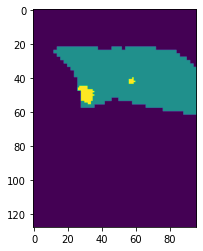

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_16NEW = np.where(MASK_IZQ_LUNG[16,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[16,:,:,0])
COVID_IZQ_ID16_NEW = np.nonzero(PROJ_MASK_IZQ_16NEW)

prueba16_left_new = np.zeros((128,96))
prueba16_left_new[MASK_IZQ_LUNG_ID16] = 1
prueba16_left_new[COVID_IZQ_ID16_NEW] = 2
plt.imshow(prueba16_left_new)

ctr_lung_total = PROJ_T_16[COVID_IZQ_ID16_NEW].mean()/PROJ_T_16[MASK_IZQ_LUNG_ID16].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_16[COVID_IZQ_ID16_NEW].mean()/PROJ_NS_ESTIM_HE_16[MASK_IZQ_LUNG_ID16].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_16[COVID_IZQ_ID16_NEW].mean()/PROJ_NS_REF_HE_16[MASK_IZQ_LUNG_ID16].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_16[COVID_IZQ_ID16_NEW].mean()/PROJ_NS_ESTIM_DUAL_16[MASK_IZQ_LUNG_ID16].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.1745942
Contraste en la imagen limpia de scatter de referencia: 1.25095323800725
Contraste en la imagen limpia de scatter estimda SINGLE: 1.2518843316281094
Contraste en la imagen limpia de scatter estimda DUAL: 1.2512444659988193


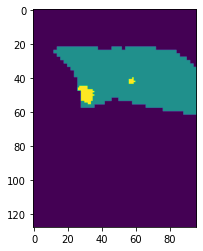

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba16_left_NC = np.zeros((128,96))
prueba16_left_NC[MASK_IZQ_LUNG_ID16] = 1
prueba16_left_NC[COVID_IZQ_ID16] = 0
id_nocovid_16left = np.nonzero(prueba16_left_NC)

prueba16_left_new = np.zeros((128,96))
prueba16_left_new[id_nocovid_16left] = 1
prueba16_left_new[COVID_IZQ_ID16_NEW] = 2
plt.imshow(prueba16_left_new)

ctr_lung_total = PROJ_T_16[COVID_IZQ_ID16_NEW].mean()/PROJ_T_16[id_nocovid_16left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_16[COVID_IZQ_ID16_NEW].mean()/PROJ_NS_ESTIM_HE_16[id_nocovid_16left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_16[COVID_IZQ_ID16_NEW].mean()/PROJ_NS_REF_HE_16[id_nocovid_16left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_16[COVID_IZQ_ID16_NEW].mean()/PROJ_NS_ESTIM_DUAL_16[id_nocovid_16left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 17 - A0530

##### Left lung

In [ ]:
PROJ_T_17 = np.squeeze(PROJ_HE_T[17,:,:,0])
PROJ_NS_ESTIM_HE_17 = np.squeeze(Test_NS_ESTIM_HE[17,:,:])
PROJ_NS_ESTIM_DUAL_17 = np.squeeze(Test_NS_ESTIM_DUAL_HE[17,:,:])
PROJ_NS_REF_HE_17 = np.squeeze(Test_NS_REF_HE[17,:,:])

ctr_lung_total = PROJ_T_17[COVID_IZQ_ID17].mean()/PROJ_T_17[MASK_IZQ_LUNG_ID17].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_17[COVID_IZQ_ID17].mean()/PROJ_NS_ESTIM_HE_17[MASK_IZQ_LUNG_ID17].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_17[COVID_IZQ_ID17].mean()/PROJ_NS_REF_HE_17[MASK_IZQ_LUNG_ID17].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_17[COVID_IZQ_ID17].mean()/PROJ_NS_ESTIM_DUAL_17[MASK_IZQ_LUNG_ID17].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.1040108
Contraste en la imagen limpia de scatter de referencia: 1.1353829776331363
Contraste en la imagen limpia de scatter estimda SINGLE: 1.142523494407153
Contraste en la imagen limpia de scatter estimda DUAL: 1.137960674207744


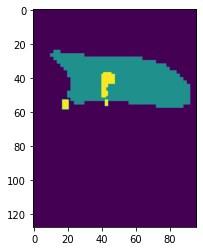

In [ ]:
# COMPROBACIÓN
prueba17_left = np.zeros((128,96))
prueba17_left[MASK_IZQ_LUNG_ID17] = 1
prueba17_left[COVID_IZQ_ID17] = 2
plt.imshow(prueba17_left)

Contraste en la imagen sin corregir: 1.3484471
Contraste en la imagen limpia de scatter de referencia: 1.4436865165807267
Contraste en la imagen limpia de scatter estimda SINGLE: 1.4585949835174419
Contraste en la imagen limpia de scatter estimda DUAL: 1.44977028461851


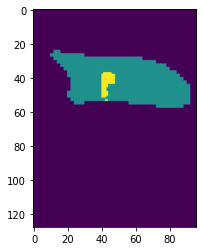

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_17NEW = np.where(MASK_IZQ_LUNG[17,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[17,:,:,0])
COVID_IZQ_ID17_NEW = np.nonzero(PROJ_MASK_IZQ_17NEW)

prueba17_left_new = np.zeros((128,96))
prueba17_left_new[MASK_IZQ_LUNG_ID17] = 1
prueba17_left_new[COVID_IZQ_ID17_NEW] = 2
plt.imshow(prueba17_left_new)

ctr_lung_total = PROJ_T_17[COVID_IZQ_ID17_NEW].mean()/PROJ_T_17[MASK_IZQ_LUNG_ID17].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_17[COVID_IZQ_ID17_NEW].mean()/PROJ_NS_ESTIM_HE_17[MASK_IZQ_LUNG_ID17].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_17[COVID_IZQ_ID17_NEW].mean()/PROJ_NS_REF_HE_17[MASK_IZQ_LUNG_ID17].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_17[COVID_IZQ_ID17_NEW].mean()/PROJ_NS_ESTIM_DUAL_17[MASK_IZQ_LUNG_ID17].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.3709397
Contraste en la imagen limpia de scatter de referencia: 1.4744901931918117
Contraste en la imagen limpia de scatter estimda SINGLE: 1.4907855720412178
Contraste en la imagen limpia de scatter estimda DUAL: 1.481137102051065


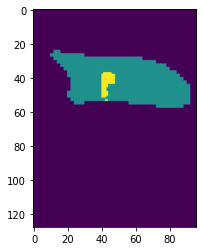

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba17_left_NC = np.zeros((128,96))
prueba17_left_NC[MASK_IZQ_LUNG_ID17] = 1
prueba17_left_NC[COVID_IZQ_ID17] = 0
id_nocovid_17left = np.nonzero(prueba17_left_NC)

prueba17_left_new = np.zeros((128,96))
prueba17_left_new[id_nocovid_17left] = 1
prueba17_left_new[COVID_IZQ_ID17_NEW] = 2
plt.imshow(prueba17_left_new)

ctr_lung_total = PROJ_T_17[COVID_IZQ_ID17_NEW].mean()/PROJ_T_17[id_nocovid_17left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_17[COVID_IZQ_ID17_NEW].mean()/PROJ_NS_ESTIM_HE_17[id_nocovid_17left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_17[COVID_IZQ_ID17_NEW].mean()/PROJ_NS_REF_HE_17[id_nocovid_17left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_17[COVID_IZQ_ID17_NEW].mean()/PROJ_NS_ESTIM_DUAL_17[id_nocovid_17left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

##### Right lung

In [ ]:
PROJ_T_17 = np.squeeze(PROJ_HE_T[17,:,:,0])
PROJ_NS_ESTIM_HE_17 = np.squeeze(Test_NS_ESTIM_HE[17,:,:])
PROJ_NS_ESTIM_DUAL_17 = np.squeeze(Test_NS_ESTIM_DUAL_HE[17,:,:])
PROJ_NS_REF_HE_17 = np.squeeze(Test_NS_REF_HE[17,:,:])

ctr_lung_total = PROJ_T_17[COVID_DCH_ID17].mean()/PROJ_T_17[MASK_DCH_LUNG_ID17].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_17[COVID_DCH_ID17].mean()/PROJ_NS_ESTIM_HE_17[MASK_DCH_LUNG_ID17].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_17[COVID_DCH_ID17].mean()/PROJ_NS_REF_HE_17[MASK_DCH_LUNG_ID17].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_17[COVID_DCH_ID17].mean()/PROJ_NS_ESTIM_DUAL_17[MASK_DCH_LUNG_ID17].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.923576
Contraste en la imagen limpia de scatter de referencia: 0.8936608929121393
Contraste en la imagen limpia de scatter estimda SINGLE: 0.8906733349155541
Contraste en la imagen limpia de scatter estimda DUAL: 0.898125659674058


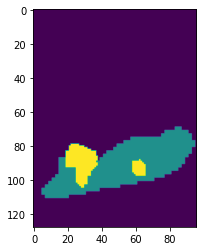

In [ ]:
# COMPROBACIÓN
prueba17_right = np.zeros((128,96))
prueba17_right[MASK_DCH_LUNG_ID17] = 1
prueba17_right[COVID_DCH_ID17] = 2
plt.imshow(prueba17_right)

Contraste en la imagen sin corregir: 1.1972914
Contraste en la imagen limpia de scatter de referencia: 1.2790904366148519
Contraste en la imagen limpia de scatter estimda SINGLE: 1.2905391395369332
Contraste en la imagen limpia de scatter estimda DUAL: 1.2905207971639734


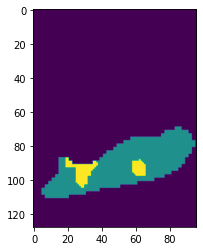

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_DCH_17NEW = np.where(MASK_DCH_LUNG[17,:,:,0] == 0,0,PROJ_MASK_DCH_ID[17,:,:,0])
COVID_DCH_ID17_NEW = np.nonzero(PROJ_MASK_DCH_17NEW)

prueba17_right_new = np.zeros((128,96))
prueba17_right_new[MASK_DCH_LUNG_ID17] = 1
prueba17_right_new[COVID_DCH_ID17_NEW] = 2
plt.imshow(prueba17_right_new)

ctr_lung_total = PROJ_T_17[COVID_DCH_ID17_NEW].mean()/PROJ_T_17[MASK_DCH_LUNG_ID17].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_17[COVID_DCH_ID17_NEW].mean()/PROJ_NS_ESTIM_HE_17[MASK_DCH_LUNG_ID17].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_17[COVID_DCH_ID17_NEW].mean()/PROJ_NS_REF_HE_17[MASK_DCH_LUNG_ID17].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_17[COVID_DCH_ID17_NEW].mean()/PROJ_NS_ESTIM_DUAL_17[MASK_DCH_LUNG_ID17].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.2279426
Contraste en la imagen limpia de scatter de referencia: 1.3259092360182179
Contraste en la imagen limpia de scatter estimda SINGLE: 1.3397887140562679
Contraste en la imagen limpia de scatter estimda DUAL: 1.33976644386679


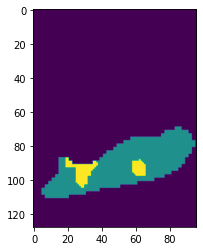

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba17_right_NC = np.zeros((128,96))
prueba17_right_NC[MASK_DCH_LUNG_ID17] = 1
prueba17_right_NC[COVID_DCH_ID17] = 0
id_nocovid_17right = np.nonzero(prueba17_right_NC)

prueba17_right_new = np.zeros((128,96))
prueba17_right_new[id_nocovid_17right] = 1
prueba17_right_new[COVID_DCH_ID17_NEW] = 2
plt.imshow(prueba17_right_new)

ctr_lung_total = PROJ_T_17[COVID_DCH_ID17_NEW].mean()/PROJ_T_17[id_nocovid_17right].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_17[COVID_DCH_ID17_NEW].mean()/PROJ_NS_ESTIM_HE_17[id_nocovid_17right].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_17[COVID_DCH_ID17_NEW].mean()/PROJ_NS_REF_HE_17[id_nocovid_17right].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_17[COVID_DCH_ID17_NEW].mean()/PROJ_NS_ESTIM_DUAL_17[id_nocovid_17right].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 18 - A0531 (Pulmón izq)

In [ ]:
PROJ_T_18 = np.squeeze(PROJ_HE_T[18,:,:,0])
PROJ_NS_ESTIM_HE_18 = np.squeeze(Test_NS_ESTIM_HE[18,:,:])
PROJ_NS_ESTIM_DUAL_18 = np.squeeze(Test_NS_ESTIM_DUAL_HE[18,:,:])
PROJ_NS_REF_HE_18 = np.squeeze(Test_NS_REF_HE[18,:,:])

ctr_lung_total = PROJ_T_18[COVID_IZQ_ID18].mean()/PROJ_T_18[MASK_IZQ_LUNG_ID18].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_18[COVID_IZQ_ID18].mean()/PROJ_NS_ESTIM_HE_18[MASK_IZQ_LUNG_ID18].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_18[COVID_IZQ_ID18].mean()/PROJ_NS_REF_HE_18[MASK_IZQ_LUNG_ID18].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_18[COVID_IZQ_ID18].mean()/PROJ_NS_ESTIM_DUAL_18[MASK_IZQ_LUNG_ID18].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.923354
Contraste en la imagen limpia de scatter de referencia: 0.8458869013774413
Contraste en la imagen limpia de scatter estimda SINGLE: 0.844868263382752
Contraste en la imagen limpia de scatter estimda DUAL: 0.8441401489619791


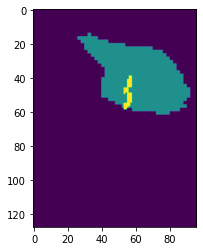

In [ ]:
# COMPROBACIÓN
prueba18_left = np.zeros((128,96))
prueba18_left[MASK_IZQ_LUNG_ID18] = 1
prueba18_left[COVID_IZQ_ID18] = 2
plt.imshow(prueba18_left)

Contraste en la imagen sin corregir: 0.9382751
Contraste en la imagen limpia de scatter de referencia: 0.8700670285804916
Contraste en la imagen limpia de scatter estimda SINGLE: 0.8684710832121072
Contraste en la imagen limpia de scatter estimda DUAL: 0.8682429815434582


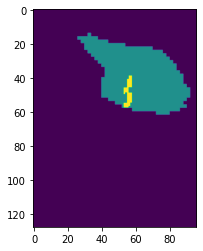

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_18NEW = np.where(MASK_IZQ_LUNG[18,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[18,:,:,0])
COVID_IZQ_ID18_NEW = np.nonzero(PROJ_MASK_IZQ_18NEW)

prueba18_left_new = np.zeros((128,96))
prueba18_left_new[MASK_IZQ_LUNG_ID18] = 1
prueba18_left_new[COVID_IZQ_ID18_NEW] = 2
plt.imshow(prueba18_left_new)

ctr_lung_total = PROJ_T_18[COVID_IZQ_ID18_NEW].mean()/PROJ_T_18[MASK_IZQ_LUNG_ID18].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_18[COVID_IZQ_ID18_NEW].mean()/PROJ_NS_ESTIM_HE_18[MASK_IZQ_LUNG_ID18].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_18[COVID_IZQ_ID18_NEW].mean()/PROJ_NS_REF_HE_18[MASK_IZQ_LUNG_ID18].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_18[COVID_IZQ_ID18_NEW].mean()/PROJ_NS_ESTIM_DUAL_18[MASK_IZQ_LUNG_ID18].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.9363682
Contraste en la imagen limpia de scatter de referencia: 0.8663531861804954
Contraste en la imagen limpia de scatter estimda SINGLE: 0.8647187169223151
Contraste en la imagen limpia de scatter estimda DUAL: 0.8644851231957483


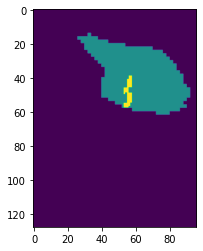

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba18_left_NC = np.zeros((128,96))
prueba18_left_NC[MASK_IZQ_LUNG_ID18] = 1
prueba18_left_NC[COVID_IZQ_ID18] = 0
id_nocovid_18left = np.nonzero(prueba18_left_NC)

prueba18_left_new = np.zeros((128,96))
prueba18_left_new[id_nocovid_18left] = 1
prueba18_left_new[COVID_IZQ_ID18_NEW] = 2
plt.imshow(prueba18_left_new)

ctr_lung_total = PROJ_T_18[COVID_IZQ_ID18_NEW].mean()/PROJ_T_18[id_nocovid_18left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_18[COVID_IZQ_ID18_NEW].mean()/PROJ_NS_ESTIM_HE_18[id_nocovid_18left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_18[COVID_IZQ_ID18_NEW].mean()/PROJ_NS_REF_HE_18[id_nocovid_18left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_18[COVID_IZQ_ID18_NEW].mean()/PROJ_NS_ESTIM_DUAL_18[id_nocovid_18left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 19 - A0534 (Pulmón dch)

In [ ]:
PROJ_T_19 = np.squeeze(PROJ_HE_T[19,:,:,0])
PROJ_NS_ESTIM_HE_19 = np.squeeze(Test_NS_ESTIM_HE[19,:,:])
PROJ_NS_ESTIM_DUAL_19 = np.squeeze(Test_NS_ESTIM_DUAL_HE[19,:,:])
PROJ_NS_REF_HE_19 = np.squeeze(Test_NS_REF_HE[19,:,:])

ctr_lung_total = PROJ_T_19[COVID_DCH_ID19].mean()/PROJ_T_19[MASK_DCH_LUNG_ID19].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_19[COVID_DCH_ID19].mean()/PROJ_NS_ESTIM_HE_19[MASK_DCH_LUNG_ID19].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_19[COVID_DCH_ID19].mean()/PROJ_NS_REF_HE_19[MASK_DCH_LUNG_ID19].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_19[COVID_DCH_ID19].mean()/PROJ_NS_ESTIM_DUAL_19[MASK_DCH_LUNG_ID19].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.70556694
Contraste en la imagen limpia de scatter de referencia: 0.5579013327100975
Contraste en la imagen limpia de scatter estimda SINGLE: 0.5366896041505854
Contraste en la imagen limpia de scatter estimda DUAL: 0.5341995224729814


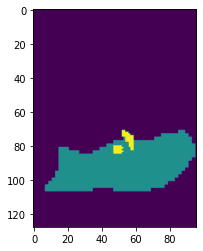

In [ ]:
# COMPROBACIÓN
prueba19_right = np.zeros((128,96))
prueba19_right[MASK_DCH_LUNG_ID19] = 1
prueba19_right[COVID_DCH_ID19] = 2
plt.imshow(prueba19_right)

Contraste en la imagen sin corregir: 0.7988085
Contraste en la imagen limpia de scatter de referencia: 0.688729287752187
Contraste en la imagen limpia de scatter estimda SINGLE: 0.6692896537981394
Contraste en la imagen limpia de scatter estimda DUAL: 0.6662069227349362


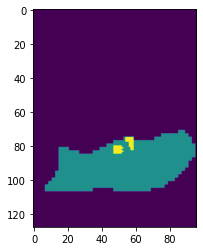

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_DCH_19NEW = np.where(MASK_DCH_LUNG[19,:,:,0] == 0,0,PROJ_MASK_DCH_ID[19,:,:,0])
COVID_DCH_ID19_NEW = np.nonzero(PROJ_MASK_DCH_19NEW)

prueba19_right_new = np.zeros((128,96))
prueba19_right_new[MASK_DCH_LUNG_ID19] = 1
prueba19_right_new[COVID_DCH_ID19_NEW] = 2
plt.imshow(prueba19_right_new)

ctr_lung_total = PROJ_T_19[COVID_DCH_ID19_NEW].mean()/PROJ_T_19[MASK_DCH_LUNG_ID19].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_19[COVID_DCH_ID19_NEW].mean()/PROJ_NS_ESTIM_HE_19[MASK_DCH_LUNG_ID19].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_19[COVID_DCH_ID19_NEW].mean()/PROJ_NS_REF_HE_19[MASK_DCH_LUNG_ID19].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_19[COVID_DCH_ID19_NEW].mean()/PROJ_NS_ESTIM_DUAL_19[MASK_DCH_LUNG_ID19].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.79459935
Contraste en la imagen limpia de scatter de referencia: 0.6831308557077621
Contraste en la imagen limpia de scatter estimda SINGLE: 0.6635124049027807
Contraste en la imagen limpia de scatter estimda DUAL: 0.6604031458532018


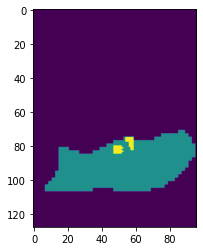

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba19_right_NC = np.zeros((128,96))
prueba19_right_NC[MASK_DCH_LUNG_ID19] = 1
prueba19_right_NC[COVID_DCH_ID19] = 0
id_nocovid_19right = np.nonzero(prueba19_right_NC)

prueba19_right_new = np.zeros((128,96))
prueba19_right_new[id_nocovid_19right] = 1
prueba19_right_new[COVID_DCH_ID19_NEW] = 2
plt.imshow(prueba19_right_new)

ctr_lung_total = PROJ_T_19[COVID_DCH_ID19_NEW].mean()/PROJ_T_19[id_nocovid_19right].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_19[COVID_DCH_ID19_NEW].mean()/PROJ_NS_ESTIM_HE_19[id_nocovid_19right].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_19[COVID_DCH_ID19_NEW].mean()/PROJ_NS_REF_HE_19[id_nocovid_19right].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_19[COVID_DCH_ID19_NEW].mean()/PROJ_NS_ESTIM_DUAL_19[id_nocovid_19right].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 20 - A0537

##### Left lung

In [ ]:
PROJ_T_20 = np.squeeze(PROJ_HE_T[20,:,:,0])
PROJ_NS_ESTIM_HE_20 = np.squeeze(Test_NS_ESTIM_HE[20,:,:])
PROJ_NS_ESTIM_DUAL_20 = np.squeeze(Test_NS_ESTIM_DUAL_HE[20,:,:])
PROJ_NS_REF_HE_20 = np.squeeze(Test_NS_REF_HE[20,:,:])

ctr_lung_total = PROJ_T_20[COVID_IZQ_ID20].mean()/PROJ_T_20[MASK_IZQ_LUNG_ID20].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_20[COVID_IZQ_ID20].mean()/PROJ_NS_ESTIM_HE_20[MASK_IZQ_LUNG_ID20].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_20[COVID_IZQ_ID20].mean()/PROJ_NS_REF_HE_20[MASK_IZQ_LUNG_ID20].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_20[COVID_IZQ_ID20].mean()/PROJ_NS_ESTIM_DUAL_20[MASK_IZQ_LUNG_ID20].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.87640077
Contraste en la imagen limpia de scatter de referencia: 0.8262331972137594
Contraste en la imagen limpia de scatter estimda SINGLE: 0.8299455935449846
Contraste en la imagen limpia de scatter estimda DUAL: 0.8231059221249979


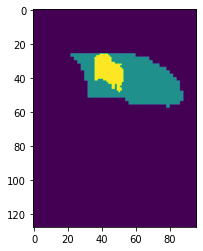

In [ ]:
# COMPROBACIÓN
prueba20_left = np.zeros((128,96))
prueba20_left[MASK_IZQ_LUNG_ID20] = 1
prueba20_left[COVID_IZQ_ID20] = 2
plt.imshow(prueba20_left)

Contraste en la imagen sin corregir: 0.87640077
Contraste en la imagen limpia de scatter de referencia: 0.8262331972137594
Contraste en la imagen limpia de scatter estimda SINGLE: 0.8299455935449846
Contraste en la imagen limpia de scatter estimda DUAL: 0.8231059221249979


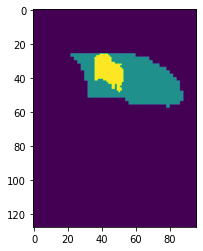

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_20NEW = np.where(MASK_IZQ_LUNG[20,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[20,:,:,0])
COVID_IZQ_ID20_NEW = np.nonzero(PROJ_MASK_IZQ_20NEW)

prueba20_left_new = np.zeros((128,96))
prueba20_left_new[MASK_IZQ_LUNG_ID20] = 1
prueba20_left_new[COVID_IZQ_ID20_NEW] = 2
plt.imshow(prueba20_left_new)

ctr_lung_total = PROJ_T_20[COVID_IZQ_ID20_NEW].mean()/PROJ_T_20[MASK_IZQ_LUNG_ID20].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_20[COVID_IZQ_ID20_NEW].mean()/PROJ_NS_ESTIM_HE_20[MASK_IZQ_LUNG_ID20].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_20[COVID_IZQ_ID20_NEW].mean()/PROJ_NS_REF_HE_20[MASK_IZQ_LUNG_ID20].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_20[COVID_IZQ_ID20_NEW].mean()/PROJ_NS_ESTIM_DUAL_20[MASK_IZQ_LUNG_ID20].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.8537256
Contraste en la imagen limpia de scatter de referencia: 0.7964916024605956
Contraste en la imagen limpia de scatter estimda SINGLE: 0.8006861250565518
Contraste en la imagen limpia de scatter estimda DUAL: 0.7929631935304706


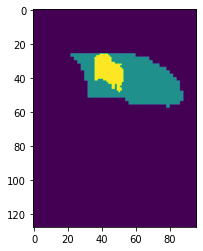

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba20_left_NC = np.zeros((128,96))
prueba20_left_NC[MASK_IZQ_LUNG_ID20] = 1
prueba20_left_NC[COVID_IZQ_ID20] = 0
id_nocovid_20left = np.nonzero(prueba20_left_NC)

prueba20_left_new = np.zeros((128,96))
prueba20_left_new[id_nocovid_20left] = 1
prueba20_left_new[COVID_IZQ_ID20_NEW] = 2
plt.imshow(prueba20_left_new)

ctr_lung_total = PROJ_T_20[COVID_IZQ_ID20_NEW].mean()/PROJ_T_20[id_nocovid_20left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_20[COVID_IZQ_ID20_NEW].mean()/PROJ_NS_ESTIM_HE_20[id_nocovid_20left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_20[COVID_IZQ_ID20_NEW].mean()/PROJ_NS_REF_HE_20[id_nocovid_20left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_20[COVID_IZQ_ID20_NEW].mean()/PROJ_NS_ESTIM_DUAL_20[id_nocovid_20left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

##### Right lung

In [ ]:
PROJ_T_20 = np.squeeze(PROJ_HE_T[20,:,:,0])
PROJ_NS_ESTIM_HE_20 = np.squeeze(Test_NS_ESTIM_HE[20,:,:])
PROJ_NS_ESTIM_DUAL_20 = np.squeeze(Test_NS_ESTIM_DUAL_HE[20,:,:])
PROJ_NS_REF_HE_20 = np.squeeze(Test_NS_REF_HE[20,:,:])

ctr_lung_total = PROJ_T_20[COVID_DCH_ID20].mean()/PROJ_T_20[MASK_DCH_LUNG_ID20].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_20[COVID_DCH_ID20].mean()/PROJ_NS_ESTIM_HE_20[MASK_DCH_LUNG_ID20].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_20[COVID_DCH_ID20].mean()/PROJ_NS_REF_HE_20[MASK_DCH_LUNG_ID20].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_20[COVID_DCH_ID20].mean()/PROJ_NS_ESTIM_DUAL_20[MASK_DCH_LUNG_ID20].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.6407953
Contraste en la imagen limpia de scatter de referencia: 0.4815884376975523
Contraste en la imagen limpia de scatter estimda SINGLE: 0.4650359361207259
Contraste en la imagen limpia de scatter estimda DUAL: 0.47865797434423873


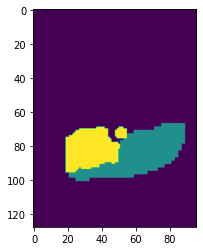

In [ ]:
# COMPROBACIÓN
prueba20_right = np.zeros((128,96))
prueba20_right[MASK_DCH_LUNG_ID20] = 1
prueba20_right[COVID_DCH_ID20] = 2
plt.imshow(prueba20_right)

Contraste en la imagen sin corregir: 0.9123426
Contraste en la imagen limpia de scatter de referencia: 0.9237875070810138
Contraste en la imagen limpia de scatter estimda SINGLE: 0.9043653738719453
Contraste en la imagen limpia de scatter estimda DUAL: 0.9041441487536332


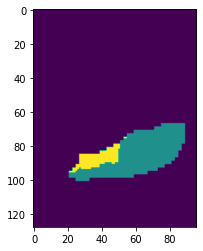

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_DCH_20NEW = np.where(MASK_DCH_LUNG[20,:,:,0] == 0,0,PROJ_MASK_DCH_ID[20,:,:,0])
COVID_DCH_ID20_NEW = np.nonzero(PROJ_MASK_DCH_20NEW)

prueba20_right_new = np.zeros((128,96))
prueba20_right_new[MASK_DCH_LUNG_ID20] = 1
prueba20_right_new[COVID_DCH_ID20_NEW] = 2
plt.imshow(prueba20_right_new)

ctr_lung_total = PROJ_T_20[COVID_DCH_ID20_NEW].mean()/PROJ_T_20[MASK_DCH_LUNG_ID20].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_20[COVID_DCH_ID20_NEW].mean()/PROJ_NS_ESTIM_HE_20[MASK_DCH_LUNG_ID20].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_20[COVID_DCH_ID20_NEW].mean()/PROJ_NS_REF_HE_20[MASK_DCH_LUNG_ID20].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_20[COVID_DCH_ID20_NEW].mean()/PROJ_NS_ESTIM_DUAL_20[MASK_DCH_LUNG_ID20].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.89634264
Contraste en la imagen limpia de scatter de referencia: 0.9096697644376468
Contraste en la imagen limpia de scatter estimda SINGLE: 0.8870895814858383
Contraste en la imagen limpia de scatter estimda DUAL: 0.8868333941537156


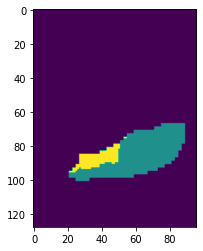

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba20_right_NC = np.zeros((128,96))
prueba20_right_NC[MASK_DCH_LUNG_ID20] = 1
prueba20_right_NC[COVID_DCH_ID20] = 0
id_nocovid_20right = np.nonzero(prueba20_right_NC)

prueba20_right_new = np.zeros((128,96))
prueba20_right_new[id_nocovid_20right] = 1
prueba20_right_new[COVID_DCH_ID20_NEW] = 2
plt.imshow(prueba20_right_new)

ctr_lung_total = PROJ_T_20[COVID_DCH_ID20_NEW].mean()/PROJ_T_20[id_nocovid_20right].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_20[COVID_DCH_ID20_NEW].mean()/PROJ_NS_ESTIM_HE_20[id_nocovid_20right].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_20[COVID_DCH_ID20_NEW].mean()/PROJ_NS_REF_HE_20[id_nocovid_20right].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_20[COVID_DCH_ID20_NEW].mean()/PROJ_NS_ESTIM_DUAL_20[id_nocovid_20right].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

#### Case 21 - A0547 (Pulmón izq)

In [ ]:
PROJ_T_21 = np.squeeze(PROJ_HE_T[21,:,:,0])
PROJ_NS_ESTIM_HE_21 = np.squeeze(Test_NS_ESTIM_HE[21,:,:])
PROJ_NS_ESTIM_DUAL_21 = np.squeeze(Test_NS_ESTIM_DUAL_HE[21,:,:])
PROJ_NS_REF_HE_21 = np.squeeze(Test_NS_REF_HE[21,:,:])

ctr_lung_total = PROJ_T_21[COVID_IZQ_ID21].mean()/PROJ_T_21[MASK_IZQ_LUNG_ID21].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_21[COVID_IZQ_ID21].mean()/PROJ_NS_ESTIM_HE_21[MASK_IZQ_LUNG_ID21].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_21[COVID_IZQ_ID21].mean()/PROJ_NS_REF_HE_21[MASK_IZQ_LUNG_ID21].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_21[COVID_IZQ_ID21].mean()/PROJ_NS_ESTIM_DUAL_21[MASK_IZQ_LUNG_ID21].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 0.8389471
Contraste en la imagen limpia de scatter de referencia: 0.7944764335203366
Contraste en la imagen limpia de scatter estimda SINGLE: 0.8086962920035794
Contraste en la imagen limpia de scatter estimda DUAL: 0.8022979479532175


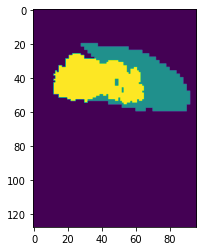

In [ ]:
# COMPROBACIÓN
prueba21_left = np.zeros((128,96))
prueba21_left[MASK_IZQ_LUNG_ID21] = 1
prueba21_left[COVID_IZQ_ID21] = 2
plt.imshow(prueba21_left)

Contraste en la imagen sin corregir: 1.2322793
Contraste en la imagen limpia de scatter de referencia: 1.3585948621913948
Contraste en la imagen limpia de scatter estimda SINGLE: 1.369926644447703
Contraste en la imagen limpia de scatter estimda DUAL: 1.3673113784587951


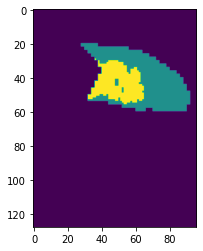

In [ ]:
# CORRECCIÓN REGIÓN COVID
PROJ_MASK_IZQ_21NEW = np.where(MASK_IZQ_LUNG[21,:,:,0] == 0,0,PROJ_MASK_IZQ_ID[21,:,:,0])
COVID_IZQ_ID21_NEW = np.nonzero(PROJ_MASK_IZQ_21NEW)

prueba21_left_new = np.zeros((128,96))
prueba21_left_new[MASK_IZQ_LUNG_ID21] = 1
prueba21_left_new[COVID_IZQ_ID21_NEW] = 2
plt.imshow(prueba21_left_new)

ctr_lung_total = PROJ_T_21[COVID_IZQ_ID21_NEW].mean()/PROJ_T_21[MASK_IZQ_LUNG_ID21].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_21[COVID_IZQ_ID21_NEW].mean()/PROJ_NS_ESTIM_HE_21[MASK_IZQ_LUNG_ID21].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_21[COVID_IZQ_ID21_NEW].mean()/PROJ_NS_REF_HE_21[MASK_IZQ_LUNG_ID21].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_21[COVID_IZQ_ID21_NEW].mean()/PROJ_NS_ESTIM_DUAL_21[MASK_IZQ_LUNG_ID21].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

Contraste en la imagen sin corregir: 1.3887686
Contraste en la imagen limpia de scatter de referencia: 1.6447069857402568
Contraste en la imagen limpia de scatter estimda SINGLE: 1.6695357406847513
Contraste en la imagen limpia de scatter estimda DUAL: 1.6637760196349998


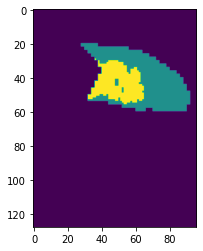

In [ ]:
# CONTRASTE ZONA COVID/ZONA NO-COVID
prueba21_left_NC = np.zeros((128,96))
prueba21_left_NC[MASK_IZQ_LUNG_ID21] = 1
prueba21_left_NC[COVID_IZQ_ID21] = 0
id_nocovid_21left = np.nonzero(prueba21_left_NC)

prueba21_left_new = np.zeros((128,96))
prueba21_left_new[id_nocovid_21left] = 1
prueba21_left_new[COVID_IZQ_ID21_NEW] = 2
plt.imshow(prueba21_left_new)

ctr_lung_total = PROJ_T_21[COVID_IZQ_ID21_NEW].mean()/PROJ_T_21[id_nocovid_21left].mean() #/PROJ_T_0[MASK_IZQ_LUNG_ID0].mean()
ctr_lung_limpiaHE = PROJ_NS_ESTIM_HE_21[COVID_IZQ_ID21_NEW].mean()/PROJ_NS_ESTIM_HE_21[id_nocovid_21left].mean()
ctr_lung_limpiaREF = PROJ_NS_REF_HE_21[COVID_IZQ_ID21_NEW].mean()/PROJ_NS_REF_HE_21[id_nocovid_21left].mean()
ctr_lung_limpiaDUAL = PROJ_NS_ESTIM_DUAL_21[COVID_IZQ_ID21_NEW].mean()/PROJ_NS_ESTIM_DUAL_21[id_nocovid_21left].mean()

print('Contraste en la imagen sin corregir:',ctr_lung_total)
print('Contraste en la imagen limpia de scatter de referencia:',ctr_lung_limpiaREF)
print('Contraste en la imagen limpia de scatter estimda SINGLE:',ctr_lung_limpiaHE)
print('Contraste en la imagen limpia de scatter estimda DUAL:',ctr_lung_limpiaDUAL)

# plt.imshow(prueba0_left_NC)

(-0.5, 127.5, 95.5, -0.5)

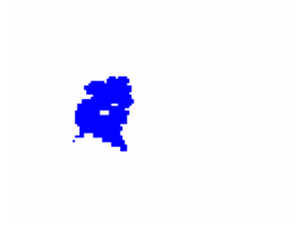

In [ ]:
covid21_left = np.zeros((128,96))
covid21_left[COVID_IZQ_ID21_NEW] = -1
plt.figure()
plt.imshow(np.rot90(covid21_left),cmap='seismic',vmin=-2,vmax=2)
plt.axis('off')

(-0.5, 127.5, 95.5, -0.5)

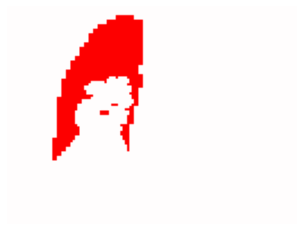

In [ ]:
lung21_left = np.zeros((128,96))
lung21_left[id_nocovid_21left] = 1
plt.figure()
plt.imshow(np.rot90(lung21_left),vmin=-2,vmax=2,cmap='seismic')
plt.axis('off')

### Metrics Comparison Contrast

#### Covid/Lung

In [ ]:
C_unc = [1.114,1.112,1.021,1.318,1.229,1.071,1.120,1.149,1.348,1.155,1.044,1.242,1.394,1.089,1.085,1.051,0.887,1.122,1.033,0.970,1.168,1.348,1.197,1.232]
C_corr_gt = [1.179,1.176,1.084,1.426,1.354,1.101,1.173,1.335,1.578,1.200,1.116,1.458,1.655,1.123,1.154,1.058,0.896,1.134,1.061,0.994,1.241,1.444,1.279,1.359]
C_corr_HE = [1.179,1.179,1.077,1.455,1.341,1.102,1.167,1.320,1.574,1.196,1.108,1.464,1.660,1.127,1.146,1.060,0.892,1.131,1.068,0.990,1.242,1.459,1.291,1.370]
C_corr_DUAL = [1.176,1.177,1.078,1.428,1.340,1.102,1.166,1.316,1.551,1.193,1.111,1.462,1.649,1.129,1.158,1.057,0.911,1.130,1.065,0.992,1.241,1.450,1.291,1.367]

ganancia_gt = np.zeros(len(C_unc))
ganancia_HE = np.zeros(len(C_unc))
ganancia_DUAL = np.zeros(len(C_unc))
DIF_pct_HE = np.zeros(len(C_unc))
DIF_pct_DUAL = np.zeros(len(C_unc))
for i in range(len(C_unc)):
  ganancia_gt[i] = (C_corr_gt[i]/C_unc[i]-1)*100
  ganancia_HE[i] = (C_corr_HE[i]/C_unc[i]-1)*100
  ganancia_DUAL[i] = (C_corr_DUAL[i]/C_unc[i]-1)*100
  DIF_pct_HE[i] = 100*abs(C_corr_gt[i]-C_corr_HE[i])/C_corr_gt[i]
  DIF_pct_DUAL[i] = 100*abs(C_corr_gt[i]-C_corr_DUAL[i])/C_corr_gt[i]

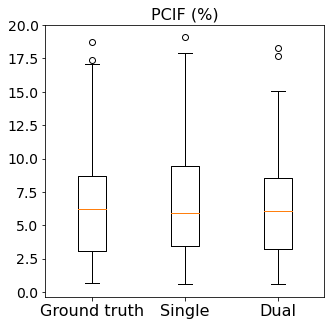

In [ ]:
#MultipleBoxplot - Contrast Improvement
labels = ['Ground truth', 'Single', 'Dual']
Ganancia_boxplt = np.zeros((len(C_unc),3))
Ganancia_boxplt[:,0] = ganancia_gt
Ganancia_boxplt[:,1] = ganancia_HE
Ganancia_boxplt[:,2] = ganancia_DUAL
#Test_MAPE_boxplt = np.transpose(Test_MAPE_boxplt)
plt.figure(figsize=(5,5))
plt.boxplot(Ganancia_boxplt, vert=True, patch_artist=False, labels=labels, showmeans=False)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.title('PCIF (%)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.show()

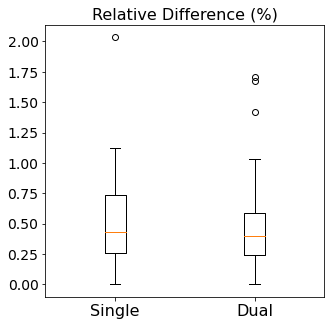

In [ ]:
#MultipleBoxplot - Relative Difference (%)
labels = ['Single', 'Dual']
DIFREL_boxplt = np.zeros((len(C_unc),2))
DIFREL_boxplt[:,0] = DIF_pct_HE
DIFREL_boxplt[:,1] = DIF_pct_DUAL
#Test_MAPE_boxplt = np.transpose(Test_MAPE_boxplt)
plt.figure(figsize=(5,5))
plt.boxplot(DIFREL_boxplt, vert=True, patch_artist=False, labels=labels, showmeans=False)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.title('Relative Difference (%)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# p-value (Single, Dual)
stats.ttest_ind(Ganancia_boxplt[:,1], Ganancia_boxplt[:,2])

Ttest_indResult(statistic=0.09894665210850775, pvalue=0.9216105670085697)

In [ ]:
print(ganancia_gt)
print(ganancia_gt.mean())

[ 5.83482944  5.75539568  6.17042116  8.19423369 10.17087063  2.80112045
  4.73214286 16.18798956 17.06231454  3.8961039   6.89655172 17.39130435
 18.723099    3.12213039  6.359447    0.66603235  1.01465614  1.06951872
  2.71055179  2.4742268   6.25        7.12166172  6.85045948 10.30844156]
7.1568126220377835


In [ ]:
print(ganancia_HE)
print(ganancia_HE.mean())

[ 5.83482944  6.02517986  5.48481881 10.39453718  9.11310008  2.89449113
  4.19642857 14.88250653 16.76557864  3.54978355  6.1302682  17.87439614
 19.08177905  3.48943985  5.62211982  0.85632731  0.56369786  0.80213904
  3.38818974  2.06185567  6.33561644  8.23442136  7.85296575 11.2012987 ]
7.193157029045769


In [ ]:
print(ganancia_DUAL)
print(ganancia_DUAL.mean())

[ 5.56552962  5.84532374  5.582762    8.34597876  9.03173312  2.89449113
  4.10714286 14.53437772 15.05934718  3.29004329  6.41762452 17.71336554
 18.29268293  3.67309458  6.7281106   0.57088487  2.70574972  0.71301248
  3.09777348  2.26804124  6.25        7.56676558  7.85296575 10.95779221]
7.044358037266956


In [ ]:
print(DIFREL_boxplt)
print(DIF_pct_HE.mean())
print(DIF_pct_DUAL.mean())

[[0.         0.25445293]
 [0.25510204 0.08503401]
 [0.64575646 0.55350554]
 [2.03366059 0.14025245]
 [0.96011817 1.03397341]
 [0.09082652 0.09082652]
 [0.51150895 0.59676044]
 [1.12359551 1.42322097]
 [0.25348542 1.71102662]
 [0.33333333 0.58333333]
 [0.71684588 0.44802867]
 [0.41152263 0.27434842]
 [0.3021148  0.36253776]
 [0.35618878 0.53428317]
 [0.6932409  0.34662045]
 [0.18903592 0.09451796]
 [0.44642857 1.67410714]
 [0.26455026 0.35273369]
 [0.65975495 0.37700283]
 [0.40241449 0.20120724]
 [0.08058018 0.        ]
 [1.03878116 0.41551247]
 [0.93823299 0.93823299]
 [0.80941869 0.58866814]]
0.5631873834263693
0.5450077986276022


#### Covid/No-Covid

In [ ]:
C_unc = [1.252,1.186,1.023,1.405,1.245,1.174,1.344,1.163,1.369,1.170,1.074,1.276,1.424,1.134,1.129,1.060,0.884,1.134,1.047,0.955,1.175,1.371,1.228,1.389]
C_corr_gt = [1.425,1.304,1.094,1.554,1.382,1.258,1.545,1.375,1.620,1.219,1.209,1.535,1.716,1.188,1.242,1.067,0.894,1.148,1.086,0.991,1.251,1.474,1.326,1.645]
C_corr_HE = [1.424,1.311,1.086,1.596,1.368,1.261,1.521,1.357,1.615,1.215,1.194,1.542,1.721,1.195,1.230,1.070,0.889,1.145,1.097,0.985,1.252,1.491,1.340,1.670]
C_corr_DUAL = [1.418,1.306,1.087,1.556,1.367,1.261,1.517,1.352,1.590,1.212,1.200,1.539,1.709,1.198,1.249,1.066,0.909,1.143,1.092,0.988,1.251,1.481,1.340,1.664]

ganancia_gt = np.zeros(len(C_unc))
ganancia_HE = np.zeros(len(C_unc))
ganancia_DUAL = np.zeros(len(C_unc))
DIF_pct_HE = np.zeros(len(C_unc))
DIF_pct_DUAL = np.zeros(len(C_unc))
for i in range(len(C_unc)):
  ganancia_gt[i] = (C_corr_gt[i]/C_unc[i]-1)*100
  ganancia_HE[i] = (C_corr_HE[i]/C_unc[i]-1)*100
  ganancia_DUAL[i] = (C_corr_DUAL[i]/C_unc[i]-1)*100
  DIF_pct_HE[i] = 100*abs(C_corr_gt[i]-C_corr_HE[i])/C_corr_gt[i]
  DIF_pct_DUAL[i] = 100*abs(C_corr_gt[i]-C_corr_DUAL[i])/C_corr_gt[i]

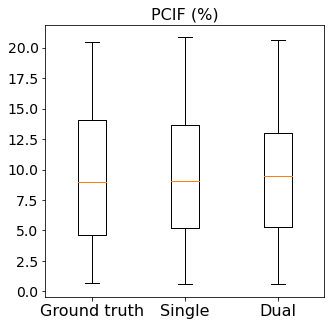

In [ ]:
#MultipleBoxplot - Contrast Improvement
labels = ['Ground truth', 'Single', 'Dual']
Ganancia_boxplt = np.zeros((len(C_unc),3))
Ganancia_boxplt[:,0] = ganancia_gt
Ganancia_boxplt[:,1] = ganancia_HE
Ganancia_boxplt[:,2] = ganancia_DUAL
#Test_MAPE_boxplt = np.transpose(Test_MAPE_boxplt)
plt.figure(figsize=(5,5))
plt.boxplot(Ganancia_boxplt, vert=True, patch_artist=False, labels=labels, showmeans=False)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.title('PCIF (%)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.show()

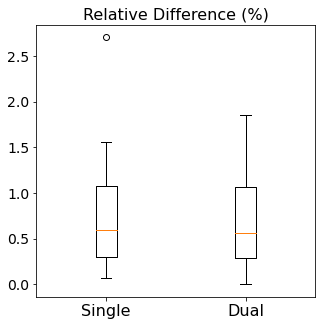

In [ ]:
#MultipleBoxplot - Relative Difference (%)
labels = ['Single', 'Dual']
DIFREL_boxplt = np.zeros((len(C_unc),2))
DIFREL_boxplt[:,0] = DIF_pct_HE
DIFREL_boxplt[:,1] = DIF_pct_DUAL
#Test_MAPE_boxplt = np.transpose(Test_MAPE_boxplt)
plt.figure(figsize=(5,5))
plt.boxplot(DIFREL_boxplt, vert=True, patch_artist=False, labels=labels, showmeans=False)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.title('Relative Difference (%)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# p-value (Single, Dual)
stats.ttest_ind(Ganancia_boxplt[:,1], Ganancia_boxplt[:,2])

Ttest_indResult(statistic=0.11387601485763409, pvalue=0.9098316552396971)

In [ ]:
print(ganancia_gt)
print(ganancia_gt.mean())

[13.81789137  9.94940978  6.94037146 10.60498221 11.00401606  7.15502555
 14.95535714 18.22871883 18.33455077  4.18803419 12.5698324  20.29780564
 20.50561798  4.76190476 10.0088574   0.66037736  1.13122172  1.2345679
  3.72492837  3.76963351  6.46808511  7.51276441  7.98045603 18.43052556]
9.759788978910542


In [ ]:
print(ganancia_HE)
print(ganancia_HE.mean())

[13.73801917 10.53962901  6.15835777 13.59430605  9.87951807  7.41056218
 13.16964286 16.68099742 17.96932067  3.84615385 11.17318436 20.84639498
 20.85674157  5.37918871  8.94596988  0.94339623  0.56561086  0.97001764
  4.77554919  3.14136126  6.55319149  8.75273523  9.12052117 20.23038157]
9.801697966048515


In [ ]:
print(ganancia_DUAL)
print(ganancia_DUAL.mean())

[13.25878594 10.11804384  6.25610948 10.74733096  9.79919679  7.41056218
 12.87202381 16.25107481 16.1431702   3.58974359 11.73184358 20.61128527
 20.01404494  5.64373898 10.62887511  0.56603774  2.8280543   0.79365079
  4.29799427  3.45549738  6.46808511  8.02334063  9.12052117 19.79841613]
9.601142791127193


In [ ]:
print(DIFREL_boxplt)
print(DIF_pct_HE.mean())
print(DIF_pct_DUAL.mean())

[[0.07017544 0.49122807]
 [0.53680982 0.15337423]
 [0.73126143 0.63985375]
 [2.7027027  0.12870013]
 [1.0130246  1.0853835 ]
 [0.23847377 0.23847377]
 [1.55339806 1.81229773]
 [1.30909091 1.67272727]
 [0.30864198 1.85185185]
 [0.32813782 0.57424118]
 [1.24069479 0.74441687]
 [0.45602606 0.26058632]
 [0.29137529 0.40792541]
 [0.58922559 0.84175084]
 [0.96618357 0.56360709]
 [0.28116214 0.09372071]
 [0.55928412 1.67785235]
 [0.26132404 0.43554007]
 [1.01289134 0.55248619]
 [0.60544904 0.30272452]
 [0.07993605 0.        ]
 [1.15332429 0.47489824]
 [1.05580694 1.05580694]
 [1.51975684 1.1550152 ]]
0.7860065255607864
0.7172692595532326


## PRUEBA: DSD=185 cm

### Load Projections

In [ ]:
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_SHE_A-0462_DSD185.raw'
PROJ_SHE = np.fromfile(filename,dtype='float32')
PROJ_SHE = np.reshape(PROJ_SHE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_NSHE_A-0462_DSD185.raw'
PROJ_NSHE = np.fromfile(filename,dtype='float32')
PROJ_NSHE = np.reshape(PROJ_NSHE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_THE_A-0462_DSD185.raw'
PROJ_THE = np.fromfile(filename,dtype='float32')
PROJ_THE = np.reshape(PROJ_THE,(2050,2050))


In [ ]:
PROJ_SHE = np.expand_dims(PROJ_SHE,axis=-1)
PROJ_SHE = np.expand_dims(PROJ_SHE,axis=0)
PROJ_NSHE = np.expand_dims(PROJ_NSHE,axis=-1)
PROJ_NSHE = np.expand_dims(PROJ_NSHE,axis=0)
PROJ_THE = np.expand_dims(PROJ_THE,axis=-1)
PROJ_THE = np.expand_dims(PROJ_THE,axis=0)

PROJ_SHE = tf.convert_to_tensor(PROJ_SHE, tf.float32)
PROJ_NSHE = tf.convert_to_tensor(PROJ_NSHE, tf.float32)
PROJ_THE = tf.convert_to_tensor(PROJ_THE, tf.float32)

Nx2 = 128 #256
Ny2 = 128

PROJ_SHE = tf.image.resize(PROJ_SHE,[Nx2,Ny2],method='bilinear')
PROJ_NSHE = tf.image.resize(PROJ_NSHE,[Nx2,Ny2],method='bilinear')
PROJ_THE = tf.image.resize(PROJ_THE,[Nx2,Ny2],method='bilinear')

In [ ]:
PROJ_SHE = PROJ_SHE.numpy()

PROJ_THE = PROJ_THE.numpy()

PROJ_NSHE = PROJ_NSHE.numpy()

In [ ]:
PROJ_SHE = PROJ_SHE[:,:,16:112,:]

PROJ_THE = PROJ_THE[:,:,16:112,:]

PROJ_NSHE = PROJ_NSHE[:,:,16:112,:]

In [ ]:
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_SLE_A-0462_DSD185.raw'
PROJ_SLE = np.fromfile(filename,dtype='float32')
PROJ_SLE = np.reshape(PROJ_SLE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_NSLE_A-0462_DSD185.raw'
PROJ_NSLE = np.fromfile(filename,dtype='float32')
PROJ_NSLE = np.reshape(PROJ_NSLE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_TLE_A-0462_DSD185.raw'
PROJ_TLE = np.fromfile(filename,dtype='float32')
PROJ_TLE = np.reshape(PROJ_TLE,(2050,2050))


In [ ]:
PROJ_SLE = np.expand_dims(PROJ_SLE,axis=-1)
PROJ_SLE = np.expand_dims(PROJ_SLE,axis=0)
PROJ_NSLE = np.expand_dims(PROJ_NSLE,axis=-1)
PROJ_NSLE = np.expand_dims(PROJ_NSLE,axis=0)
PROJ_TLE = np.expand_dims(PROJ_TLE,axis=-1)
PROJ_TLE = np.expand_dims(PROJ_TLE,axis=0)

PROJ_SLE = tf.convert_to_tensor(PROJ_SLE, tf.float32)
PROJ_NSLE = tf.convert_to_tensor(PROJ_NSLE, tf.float32)
PROJ_TLE = tf.convert_to_tensor(PROJ_TLE, tf.float32)

Nx2 = 128 #256
Ny2 = 128

PROJ_SLE = tf.image.resize(PROJ_SLE,[Nx2,Ny2],method='bilinear')
PROJ_NSLE = tf.image.resize(PROJ_NSLE,[Nx2,Ny2],method='bilinear')
PROJ_TLE = tf.image.resize(PROJ_TLE,[Nx2,Ny2],method='bilinear')

In [ ]:
PROJ_SLE = PROJ_SLE.numpy()

PROJ_TLE = PROJ_TLE.numpy()

PROJ_NSLE = PROJ_NSLE.numpy()

In [ ]:
PROJ_SLE = PROJ_SLE[:,:,16:112,:]

PROJ_TLE = PROJ_TLE[:,:,16:112,:]

PROJ_NSLE = PROJ_NSLE[:,:,16:112,:]

### Estimación y Corrección Scatter - Single Energy

In [ ]:
input_HE = np.concatenate([PROJ_THE,PROJ_THE/PROJ_SHE,PROJ_SHE],-1)
# input_DUAL = np.concatenate([total_LE,total_HE,scat_ref_HE/total_HE],-1)

In [ ]:
test_HE = input_HE #np.expand_dims(input_HE[idx+100,:,:,:],axis=0)
estim_HE = model_HE.predict(test_HE)
#TOT_LE = np.squeeze(test_LE)
ST_ESTIM_HE = np.squeeze(estim_HE)
S_ESTIM_HE = ST_ESTIM_HE*np.squeeze(PROJ_THE[0,:,:,0])
NS_ESTIM_HE = np.squeeze(PROJ_THE[0,:,:,0])-S_ESTIM_HE
#S_ESTIM_HE[idx,:,:] = np.where(S_ESTIM_HE[idx,:,:] < 0,0,S_ESTIM_HE[idx,:,:])
S_REF_HE = np.squeeze(PROJ_SHE[0,:,:,0])
NS_REF_HE = np.squeeze(PROJ_NSHE[0,:,:,0])

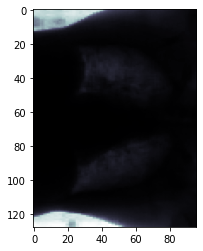

In [ ]:
plt.imshow(NS_ESTIM_HE,cmap=plt.cm.bone)

### Metrics - Single Energy

In [ ]:
# PARA IMÁGENES RECORTADAS + ROI
lineah1 = 15
lineah2 = 110
lineav2 = 90


# MODELO SINGLE
DIF_HE_rel = np.mean(abs(S_REF_HE[lineah1:lineah2,0:lineav2]-S_ESTIM_HE[lineah1:lineah2,0:lineav2])/(S_REF_HE[lineah1:lineah2,0:lineav2]+S_ESTIM_HE[lineah1:lineah2,0:lineav2]))
DIF_HE_NSrel = np.mean(abs(NS_REF_HE[lineah1:lineah2,0:lineav2]-NS_ESTIM_HE[lineah1:lineah2,0:lineav2])/(NS_REF_HE[lineah1:lineah2,0:lineav2]+NS_ESTIM_HE[lineah1:lineah2,0:lineav2]))
MAPE_S_HE = mean_absolute_percentage_error(S_REF_HE[lineah1:lineah2,0:lineav2],S_ESTIM_HE[lineah1:lineah2,0:lineav2])
MAPE_NS_HE = mean_absolute_percentage_error(NS_REF_HE[lineah1:lineah2,0:lineav2],NS_ESTIM_HE[lineah1:lineah2,0:lineav2])
MSE_S_HE = mean_squared_error(S_REF_HE[lineah1:lineah2,0:lineav2],S_ESTIM_HE[lineah1:lineah2,0:lineav2])
MSE_NS_HE = mean_squared_error(NS_REF_HE[lineah1:lineah2,0:lineav2],NS_ESTIM_HE[lineah1:lineah2,0:lineav2])
SSIM_S_single = ssim(S_REF_HE[lineah1:lineah2,0:lineav2],S_ESTIM_HE[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_NS_single = ssim(NS_REF_HE[lineah1:lineah2,0:lineav2],NS_ESTIM_HE[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_S_HE0 = SSIM_S_single[0]
SSIM_NS_HE0 = SSIM_NS_single[0]


In [ ]:
print('Diferencia relativa: ',DIF_HE_NSrel)
print('MAPE: ',MAPE_NS_HE)
print('MSE: ',MSE_NS_HE)
print('SSIM: ',SSIM_NS_HE0)

Diferencia relativa:  0.05374261
MAPE:  0.11519477
MSE:  6.214116e-06
SSIM:  0.9979988153236495


### Estimación y Corrección Scatter - Dual Energy

In [ ]:
# input_HE = np.concatenate([PROJ_THE,PROJ_THE/PROJ_SHE,PROJ_SHE],-1)
input_DUAL = np.concatenate([PROJ_TLE,PROJ_THE,PROJ_SHE/PROJ_THE],-1)

In [ ]:
test_DUAL = input_DUAL #np.expand_dims(x_val_DUAL_2chn[idx,:,1:129,:],axis=0)
estim_DUAL = model_DUAL.predict(test_DUAL)
ST_ESTIM_DUAL_185 = np.squeeze(estim_DUAL[:,:,:,0]) #Para sólo un canal en el output // Si hay dos canales: estim_DUAL[:,:,:,1]
S_ESTIM_DUAL_185 = ST_ESTIM_DUAL_185*np.squeeze(PROJ_THE[0,:,:,0])
NS_ESTIM_DUAL_185 = np.squeeze(PROJ_THE[0,:,:,0])-S_ESTIM_DUAL_185
S_REF_HE_185 = np.squeeze(PROJ_SHE[0,:,:,0])
NS_REF_HE_185 = np.squeeze(PROJ_NSHE[0,:,:,0])

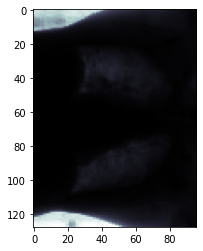

In [ ]:
plt.imshow(NS_ESTIM_DUAL_185,cmap=plt.cm.bone)

### Metrics - Dual Energy

In [ ]:
# PARA IMÁGENES RECORTADAS + ROI
lineah1 = 15
lineah2 = 110
lineav2 = 90


# MODELO DUAL
DIF_DUAL_rel = np.mean(abs(S_REF_HE_185[lineah1:lineah2,0:lineav2]-S_ESTIM_DUAL_185[lineah1:lineah2,0:lineav2])/(S_REF_HE_185[lineah1:lineah2,0:lineav2]+S_ESTIM_DUAL_185[lineah1:lineah2,0:lineav2]))
DIF_DUAL_NSrel = np.mean(abs(NS_REF_HE_185[lineah1:lineah2,0:lineav2]-NS_ESTIM_DUAL_185[lineah1:lineah2,0:lineav2])/(NS_REF_HE_185[lineah1:lineah2,0:lineav2]+NS_ESTIM_DUAL_185[lineah1:lineah2,0:lineav2]))
MAPE_S_DUAL = mean_absolute_percentage_error(S_REF_HE_185[lineah1:lineah2,0:lineav2],S_ESTIM_DUAL_185[lineah1:lineah2,0:lineav2])
MAPE_NS_DUAL = mean_absolute_percentage_error(NS_REF_HE_185[lineah1:lineah2,0:lineav2],NS_ESTIM_DUAL_185[lineah1:lineah2,0:lineav2])
MSE_S_DUAL = mean_squared_error(S_REF_HE_185[lineah1:lineah2,0:lineav2],S_ESTIM_DUAL_185[lineah1:lineah2,0:lineav2])
MSE_NS_DUAL = mean_squared_error(NS_REF_HE_185[lineah1:lineah2,0:lineav2],NS_ESTIM_DUAL_185[lineah1:lineah2,0:lineav2])
SSIM_S_dual = ssim(S_REF_HE_185[lineah1:lineah2,0:lineav2],S_ESTIM_DUAL_185[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_NS_dual = ssim(NS_REF_HE_185[lineah1:lineah2,0:lineav2],NS_ESTIM_DUAL_185[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_S_DUAL0 = SSIM_S_dual[0]
SSIM_NS_DUAL0 = SSIM_NS_dual[0]


In [ ]:
print('Diferencia relativa: ',DIF_DUAL_NSrel)
print('MAPE: ',MAPE_NS_DUAL)
print('MSE: ',MSE_NS_DUAL)
print('SSIM: ',SSIM_NS_DUAL0)

Diferencia relativa:  0.04712788
MAPE:  0.08944173
MSE:  5.5762453e-06
SSIM:  0.9981750551113783


## PRUEBA: DSD=175 cm

### Load Projections

In [ ]:
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_SHE_A-0462_DSD175.raw'
PROJ_SHE = np.fromfile(filename,dtype='float32')
PROJ_SHE = np.reshape(PROJ_SHE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_NSHE_A-0462_DSD175.raw'
PROJ_NSHE = np.fromfile(filename,dtype='float32')
PROJ_NSHE = np.reshape(PROJ_NSHE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_THE_A-0462_DSD175.raw'
PROJ_THE = np.fromfile(filename,dtype='float32')
PROJ_THE = np.reshape(PROJ_THE,(2050,2050))


In [ ]:
PROJ_SHE = np.expand_dims(PROJ_SHE,axis=-1)
PROJ_SHE = np.expand_dims(PROJ_SHE,axis=0)
PROJ_NSHE = np.expand_dims(PROJ_NSHE,axis=-1)
PROJ_NSHE = np.expand_dims(PROJ_NSHE,axis=0)
PROJ_THE = np.expand_dims(PROJ_THE,axis=-1)
PROJ_THE = np.expand_dims(PROJ_THE,axis=0)

PROJ_SHE = tf.convert_to_tensor(PROJ_SHE, tf.float32)
PROJ_NSHE = tf.convert_to_tensor(PROJ_NSHE, tf.float32)
PROJ_THE = tf.convert_to_tensor(PROJ_THE, tf.float32)

Nx2 = 128 #256
Ny2 = 128

PROJ_SHE = tf.image.resize(PROJ_SHE,[Nx2,Ny2],method='bilinear')
PROJ_NSHE = tf.image.resize(PROJ_NSHE,[Nx2,Ny2],method='bilinear')
PROJ_THE = tf.image.resize(PROJ_THE,[Nx2,Ny2],method='bilinear')

In [ ]:
PROJ_SHE = PROJ_SHE.numpy()

PROJ_THE = PROJ_THE.numpy()

PROJ_NSHE = PROJ_NSHE.numpy()

In [ ]:
PROJ_SHE = PROJ_SHE[:,:,16:112,:]

PROJ_THE = PROJ_THE[:,:,16:112,:]

PROJ_NSHE = PROJ_NSHE[:,:,16:112,:]

In [ ]:
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_SLE_A-0462_DSD175.raw'
PROJ_SLE = np.fromfile(filename,dtype='float32')
PROJ_SLE = np.reshape(PROJ_SLE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_NSLE_A-0462_DSD175.raw'
PROJ_NSLE = np.fromfile(filename,dtype='float32')
PROJ_NSLE = np.reshape(PROJ_NSLE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_TLE_A-0462_DSD175.raw'
PROJ_TLE = np.fromfile(filename,dtype='float32')
PROJ_TLE = np.reshape(PROJ_TLE,(2050,2050))


In [ ]:
PROJ_SLE = np.expand_dims(PROJ_SLE,axis=-1)
PROJ_SLE = np.expand_dims(PROJ_SLE,axis=0)
PROJ_NSLE = np.expand_dims(PROJ_NSLE,axis=-1)
PROJ_NSLE = np.expand_dims(PROJ_NSLE,axis=0)
PROJ_TLE = np.expand_dims(PROJ_TLE,axis=-1)
PROJ_TLE = np.expand_dims(PROJ_TLE,axis=0)

PROJ_SLE = tf.convert_to_tensor(PROJ_SLE, tf.float32)
PROJ_NSLE = tf.convert_to_tensor(PROJ_NSLE, tf.float32)
PROJ_TLE = tf.convert_to_tensor(PROJ_TLE, tf.float32)

Nx2 = 128 #256
Ny2 = 128

PROJ_SLE = tf.image.resize(PROJ_SLE,[Nx2,Ny2],method='bilinear')
PROJ_NSLE = tf.image.resize(PROJ_NSLE,[Nx2,Ny2],method='bilinear')
PROJ_TLE = tf.image.resize(PROJ_TLE,[Nx2,Ny2],method='bilinear')

In [ ]:
PROJ_SLE = PROJ_SLE.numpy()

PROJ_TLE = PROJ_TLE.numpy()

PROJ_NSLE = PROJ_NSLE.numpy()

In [ ]:
PROJ_SLE = PROJ_SLE[:,:,16:112,:]

PROJ_TLE = PROJ_TLE[:,:,16:112,:]

PROJ_NSLE = PROJ_NSLE[:,:,16:112,:]

### Estimación y Corrección Scatter - Single Energy

In [ ]:
input_HE_175 = np.concatenate([PROJ_THE,PROJ_THE/PROJ_SHE,PROJ_SHE],-1)
# input_DUAL = np.concatenate([total_LE,total_HE,scat_ref_HE/total_HE],-1)

In [ ]:
test_HE_175 = input_HE_175 #np.expand_dims(input_HE[idx+100,:,:,:],axis=0)
estim_HE_175 = model_HE.predict(test_HE_175)
#TOT_LE = np.squeeze(test_LE)
ST_ESTIM_HE_175 = np.squeeze(estim_HE_175)
S_ESTIM_HE_175 = ST_ESTIM_HE_175*np.squeeze(PROJ_THE[0,:,:,0])
NS_ESTIM_HE_175 = np.squeeze(PROJ_THE[0,:,:,0])-S_ESTIM_HE_175
#S_ESTIM_HE[idx,:,:] = np.where(S_ESTIM_HE[idx,:,:] < 0,0,S_ESTIM_HE[idx,:,:])
S_REF_HE_175 = np.squeeze(PROJ_SHE[0,:,:,0])
NS_REF_HE_175 = np.squeeze(PROJ_NSHE[0,:,:,0])

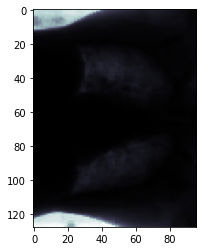

In [ ]:
plt.imshow(NS_ESTIM_HE_175,cmap=plt.cm.bone)

### Metrics - Single Energy

In [ ]:
# PARA IMÁGENES RECORTADAS + ROI
lineah1 = 15
lineah2 = 110
lineav2 = 90


# MODELO SINGLE
DIF_HE_rel = np.mean(abs(S_REF_HE_175[lineah1:lineah2,0:lineav2]-S_ESTIM_HE_175[lineah1:lineah2,0:lineav2])/(S_REF_HE_175[lineah1:lineah2,0:lineav2]+S_ESTIM_HE_175[lineah1:lineah2,0:lineav2]))
DIF_HE_NSrel = np.mean(abs(NS_REF_HE_175[lineah1:lineah2,0:lineav2]-NS_ESTIM_HE_175[lineah1:lineah2,0:lineav2])/(NS_REF_HE_175[lineah1:lineah2,0:lineav2]+NS_ESTIM_HE_175[lineah1:lineah2,0:lineav2]))
MAPE_S_HE = mean_absolute_percentage_error(S_REF_HE_175[lineah1:lineah2,0:lineav2],S_ESTIM_HE_175[lineah1:lineah2,0:lineav2])
MAPE_NS_HE = mean_absolute_percentage_error(NS_REF_HE_175[lineah1:lineah2,0:lineav2],NS_ESTIM_HE_175[lineah1:lineah2,0:lineav2])
MSE_S_HE = mean_squared_error(S_REF_HE_175[lineah1:lineah2,0:lineav2],S_ESTIM_HE_175[lineah1:lineah2,0:lineav2])
MSE_NS_HE = mean_squared_error(NS_REF_HE_175[lineah1:lineah2,0:lineav2],NS_ESTIM_HE_175[lineah1:lineah2,0:lineav2])
SSIM_S_single = ssim(S_REF_HE_175[lineah1:lineah2,0:lineav2],S_ESTIM_HE_175[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_NS_single = ssim(NS_REF_HE_175[lineah1:lineah2,0:lineav2],NS_ESTIM_HE_175[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_S_HE0 = SSIM_S_single[0]
SSIM_NS_HE0 = SSIM_NS_single[0]


In [ ]:
print('Diferencia relativa: ',DIF_HE_NSrel)
print('MAPE: ',MAPE_NS_HE)
print('MSE: ',MSE_NS_HE)
print('SSIM: ',SSIM_NS_HE0)

Diferencia relativa:  0.051894467
MAPE:  0.111152716
MSE:  5.7556144e-06
SSIM:  0.9981654150016197


### Estimación y Corrección Scatter - Dual Energy

In [ ]:
# input_HE = np.concatenate([PROJ_THE,PROJ_THE/PROJ_SHE,PROJ_SHE],-1)
input_DUAL = np.concatenate([PROJ_TLE,PROJ_THE,PROJ_SHE/PROJ_THE],-1)

In [ ]:
test_DUAL = input_DUAL #np.expand_dims(x_val_DUAL_2chn[idx,:,1:129,:],axis=0)
estim_DUAL = model_DUAL.predict(test_DUAL)
ST_ESTIM_DUAL_175 = np.squeeze(estim_DUAL[:,:,:,0]) #Para sólo un canal en el output // Si hay dos canales: estim_DUAL[:,:,:,1]
S_ESTIM_DUAL_175 = ST_ESTIM_DUAL_175*np.squeeze(PROJ_THE[0,:,:,0])
NS_ESTIM_DUAL_175 = np.squeeze(PROJ_THE[0,:,:,0])-S_ESTIM_DUAL_175
S_REF_HE_175 = np.squeeze(PROJ_SHE[0,:,:,0])
NS_REF_HE_175 = np.squeeze(PROJ_NSHE[0,:,:,0])

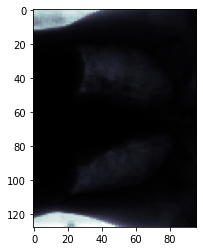

In [ ]:
plt.imshow(NS_ESTIM_DUAL_175,cmap=plt.cm.bone)

### Metrics - Dual Energy

In [ ]:
# PARA IMÁGENES RECORTADAS + ROI
lineah1 = 15
lineah2 = 110
lineav2 = 90


# MODELO DUAL
DIF_DUAL_rel = np.mean(abs(S_REF_HE_175[lineah1:lineah2,0:lineav2]-S_ESTIM_DUAL_175[lineah1:lineah2,0:lineav2])/(S_REF_HE_175[lineah1:lineah2,0:lineav2]+S_ESTIM_DUAL_175[lineah1:lineah2,0:lineav2]))
DIF_DUAL_NSrel = np.mean(abs(NS_REF_HE_175[lineah1:lineah2,0:lineav2]-NS_ESTIM_DUAL_175[lineah1:lineah2,0:lineav2])/(NS_REF_HE_175[lineah1:lineah2,0:lineav2]+NS_ESTIM_DUAL_175[lineah1:lineah2,0:lineav2]))
MAPE_S_DUAL = mean_absolute_percentage_error(S_REF_HE_175[lineah1:lineah2,0:lineav2],S_ESTIM_DUAL_175[lineah1:lineah2,0:lineav2])
MAPE_NS_DUAL = mean_absolute_percentage_error(NS_REF_HE_175[lineah1:lineah2,0:lineav2],NS_ESTIM_DUAL_175[lineah1:lineah2,0:lineav2])
MSE_S_DUAL = mean_squared_error(S_REF_HE_175[lineah1:lineah2,0:lineav2],S_ESTIM_DUAL_175[lineah1:lineah2,0:lineav2])
MSE_NS_DUAL = mean_squared_error(NS_REF_HE_175[lineah1:lineah2,0:lineav2],NS_ESTIM_DUAL_175[lineah1:lineah2,0:lineav2])
SSIM_S_dual = ssim(S_REF_HE_175[lineah1:lineah2,0:lineav2],S_ESTIM_DUAL_175[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_NS_dual = ssim(NS_REF_HE_175[lineah1:lineah2,0:lineav2],NS_ESTIM_DUAL_175[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_S_DUAL0 = SSIM_S_dual[0]
SSIM_NS_DUAL0 = SSIM_NS_dual[0]


In [ ]:
print('Diferencia relativa: ',DIF_DUAL_NSrel)
print('MAPE: ',MAPE_NS_DUAL)
print('MSE: ',MSE_NS_DUAL)
print('SSIM: ',SSIM_NS_DUAL0)

Diferencia relativa:  0.04748775
MAPE:  0.0897671
MSE:  5.544362e-06
SSIM:  0.9981336864382045


## PRUEBA: DSD=190 cm

### Load Projections

In [ ]:
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_SHE_A-0462_DSD190.raw'
PROJ_SHE = np.fromfile(filename,dtype='float32')
PROJ_SHE = np.reshape(PROJ_SHE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_NSHE_A-0462_DSD190.raw'
PROJ_NSHE = np.fromfile(filename,dtype='float32')
PROJ_NSHE = np.reshape(PROJ_NSHE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_THE_A-0462_DSD190.raw'
PROJ_THE = np.fromfile(filename,dtype='float32')
PROJ_THE = np.reshape(PROJ_THE,(2050,2050))


In [ ]:
PROJ_SHE = np.expand_dims(PROJ_SHE,axis=-1)
PROJ_SHE = np.expand_dims(PROJ_SHE,axis=0)
PROJ_NSHE = np.expand_dims(PROJ_NSHE,axis=-1)
PROJ_NSHE = np.expand_dims(PROJ_NSHE,axis=0)
PROJ_THE = np.expand_dims(PROJ_THE,axis=-1)
PROJ_THE = np.expand_dims(PROJ_THE,axis=0)

PROJ_SHE = tf.convert_to_tensor(PROJ_SHE, tf.float32)
PROJ_NSHE = tf.convert_to_tensor(PROJ_NSHE, tf.float32)
PROJ_THE = tf.convert_to_tensor(PROJ_THE, tf.float32)

Nx2 = 128 #256
Ny2 = 128

PROJ_SHE = tf.image.resize(PROJ_SHE,[Nx2,Ny2],method='bilinear')
PROJ_NSHE = tf.image.resize(PROJ_NSHE,[Nx2,Ny2],method='bilinear')
PROJ_THE = tf.image.resize(PROJ_THE,[Nx2,Ny2],method='bilinear')

In [ ]:
PROJ_SHE = PROJ_SHE.numpy()

PROJ_THE = PROJ_THE.numpy()

PROJ_NSHE = PROJ_NSHE.numpy()

In [ ]:
PROJ_SHE = PROJ_SHE[:,:,16:112,:]

PROJ_THE = PROJ_THE[:,:,16:112,:]

PROJ_NSHE = PROJ_NSHE[:,:,16:112,:]

In [ ]:
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_SLE_A-0462_DSD190.raw'
PROJ_SLE = np.fromfile(filename,dtype='float32')
PROJ_SLE = np.reshape(PROJ_SLE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_NSLE_A-0462_DSD190.raw'
PROJ_NSLE = np.fromfile(filename,dtype='float32')
PROJ_NSLE = np.reshape(PROJ_NSLE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_TLE_A-0462_DSD190.raw'
PROJ_TLE = np.fromfile(filename,dtype='float32')
PROJ_TLE = np.reshape(PROJ_TLE,(2050,2050))


In [ ]:
PROJ_SLE = np.expand_dims(PROJ_SLE,axis=-1)
PROJ_SLE = np.expand_dims(PROJ_SLE,axis=0)
PROJ_NSLE = np.expand_dims(PROJ_NSLE,axis=-1)
PROJ_NSLE = np.expand_dims(PROJ_NSLE,axis=0)
PROJ_TLE = np.expand_dims(PROJ_TLE,axis=-1)
PROJ_TLE = np.expand_dims(PROJ_TLE,axis=0)

PROJ_SLE = tf.convert_to_tensor(PROJ_SLE, tf.float32)
PROJ_NSLE = tf.convert_to_tensor(PROJ_NSLE, tf.float32)
PROJ_TLE = tf.convert_to_tensor(PROJ_TLE, tf.float32)

Nx2 = 128 #256
Ny2 = 128

PROJ_SLE = tf.image.resize(PROJ_SLE,[Nx2,Ny2],method='bilinear')
PROJ_NSLE = tf.image.resize(PROJ_NSLE,[Nx2,Ny2],method='bilinear')
PROJ_TLE = tf.image.resize(PROJ_TLE,[Nx2,Ny2],method='bilinear')

In [ ]:
PROJ_SLE = PROJ_SLE.numpy()

PROJ_TLE = PROJ_TLE.numpy()

PROJ_NSLE = PROJ_NSLE.numpy()

In [ ]:
PROJ_SLE = PROJ_SLE[:,:,16:112,:]

PROJ_TLE = PROJ_TLE[:,:,16:112,:]

PROJ_NSLE = PROJ_NSLE[:,:,16:112,:]

### Estimación y Corrección Scatter - Single Energy

In [ ]:
input_HE_190 = np.concatenate([PROJ_THE,PROJ_THE/PROJ_SHE,PROJ_SHE],-1)
# input_DUAL = np.concatenate([total_LE,total_HE,scat_ref_HE/total_HE],-1)

In [ ]:
test_HE_190 = input_HE_190 #np.expand_dims(input_HE[idx+100,:,:,:],axis=0)
estim_HE_190 = model_HE.predict(test_HE_190)
#TOT_LE = np.squeeze(test_LE)
ST_ESTIM_HE_190 = np.squeeze(estim_HE_190)
S_ESTIM_HE_190 = ST_ESTIM_HE_190*np.squeeze(PROJ_THE[0,:,:,0])
NS_ESTIM_HE_190 = np.squeeze(PROJ_THE[0,:,:,0])-S_ESTIM_HE_190
#S_ESTIM_HE[idx,:,:] = np.where(S_ESTIM_HE[idx,:,:] < 0,0,S_ESTIM_HE[idx,:,:])
S_REF_HE_190 = np.squeeze(PROJ_SHE[0,:,:,0])
NS_REF_HE_190 = np.squeeze(PROJ_NSHE[0,:,:,0])

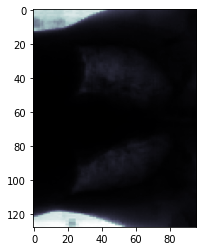

In [ ]:
plt.imshow(NS_ESTIM_HE_190,cmap=plt.cm.bone)

### Metrics - Single Energy

In [ ]:
# PARA IMÁGENES RECORTADAS + ROI
lineah1 = 15
lineah2 = 110
lineav2 = 90


# MODELO SINGLE
DIF_HE_rel = np.mean(abs(S_REF_HE_190[lineah1:lineah2,0:lineav2]-S_ESTIM_HE_190[lineah1:lineah2,0:lineav2])/(S_REF_HE_190[lineah1:lineah2,0:lineav2]+S_ESTIM_HE_190[lineah1:lineah2,0:lineav2]))
DIF_HE_NSrel = np.mean(abs(NS_REF_HE_190[lineah1:lineah2,0:lineav2]-NS_ESTIM_HE_190[lineah1:lineah2,0:lineav2])/(NS_REF_HE_190[lineah1:lineah2,0:lineav2]+NS_ESTIM_HE_190[lineah1:lineah2,0:lineav2]))
MAPE_S_HE = mean_absolute_percentage_error(S_REF_HE_190[lineah1:lineah2,0:lineav2],S_ESTIM_HE_190[lineah1:lineah2,0:lineav2])
MAPE_NS_HE = mean_absolute_percentage_error(NS_REF_HE_190[lineah1:lineah2,0:lineav2],NS_ESTIM_HE_190[lineah1:lineah2,0:lineav2])
MSE_S_HE = mean_squared_error(S_REF_HE_190[lineah1:lineah2,0:lineav2],S_ESTIM_HE_190[lineah1:lineah2,0:lineav2])
MSE_NS_HE = mean_squared_error(NS_REF_HE_190[lineah1:lineah2,0:lineav2],NS_ESTIM_HE_190[lineah1:lineah2,0:lineav2])
SSIM_S_single = ssim(S_REF_HE_190[lineah1:lineah2,0:lineav2],S_ESTIM_HE_190[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_NS_single = ssim(NS_REF_HE_190[lineah1:lineah2,0:lineav2],NS_ESTIM_HE_190[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_S_HE0 = SSIM_S_single[0]
SSIM_NS_HE0 = SSIM_NS_single[0]


In [ ]:
print('Diferencia relativa: ',DIF_HE_NSrel)
print('MAPE: ',MAPE_NS_HE)
print('MSE: ',MSE_NS_HE)
print('SSIM: ',SSIM_NS_HE0)

Diferencia relativa:  0.052852936
MAPE:  0.11456954
MSE:  5.6238164e-06
SSIM:  0.9981477799829576


### Estimación y Corrección Scatter - Dual Energy

In [ ]:
# input_HE = np.concatenate([PROJ_THE,PROJ_THE/PROJ_SHE,PROJ_SHE],-1)
input_DUAL = np.concatenate([PROJ_TLE,PROJ_THE,PROJ_SHE/PROJ_THE],-1)

In [ ]:
test_DUAL = input_DUAL #np.expand_dims(x_val_DUAL_2chn[idx,:,1:129,:],axis=0)
estim_DUAL = model_DUAL.predict(test_DUAL)
ST_ESTIM_DUAL_190 = np.squeeze(estim_DUAL[:,:,:,0]) #Para sólo un canal en el output // Si hay dos canales: estim_DUAL[:,:,:,1]
S_ESTIM_DUAL_190 = ST_ESTIM_DUAL_190*np.squeeze(PROJ_THE[0,:,:,0])
NS_ESTIM_DUAL_190 = np.squeeze(PROJ_THE[0,:,:,0])-S_ESTIM_DUAL_190
S_REF_HE_190 = np.squeeze(PROJ_SHE[0,:,:,0])
NS_REF_HE_190 = np.squeeze(PROJ_NSHE[0,:,:,0])

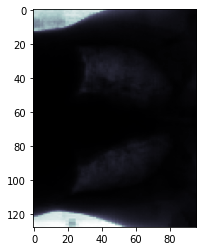

In [ ]:
plt.imshow(NS_ESTIM_DUAL_190,cmap=plt.cm.bone)

### Metrics - Dual Energy

In [ ]:
# PARA IMÁGENES RECORTADAS + ROI
lineah1 = 15
lineah2 = 110
lineav2 = 90


# MODELO DUAL
DIF_DUAL_rel = np.mean(abs(S_REF_HE_190[lineah1:lineah2,0:lineav2]-S_ESTIM_DUAL_190[lineah1:lineah2,0:lineav2])/(S_REF_HE_190[lineah1:lineah2,0:lineav2]+S_ESTIM_DUAL_190[lineah1:lineah2,0:lineav2]))
DIF_DUAL_NSrel = np.mean(abs(NS_REF_HE_190[lineah1:lineah2,0:lineav2]-NS_ESTIM_DUAL_190[lineah1:lineah2,0:lineav2])/(NS_REF_HE_190[lineah1:lineah2,0:lineav2]+NS_ESTIM_DUAL_190[lineah1:lineah2,0:lineav2]))
MAPE_S_DUAL = mean_absolute_percentage_error(S_REF_HE_190[lineah1:lineah2,0:lineav2],S_ESTIM_DUAL_190[lineah1:lineah2,0:lineav2])
MAPE_NS_DUAL = mean_absolute_percentage_error(NS_REF_HE_190[lineah1:lineah2,0:lineav2],NS_ESTIM_DUAL_190[lineah1:lineah2,0:lineav2])
MSE_S_DUAL = mean_squared_error(S_REF_HE_190[lineah1:lineah2,0:lineav2],S_ESTIM_DUAL_190[lineah1:lineah2,0:lineav2])
MSE_NS_DUAL = mean_squared_error(NS_REF_HE_190[lineah1:lineah2,0:lineav2],NS_ESTIM_DUAL_190[lineah1:lineah2,0:lineav2])
SSIM_S_dual = ssim(S_REF_HE_190[lineah1:lineah2,0:lineav2],S_ESTIM_DUAL_190[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_NS_dual = ssim(NS_REF_HE_190[lineah1:lineah2,0:lineav2],NS_ESTIM_DUAL_190[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_S_DUAL0 = SSIM_S_dual[0]
SSIM_NS_DUAL0 = SSIM_NS_dual[0]


In [ ]:
print('Diferencia relativa: ',DIF_DUAL_NSrel)
print('MAPE: ',MAPE_NS_DUAL)
print('MSE: ',MSE_NS_DUAL)
print('SSIM: ',SSIM_NS_DUAL0)

Diferencia relativa:  0.046182998
MAPE:  0.088374294
MSE:  5.359486e-06
SSIM:  0.9983158132344738


## PRUEBA: DSD=170 cm

### Load Projections

In [ ]:
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_SHE_A-0462_DSD170.raw'
PROJ_SHE = np.fromfile(filename,dtype='float32')
PROJ_SHE = np.reshape(PROJ_SHE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_NSHE_A-0462_DSD170.raw'
PROJ_NSHE = np.fromfile(filename,dtype='float32')
PROJ_NSHE = np.reshape(PROJ_NSHE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_THE_A-0462_DSD170.raw'
PROJ_THE = np.fromfile(filename,dtype='float32')
PROJ_THE = np.reshape(PROJ_THE,(2050,2050))


In [ ]:
PROJ_SHE = np.expand_dims(PROJ_SHE,axis=-1)
PROJ_SHE = np.expand_dims(PROJ_SHE,axis=0)
PROJ_NSHE = np.expand_dims(PROJ_NSHE,axis=-1)
PROJ_NSHE = np.expand_dims(PROJ_NSHE,axis=0)
PROJ_THE = np.expand_dims(PROJ_THE,axis=-1)
PROJ_THE = np.expand_dims(PROJ_THE,axis=0)

PROJ_SHE = tf.convert_to_tensor(PROJ_SHE, tf.float32)
PROJ_NSHE = tf.convert_to_tensor(PROJ_NSHE, tf.float32)
PROJ_THE = tf.convert_to_tensor(PROJ_THE, tf.float32)

Nx2 = 128 #256
Ny2 = 128

PROJ_SHE = tf.image.resize(PROJ_SHE,[Nx2,Ny2],method='bilinear')
PROJ_NSHE = tf.image.resize(PROJ_NSHE,[Nx2,Ny2],method='bilinear')
PROJ_THE = tf.image.resize(PROJ_THE,[Nx2,Ny2],method='bilinear')

In [ ]:
PROJ_SHE = PROJ_SHE.numpy()

PROJ_THE = PROJ_THE.numpy()

PROJ_NSHE = PROJ_NSHE.numpy()

In [ ]:
PROJ_SHE = PROJ_SHE[:,:,16:112,:]

PROJ_THE = PROJ_THE[:,:,16:112,:]

PROJ_NSHE = PROJ_NSHE[:,:,16:112,:]

In [ ]:
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_SLE_A-0462_DSD170.raw'
PROJ_SLE = np.fromfile(filename,dtype='float32')
PROJ_SLE = np.reshape(PROJ_SLE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_NSLE_A-0462_DSD170.raw'
PROJ_NSLE = np.fromfile(filename,dtype='float32')
PROJ_NSLE = np.reshape(PROJ_NSLE,(2050,2050))
filename = 'drive/My Drive/ENERGIA_DUAL_IMAGENES/P_TLE_A-0462_DSD170.raw'
PROJ_TLE = np.fromfile(filename,dtype='float32')
PROJ_TLE = np.reshape(PROJ_TLE,(2050,2050))


In [ ]:
PROJ_SLE = np.expand_dims(PROJ_SLE,axis=-1)
PROJ_SLE = np.expand_dims(PROJ_SLE,axis=0)
PROJ_NSLE = np.expand_dims(PROJ_NSLE,axis=-1)
PROJ_NSLE = np.expand_dims(PROJ_NSLE,axis=0)
PROJ_TLE = np.expand_dims(PROJ_TLE,axis=-1)
PROJ_TLE = np.expand_dims(PROJ_TLE,axis=0)

PROJ_SLE = tf.convert_to_tensor(PROJ_SLE, tf.float32)
PROJ_NSLE = tf.convert_to_tensor(PROJ_NSLE, tf.float32)
PROJ_TLE = tf.convert_to_tensor(PROJ_TLE, tf.float32)

Nx2 = 128 #256
Ny2 = 128

PROJ_SLE = tf.image.resize(PROJ_SLE,[Nx2,Ny2],method='bilinear')
PROJ_NSLE = tf.image.resize(PROJ_NSLE,[Nx2,Ny2],method='bilinear')
PROJ_TLE = tf.image.resize(PROJ_TLE,[Nx2,Ny2],method='bilinear')

In [ ]:
PROJ_SLE = PROJ_SLE.numpy()

PROJ_TLE = PROJ_TLE.numpy()

PROJ_NSLE = PROJ_NSLE.numpy()

In [ ]:
PROJ_SLE = PROJ_SLE[:,:,16:112,:]

PROJ_TLE = PROJ_TLE[:,:,16:112,:]

PROJ_NSLE = PROJ_NSLE[:,:,16:112,:]

### Estimación y Corrección Scatter - Single Energy

In [ ]:
input_HE_170 = np.concatenate([PROJ_THE,PROJ_THE/PROJ_SHE,PROJ_SHE],-1)
# input_DUAL = np.concatenate([total_LE,total_HE,scat_ref_HE/total_HE],-1)

In [ ]:
test_HE_170 = input_HE_170 #np.expand_dims(input_HE[idx+100,:,:,:],axis=0)
estim_HE_170 = model_HE.predict(test_HE_170)
#TOT_LE = np.squeeze(test_LE)
ST_ESTIM_HE_170 = np.squeeze(estim_HE_170)
S_ESTIM_HE_170 = ST_ESTIM_HE_170*np.squeeze(PROJ_THE[0,:,:,0])
NS_ESTIM_HE_170 = np.squeeze(PROJ_THE[0,:,:,0])-S_ESTIM_HE_170
#S_ESTIM_HE[idx,:,:] = np.where(S_ESTIM_HE[idx,:,:] < 0,0,S_ESTIM_HE[idx,:,:])
S_REF_HE_170 = np.squeeze(PROJ_SHE[0,:,:,0])
NS_REF_HE_170 = np.squeeze(PROJ_NSHE[0,:,:,0])

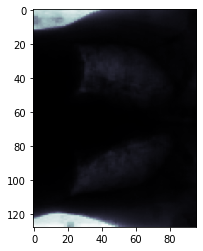

In [ ]:
plt.imshow(NS_ESTIM_HE_170,cmap=plt.cm.bone)

### Metrics - Single Energy

In [ ]:
# PARA IMÁGENES RECORTADAS + ROI
lineah1 = 15
lineah2 = 110
lineav2 = 90


# MODELO SINGLE
DIF_HE_rel = np.mean(abs(S_REF_HE_170[lineah1:lineah2,0:lineav2]-S_ESTIM_HE_170[lineah1:lineah2,0:lineav2])/(S_REF_HE_170[lineah1:lineah2,0:lineav2]+S_ESTIM_HE_170[lineah1:lineah2,0:lineav2]))
DIF_HE_NSrel = np.mean(abs(NS_REF_HE_170[lineah1:lineah2,0:lineav2]-NS_ESTIM_HE_170[lineah1:lineah2,0:lineav2])/(NS_REF_HE_170[lineah1:lineah2,0:lineav2]+NS_ESTIM_HE_170[lineah1:lineah2,0:lineav2]))
MAPE_S_HE = mean_absolute_percentage_error(S_REF_HE_170[lineah1:lineah2,0:lineav2],S_ESTIM_HE_170[lineah1:lineah2,0:lineav2])
MAPE_NS_HE = mean_absolute_percentage_error(NS_REF_HE_170[lineah1:lineah2,0:lineav2],NS_ESTIM_HE_170[lineah1:lineah2,0:lineav2])
MSE_S_HE = mean_squared_error(S_REF_HE_170[lineah1:lineah2,0:lineav2],S_ESTIM_HE_170[lineah1:lineah2,0:lineav2])
MSE_NS_HE = mean_squared_error(NS_REF_HE_170[lineah1:lineah2,0:lineav2],NS_ESTIM_HE_170[lineah1:lineah2,0:lineav2])
SSIM_S_single = ssim(S_REF_HE_170[lineah1:lineah2,0:lineav2],S_ESTIM_HE_170[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_NS_single = ssim(NS_REF_HE_170[lineah1:lineah2,0:lineav2],NS_ESTIM_HE_170[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_S_HE0 = SSIM_S_single[0]
SSIM_NS_HE0 = SSIM_NS_single[0]


In [ ]:
print('Diferencia relativa: ',DIF_HE_NSrel)
print('MAPE: ',MAPE_NS_HE)
print('MSE: ',MSE_NS_HE)
print('SSIM: ',SSIM_NS_HE0)

Diferencia relativa:  0.051117804
MAPE:  0.11006531
MSE:  5.604646e-06
SSIM:  0.9982165523801338


### Estimación y Corrección Scatter - Dual Energy

In [ ]:
# input_HE = np.concatenate([PROJ_THE,PROJ_THE/PROJ_SHE,PROJ_SHE],-1)
input_DUAL = np.concatenate([PROJ_TLE,PROJ_THE,PROJ_SHE/PROJ_THE],-1)

In [ ]:
test_DUAL = input_DUAL #np.expand_dims(x_val_DUAL_2chn[idx,:,1:129,:],axis=0)
estim_DUAL = model_DUAL.predict(test_DUAL)
ST_ESTIM_DUAL_170 = np.squeeze(estim_DUAL[:,:,:,0]) #Para sólo un canal en el output // Si hay dos canales: estim_DUAL[:,:,:,1]
S_ESTIM_DUAL_170 = ST_ESTIM_DUAL_170*np.squeeze(PROJ_THE[0,:,:,0])
NS_ESTIM_DUAL_170 = np.squeeze(PROJ_THE[0,:,:,0])-S_ESTIM_DUAL_170
S_REF_HE_170 = np.squeeze(PROJ_SHE[0,:,:,0])
NS_REF_HE_170 = np.squeeze(PROJ_NSHE[0,:,:,0])

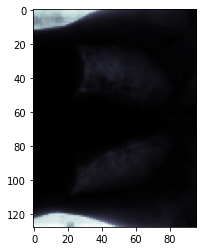

In [ ]:
plt.imshow(NS_ESTIM_DUAL_170,cmap=plt.cm.bone)

### Metrics - Dual Energy

In [ ]:
# PARA IMÁGENES RECORTADAS + ROI
lineah1 = 15
lineah2 = 110
lineav2 = 90


# MODELO DUAL
DIF_DUAL_rel = np.mean(abs(S_REF_HE_170[lineah1:lineah2,0:lineav2]-S_ESTIM_DUAL_170[lineah1:lineah2,0:lineav2])/(S_REF_HE_170[lineah1:lineah2,0:lineav2]+S_ESTIM_DUAL_170[lineah1:lineah2,0:lineav2]))
DIF_DUAL_NSrel = np.mean(abs(NS_REF_HE_170[lineah1:lineah2,0:lineav2]-NS_ESTIM_DUAL_170[lineah1:lineah2,0:lineav2])/(NS_REF_HE_170[lineah1:lineah2,0:lineav2]+NS_ESTIM_DUAL_170[lineah1:lineah2,0:lineav2]))
MAPE_S_DUAL = mean_absolute_percentage_error(S_REF_HE_170[lineah1:lineah2,0:lineav2],S_ESTIM_DUAL_170[lineah1:lineah2,0:lineav2])
MAPE_NS_DUAL = mean_absolute_percentage_error(NS_REF_HE_170[lineah1:lineah2,0:lineav2],NS_ESTIM_DUAL_170[lineah1:lineah2,0:lineav2])
MSE_S_DUAL = mean_squared_error(S_REF_HE_170[lineah1:lineah2,0:lineav2],S_ESTIM_DUAL_170[lineah1:lineah2,0:lineav2])
MSE_NS_DUAL = mean_squared_error(NS_REF_HE_170[lineah1:lineah2,0:lineav2],NS_ESTIM_DUAL_170[lineah1:lineah2,0:lineav2])
SSIM_S_dual = ssim(S_REF_HE_170[lineah1:lineah2,0:lineav2],S_ESTIM_DUAL_170[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_NS_dual = ssim(NS_REF_HE_170[lineah1:lineah2,0:lineav2],NS_ESTIM_DUAL_170[lineah1:lineah2,0:lineav2],gradient=True,full=True)
SSIM_S_DUAL0 = SSIM_S_dual[0]
SSIM_NS_DUAL0 = SSIM_NS_dual[0]


In [ ]:
print('Diferencia relativa: ',DIF_DUAL_NSrel)
print('MAPE: ',MAPE_NS_DUAL)
print('MSE: ',MSE_NS_DUAL)
print('SSIM: ',SSIM_NS_DUAL0)

Diferencia relativa:  0.048092276
MAPE:  0.090555415
MSE:  5.416011e-06
SSIM:  0.998152949506606
